In [1]:
import os
import numpy as np
import nibabel as nib
from scipy.stats import scoreatpercentile, linregress
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Functions

## Correlations

### Linear and Quad

In [2]:
def voxelwise_corrs(patientlist, session, vasclabel):
    path = "/home/bpereira/func/"
    ses = session
    restpath = f"{ses}/{ses}-proc.feat/maps_to_corr/"

    lin_adjr2_happy = []
    quad_adjr2_happy = []
    lin_adjr2_angry = []
    quad_adjr2_angry = []
    lin_adjr2_vis = []
    quad_adjr2_vis = []

    count=5
    #pvalsh = []

    for sub in patientlist:

        happy_path = os.path.join(path,sub,restpath,f"{sub}_{ses}_mapCOPE8_smoothed8.nii")
        angry_path = os.path.join(path,sub,restpath,f"{sub}_{ses}_mapCOPE9_smoothed8.nii")
        vis_path = os.path.join(path,sub,restpath,f"{sub}_{ses}_mapCOPE4_smoothed8.nii")

        maskhappy_path = "/home/bpereira/func/HL/with_EMPs/randomiseGM_EMP/GM_COPE8_EMP_thr95.nii.gz"
        maskangry_path = "/home/bpereira/func/HL/with_EMPs/randomiseGM_EMP/GM_COPE9_EMP_thr95.nii.gz"
        maskvis_path = "/home/bpereira/func/HL/with_EMPs/randomiseGM_EMP/GM_COPE4_EMP_thr95.nii.gz"

        if vasclabel=='ASL':
            vasc_path = os.path.join("/home/mig_n2treatdata/derivatives/perf-preproc/",sub,ses,"smoothed8_perfusion_MNI.nii")
        else:
            vasc_path = os.path.join("/home/mig_n2treatdata/derivatives/func-preproc/func-task_breathhold/",sub,ses,"smoothed8_CVR_single_delay6_deltapet_thrvar_MNI.nii")
            #print("entered")
    
        # load data
        happynii = nib.load(happy_path)
        happy = happynii.get_fdata()

        angrynii = nib.load(angry_path)
        angry = angrynii.get_fdata()

        visnii = nib.load(vis_path)
        vis = visnii.get_fdata()

        maskhappynii = nib.load(maskhappy_path)
        maskhappy = maskhappynii.get_fdata()

        maskangrynii = nib.load(maskangry_path)
        maskangry = maskangrynii.get_fdata()

        maskvisnii = nib.load(maskvis_path)
        maskvis = maskvisnii.get_fdata()

        vascnii = nib.load(vasc_path)
        vasc = vascnii.get_fdata()

        # cut due to ASLs FOV

        cuthappy = happy[:,:,16:68]
        cutangry = angry[:,:,16:68]
        cutvis = vis[:,:,16:68]
        cutmaskh = maskhappy[:,:,16:68]
        cutmaska = maskangry[:,:,16:68]
        cutmaskv = maskvis[:,:,16:68]

        cutvasc = vasc[:,:,16:68]

        # flatten

        flatcuthappy = cuthappy.flatten()
        flatcutangry = cutangry.flatten()
        flatcutvis = cutvis.flatten()

        flatcutvasc = cutvasc.flatten()

        # keep only areas from the mask

        maskhappy_ind = np.where(cutmaskh.flatten()==1)
        maskangry_ind = np.where(cutmaska.flatten()==1)
        maskvis_ind = np.where(cutmaskv.flatten()==1)

        # keep only activation areas

        #happy_actind = np.where(testhappy>0)
        #angry_actind = np.where(testangry>0)
        #vis_actind = np.where(testvis>0)

        # remove outliers from vasc maps

        qvasc1 = scoreatpercentile(flatcutvasc,1)
        qvasc99 = scoreatpercentile(flatcutvasc,99)

        # find index of non outliers

        vasc_non_outliers_ind = np.where((flatcutvasc > qvasc1) & (flatcutvasc < qvasc99))

        # keep only non outliers from neuronal and vasc maps and areas from the mask

        commonhappy_nonoutliers_mask_ind = np.intersect1d(vasc_non_outliers_ind,maskhappy_ind)
        commonangry_nonoutliers_mask_ind = np.intersect1d(vasc_non_outliers_ind,maskangry_ind)
        commonvis_nonoutliers_mask_ind = np.intersect1d(vasc_non_outliers_ind,maskvis_ind)

        # select only common voxels

        flatfinalhappy= flatcuthappy[commonhappy_nonoutliers_mask_ind]
        flatfinalangry = flatcutangry[commonangry_nonoutliers_mask_ind]
        flatfinalvis = flatcutvis[commonvis_nonoutliers_mask_ind]

        flatfinalvaschappy = flatcutvasc[commonhappy_nonoutliers_mask_ind]
        flatfinalvascangry = flatcutvasc[commonangry_nonoutliers_mask_ind]
        flatfinalvascvis = flatcutvasc[commonvis_nonoutliers_mask_ind]


        # correlations

        # happy vs vasc

        if len(flatfinalhappy)>0:

            x = flatfinalvaschappy
            y = flatfinalhappy
            slopeh, intercepth, r_valueh, p_valueh, std_errh = linregress(x, y)
            r2h = r_valueh**2
            adj_r2h = 1 - (1 - r2h) * (len(y) - 1) / (len(y)  - 1 - 1) # o valor de p neste caso = 1, por se tratar de linear reg

            lin_adjr2_happy += [adj_r2h]

            hcoefs = np.polyfit(x,y,deg=2)
            yfitquadh = np.polyval(hcoefs, x)
            yresidquad = y - yfitquadh
            SSresidquad = np.sum(yresidquad ** 2)
            SStotalquad = (len(y) - 1) * np.var(y)
            rsqquad = 1 - SSresidquad / SStotalquad
            rsq_adjquadh = 1 - (1 - rsqquad) * (len(y) - 1) / (len(y) - 2 - 1) # p=2, quadratic

            quad_adjr2_happy += [rsq_adjquadh]
        else:
            print(f'Map happy empty for patient {sub}')

        # angry vs vasc 

        if len(flatfinalangry)>0:

            x = flatfinalvascangry
            y = flatfinalangry
            slopea, intercepta, r_valuea, p_valuea, std_erra = linregress(x, y)
            r2a = r_valuea**2
            adj_r2a = 1 - (1 - r2a) * (len(y) - 1) / (len(y)  - 1 - 1) # o valor de p neste caso = 1, por se tratar de linear reg

            lin_adjr2_angry += [adj_r2a]

            acoefs = np.polyfit(x,y,deg=2)
            yfitquada = np.polyval(acoefs, x)
            yresidquad = y - yfitquada
            SSresidquad = np.sum(yresidquad ** 2)
            SStotalquad = (len(y) - 1) * np.var(y)
            rsqquad = 1 - SSresidquad / SStotalquad
            rsq_adjquada = 1 - (1 - rsqquad) * (len(y) - 1) / (len(y) - 2 - 1) # p=2, quadratic

            quad_adjr2_angry += [rsq_adjquada]
        else: 
            print(f"Map angry for patient {sub} empty")

        # vis vs vasc 

        if len(flatfinalvis)>0:

            x = flatfinalvascvis
            y = flatfinalvis
            slopev, interceptv, r_valuev, p_valuev, std_errv = linregress(x, y)
            r2v = r_valuev**2
            adj_r2v = 1 - (1 - r2v) * (len(y) - 1) / (len(y)  - 1 - 1) # o valor de p neste caso = 1, por se tratar de linear reg

            lin_adjr2_vis += [adj_r2v]
            #pvalsv += [p_valuev]

            vcoefs = np.polyfit(x,y,deg=2)
            yfitquadv = np.polyval(vcoefs, x)
            yresidquad = y - yfitquadv
            SSresidquad = np.sum(yresidquad ** 2)
            SStotalquad = (len(y) - 1) * np.var(y)
            rsqquad = 1 - SSresidquad / SStotalquad
            rsq_adjquadv = 1 - (1 - rsqquad) * (len(y) - 1) / (len(y) - 2 - 1) # p=2, quadratic

            quad_adjr2_vis += [rsq_adjquadv]
        else:
            print(f"Map visual empty for {sub}")
        

        count += 1
        if 5<count<8 and (session=='ses-interictal' or session=='ses-midcycle'):
            #count += 2
            plt.figure()

            if len(flatfinalhappy)>0:
                x = flatfinalvaschappy
                y = flatfinalhappy
                plt.scatter(x, y, color='red')
                plt.plot(x, slopeh * x + intercepth, color='blue', label='linear')
                x_regression = np.linspace(min(x), max(x), 100)
                y_regression = np.polyval(hcoefs, x_regression)
                plt.plot(x_regression, y_regression, color='green', label='quad')
                plt.title(f'Happy Network vs {vasclabel}')
                plt.ylabel('Happy Network')
                plt.xlabel({vasclabel})
                plt.legend()
                plt.show()

            if len(flatfinalangry>0):
                x = flatfinalvascangry
                y = flatfinalangry
                plt.figure()
                plt.scatter(x, y, color='red')
                plt.plot(x, slopea * x + intercepta, color='blue', label='linear')
                x_regression = np.linspace(min(x), max(x), 100)
                y_regression = np.polyval(acoefs, x_regression)
                plt.plot(x_regression, y_regression, color='green', label='quad')
                plt.title(f'Angry Network vs {vasclabel}')
                plt.ylabel('Angry Network')
                plt.xlabel({vasclabel})
                plt.legend()
                plt.show()

            if len(flatfinalvis)>0:
                x = flatfinalvascvis
                y = flatfinalvis
                plt.scatter(x, y, color='red')
                plt.plot(x, slopev * x + interceptv, color='blue', label='linear')
                x_regression = np.linspace(min(x), max(x), 100)
                y_regression = np.polyval(vcoefs, x_regression)
                plt.plot(x_regression, y_regression, color='green', label='quad')
                plt.title(f'Visual Network vs {vasclabel}')
                plt.ylabel('Visual Network')
                plt.xlabel({vasclabel})
                plt.legend()
                plt.show()



    return lin_adjr2_happy,lin_adjr2_angry,lin_adjr2_vis,quad_adjr2_happy,quad_adjr2_angry,quad_adjr2_vis



### Polynomial

In [3]:
def voxelwise_corrs_poly(patientlist, session, vasclabel):
    path = "/home/bpereira/func/"
    ses = session
    restpath = f"{ses}/{ses}-proc.feat/maps_to_corr/"

    adjr2_happy = []
    adjr2_angry = []
    adjr2_vis = []

    count=5
    #pvalsh = []

    for sub in patientlist:

        happy_path = os.path.join(path,sub,restpath,f"{sub}_{ses}_mapCOPE8_smoothed8.nii")
        angry_path = os.path.join(path,sub,restpath,f"{sub}_{ses}_mapCOPE9_smoothed8.nii")
        vis_path = os.path.join(path,sub,restpath,f"{sub}_{ses}_mapCOPE4_smoothed8.nii")

        maskhappy_path = "/home/bpereira/func/HL/with_EMPs/randomiseGM_EMP/GM_COPE8_EMP_thr95.nii.gz"
        maskangry_path = "/home/bpereira/func/HL/with_EMPs/randomiseGM_EMP/GM_COPE9_EMP_thr95.nii.gz"
        maskvis_path = "/home/bpereira/func/HL/with_EMPs/randomiseGM_EMP/GM_COPE4_EMP_thr95.nii.gz"

        if vasclabel=='ASL':
            vasc_path = os.path.join("/home/mig_n2treatdata/derivatives/perf-preproc/",sub,ses,"smoothed8_perfusion_MNI.nii")
        else:
            vasc_path = os.path.join("/home/mig_n2treatdata/derivatives/func-preproc/func-task_breathhold/",sub,ses,"smoothed8_CVR_single_delay6_deltapet_thrvar_MNI.nii")
            #print("entered")
    
        # load data
        happynii = nib.load(happy_path)
        happy = happynii.get_fdata()

        angrynii = nib.load(angry_path)
        angry = angrynii.get_fdata()

        visnii = nib.load(vis_path)
        vis = visnii.get_fdata()

        maskhappynii = nib.load(maskhappy_path)
        maskhappy = maskhappynii.get_fdata()

        maskangrynii = nib.load(maskangry_path)
        maskangry = maskangrynii.get_fdata()

        maskvisnii = nib.load(maskvis_path)
        maskvis = maskvisnii.get_fdata()

        vascnii = nib.load(vasc_path)
        vasc = vascnii.get_fdata()

        # cut due to ASLs FOV

        cuthappy = happy[:,:,16:68]
        cutangry = angry[:,:,16:68]
        cutvis = vis[:,:,16:68]
        cutmaskh = maskhappy[:,:,16:68]
        cutmaska = maskangry[:,:,16:68]
        cutmaskv = maskvis[:,:,16:68]

        cutvasc = vasc[:,:,16:68]

        # flatten

        flatcuthappy = cuthappy.flatten()
        flatcutangry = cutangry.flatten()
        flatcutvis = cutvis.flatten()

        flatcutvasc = cutvasc.flatten()

        # keep only areas from the mask

        maskhappy_ind = np.where(cutmaskh.flatten()==1)
        maskangry_ind = np.where(cutmaska.flatten()==1)
        maskvis_ind = np.where(cutmaskv.flatten()==1)

        # keep only activation areas

        #happy_actind = np.where(testhappy>0)
        #angry_actind = np.where(testangry>0)
        #vis_actind = np.where(testvis>0)

        # remove outliers from vasc maps

        qvasc1 = scoreatpercentile(flatcutvasc,1)
        qvasc99 = scoreatpercentile(flatcutvasc,99)

        # find index of non outliers

        vasc_non_outliers_ind = np.where((flatcutvasc > qvasc1) & (flatcutvasc < qvasc99))

        # keep only non outliers from neuronal and vasc maps and areas from the mask

        commonhappy_nonoutliers_mask_ind = np.intersect1d(vasc_non_outliers_ind,maskhappy_ind)
        commonangry_nonoutliers_mask_ind = np.intersect1d(vasc_non_outliers_ind,maskangry_ind)
        commonvis_nonoutliers_mask_ind = np.intersect1d(vasc_non_outliers_ind,maskvis_ind)

        # select only common voxels

        flatfinalhappy= flatcuthappy[commonhappy_nonoutliers_mask_ind]
        flatfinalangry = flatcutangry[commonangry_nonoutliers_mask_ind]
        flatfinalvis = flatcutvis[commonvis_nonoutliers_mask_ind]

        flatfinalvaschappy = flatcutvasc[commonhappy_nonoutliers_mask_ind]
        flatfinalvascangry = flatcutvasc[commonangry_nonoutliers_mask_ind]
        flatfinalvascvis = flatcutvasc[commonvis_nonoutliers_mask_ind]


        # correlations

        # happy vs vasc

        if len(flatfinalhappy)>0:

            x = np.array(flatfinalvaschappy).reshape(-1,1)
            y = flatfinalhappy
            polyh = PolynomialFeatures(degree=2)
            x_polyh = polyh.fit_transform(x)
            modelh = LinearRegression()
            modelh.fit(x_polyh,y)
            yfith = modelh.predict(x_polyh)
            r2h = r2_score(y,yfith)
        
            n=len(y)
            p = x_polyh.shape[1] - 1 # nb of predictors, excluding the intercept term
            adj_r2h = 1 - (1-r2h) * (n-1) / (n-p-1)

            adjr2_happy += [adj_r2h]
        else:
            print(f'Map happy empty for patient {sub}')

        # angry vs vasc 

        if len(flatfinalangry)>0:

            x = np.array(flatfinalvascangry).reshape(-1,1)
            y = np.array(flatfinalangry)
            polya = PolynomialFeatures(degree=2)
            x_polya = polya.fit_transform(x)
            modela = LinearRegression()
            modela.fit(x_polya,y)
            yfita = modela.predict(x_polya)
            r2a = r2_score(y,yfita)
            
            n=len(y)
            p = x_polya.shape[1] - 1 # nb of predictors, excluding the intercept term
            adj_r2a = 1 - (1-r2a) * (n-1) / (n-p-1)

            adjr2_angry += [adj_r2a]
        else: 
            print(f"Map angry for patient {sub} empty")

        # vis vs vasc 

        if len(flatfinalvis)>0:

            x = np.array(flatfinalvascvis).reshape(-1,1)
            y = flatfinalvis
            polyv = PolynomialFeatures(degree=2)
            x_polyv = polyv.fit_transform(x)
            modelv = LinearRegression()
            modelv.fit(x_polyv,y)
            yfitv = modelv.predict(x_polyv)
            r2v = r2_score(y,yfitv)
            
            n=len(y)
            p = x_polyv.shape[1] - 1 # nb of predictors, excluding the intercept term
            adj_r2v = 1 - (1-r2v) * (n-1) / (n-p-1)

            adjr2_vis += [adj_r2v]
        else:
            print(f"Map visual empty for {sub}")
        

        count += 1
        if 5<count<8 and (session=='ses-interictal' or session=='ses-midcycle'):
            #count += 2
            plt.figure()

            if len(flatfinalhappy)>0:
                x = np.array(flatfinalvaschappy).reshape(-1,1)
                y = flatfinalhappy
                plt.scatter(x, y, color='red')
                x_rangeh = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
                X_range_polyh = polyh.transform(x_rangeh)
                y_rangepredh = modelh.predict(X_range_polyh)
                plt.plot(x_rangeh, y_rangepredh, color='blue', label='a+bx+cx^2')
                plt.title(f'Happy Network vs {vasclabel}')
                plt.ylabel('Happy Network')
                plt.xlabel({vasclabel})
                plt.legend()
                plt.show()

            if len(flatfinalangry>0):
                x = np.array(flatfinalvascangry).reshape(-1,1)
                y = flatfinalangry
                plt.figure()
                plt.scatter(x, y, color='red')
                x_rangea = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
                X_range_polya = polya.transform(x_rangea)
                y_rangepreda = modela.predict(X_range_polya)
                plt.plot(x_rangea, y_rangepreda, color='blue', label='a+bx+cx^2')
                plt.title(f'Angry Network vs {vasclabel}')
                plt.ylabel('Angry Network')
                plt.xlabel({vasclabel})
                plt.legend()
                plt.show()


            if len(flatfinalvis)>0:
                x = np.array(flatfinalvascvis).reshape(-1,1)
                y = flatfinalvis
                plt.scatter(x, y, color='red')
                x_rangev = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
                X_range_polyv = polyv.transform(x_rangev)
                y_rangepredv = modelv.predict(X_range_polyv)
                plt.plot(x_rangev, y_rangepredv, color='blue', label='a+bx+cx^2')
                plt.title(f'Visual Network vs {vasclabel}')
                plt.ylabel('Visual Network')
                plt.xlabel({vasclabel})
                plt.legend()
                plt.show()



    return adjr2_happy,adjr2_angry, adjr2_vis



### Pearson and Spearman

In [4]:
def voxelwise_corrs_pands(patientlist, session, vasclabel):
    path = "/home/bpereira/func/"
    ses = session
    restpath = f"{ses}/{ses}-proc.feat/maps_to_corr/"

    pearson_coefsh = []
    pearson_pvalsh = []

    pearson_coefsa = []
    pearson_pvalsa = []

    pearson_coefsv = []
    pearson_pvalsv = []

    spearman_coefsh = []
    spearman_pvalsh = []

    spearman_coefsa = []
    spearman_pvalsa = []

    spearman_coefsv = []
    spearman_pvalsv = []


    for sub in patientlist:

        happy_path = os.path.join(path,sub,restpath,f"{sub}_{ses}_mapCOPE8_smoothed8.nii")
        angry_path = os.path.join(path,sub,restpath,f"{sub}_{ses}_mapCOPE9_smoothed8.nii")
        vis_path = os.path.join(path,sub,restpath,f"{sub}_{ses}_mapCOPE4_smoothed8.nii")

        maskhappy_path = "/home/bpereira/func/HL/with_EMPs/randomiseGM_EMP/GM_COPE8_EMP_thr95.nii.gz"
        maskangry_path = "/home/bpereira/func/HL/with_EMPs/randomiseGM_EMP/GM_COPE9_EMP_thr95.nii.gz"
        maskvis_path = "/home/bpereira/func/HL/with_EMPs/randomiseGM_EMP/GM_COPE4_EMP_thr95.nii.gz"

        if vasclabel=='ASL':
            vasc_path = os.path.join("/home/mig_n2treatdata/derivatives/perf-preproc/",sub,ses,"smoothed8_perfusion_MNI.nii")
        else:
            vasc_path = os.path.join("/home/mig_n2treatdata/derivatives/func-preproc/func-task_breathhold/",sub,ses,"smoothed8_CVR_single_delay6_deltapet_thrvar_MNI.nii")
            #print("entered")
    
        # load data
        happynii = nib.load(happy_path)
        happy = happynii.get_fdata()

        angrynii = nib.load(angry_path)
        angry = angrynii.get_fdata()

        visnii = nib.load(vis_path)
        vis = visnii.get_fdata()

        maskhappynii = nib.load(maskhappy_path)
        maskhappy = maskhappynii.get_fdata()

        maskangrynii = nib.load(maskangry_path)
        maskangry = maskangrynii.get_fdata()

        maskvisnii = nib.load(maskvis_path)
        maskvis = maskvisnii.get_fdata()

        vascnii = nib.load(vasc_path)
        vasc = vascnii.get_fdata()

        # cut due to ASLs FOV

        cuthappy = happy[:,:,16:68]
        cutangry = angry[:,:,16:68]
        cutvis = vis[:,:,16:68]
        cutmaskh = maskhappy[:,:,16:68]
        cutmaska = maskangry[:,:,16:68]
        cutmaskv = maskvis[:,:,16:68]

        cutvasc = vasc[:,:,16:68]

        # flatten

        flatcuthappy = cuthappy.flatten()
        flatcutangry = cutangry.flatten()
        flatcutvis = cutvis.flatten()

        flatcutvasc = cutvasc.flatten()

        # keep only areas from the mask

        maskhappy_ind = np.where(cutmaskh.flatten()==1)
        maskangry_ind = np.where(cutmaska.flatten()==1)
        maskvis_ind = np.where(cutmaskv.flatten()==1)

        # keep only activation areas

        #happy_actind = np.where(testhappy>0)
        #angry_actind = np.where(testangry>0)
        #vis_actind = np.where(testvis>0)

        # remove outliers from vasc maps

        if vasclabel == 'ASL':

            qvasc1 = scoreatpercentile(flatcutvasc,1)
            qvasc99 = scoreatpercentile(flatcutvasc,99)

            # find index of non outliers

            vasc_non_outliers_ind = np.where((flatcutvasc > qvasc1) & (flatcutvasc < qvasc99))

            # keep only non outliers from neuronal and vasc maps and areas from the mask

            commonhappy_nonoutliers_mask_ind = np.intersect1d(vasc_non_outliers_ind,maskhappy_ind)
            commonangry_nonoutliers_mask_ind = np.intersect1d(vasc_non_outliers_ind,maskangry_ind)
            commonvis_nonoutliers_mask_ind = np.intersect1d(vasc_non_outliers_ind,maskvis_ind)

            # select only common voxels

            flatfinalhappy= flatcuthappy[commonhappy_nonoutliers_mask_ind]
            flatfinalangry = flatcutangry[commonangry_nonoutliers_mask_ind]
            flatfinalvis = flatcutvis[commonvis_nonoutliers_mask_ind]

            flatfinalvaschappy = flatcutvasc[commonhappy_nonoutliers_mask_ind]
            flatfinalvascangry = flatcutvasc[commonangry_nonoutliers_mask_ind]
            flatfinalvascvis = flatcutvasc[commonvis_nonoutliers_mask_ind]

        if vasclabel == 'CVR':

            non_zero = np.where(flatcutvasc > 0)

            commonhappy_nonzero_mask_ind = np.intersect1d(non_zero,maskhappy_ind)
            commonangry_nonzero_mask_ind = np.intersect1d(non_zero,maskangry_ind)
            commonvis_nonzero_mask_ind = np.intersect1d(non_zero,maskvis_ind)

            flatfinalhappy= flatcuthappy[commonhappy_nonzero_mask_ind]
            flatfinalangry = flatcutangry[commonangry_nonzero_mask_ind]
            flatfinalvis = flatcutvis[commonvis_nonzero_mask_ind]

            flatfinalvaschappy = flatcutvasc[commonhappy_nonzero_mask_ind]
            flatfinalvascangry = flatcutvasc[commonangry_nonzero_mask_ind]
            flatfinalvascvis = flatcutvasc[commonvis_nonzero_mask_ind]


        # correlations

        # happy vs vasc

        if len(flatfinalhappy)>0:

            x = np.array(flatfinalvaschappy)
            y = flatfinalhappy
            
            pearsoncoefh, pearsonpvalh = pearsonr(x,y)
            #print(pearsoncoefh)
            
            pearson_coefsh += [pearsoncoefh]
            pearson_pvalsh += [pearsonpvalh]

            spearmancoefh, spearmanpvalh = spearmanr(x,y)

            spearman_coefsh += [spearmancoefh]
            spearman_pvalsh += [spearmanpvalh]
            
        else:
            print(f'Map happy empty for patient {sub}')

        # angry vs vasc 

        if len(flatfinalangry)>0:

            x = np.array(flatfinalvascangry)
            y = np.array(flatfinalangry)
            
            pearsoncoefa, pearsonpvala = pearsonr(x,y)
        
            pearson_coefsa += [pearsoncoefa]
            pearson_pvalsa += [pearsonpvala]

            spearmancoefa, spearmanpvala = spearmanr(x,y)

            spearman_coefsa += [spearmancoefa]
            spearman_pvalsa += [spearmanpvala]
        else: 
            print(f"Map angry for patient {sub} empty")

        # vis vs vasc 

        if len(flatfinalvis)>0:

            x = np.array(flatfinalvascvis)
            y = flatfinalvis
            
            pearsoncoefv, pearsonpvalv = pearsonr(x,y)
        
            pearson_coefsv += [pearsoncoefv]
            pearson_pvalsv += [pearsonpvalv]

            spearmancoefv, spearmanpvalv = spearmanr(x,y)

            spearman_coefsv += [spearmancoefv]
            spearman_pvalsv += [spearmanpvalv]
        else:
            print(f"Map visual empty for {sub}")
        
    
    print(f"{ses} p-vals:\n Pearson (H): {pearson_pvalsh} \n Pearson (A): {pearson_pvalsa} \n Pearson (V): {pearson_pvalsv} \n Spearman (H): {spearman_pvalsh} \n Spearman (A): {spearman_pvalsa} \n Spearman (V): {spearman_pvalsv})")
         

    return pearson_coefsh, pearson_coefsa, pearson_coefsv, spearman_coefsh, spearman_coefsa, spearman_coefsv



## Boxplots

### Linear and Quad boxplots

In [5]:
def define_box_properties(plot_name, color_code, label, linewidth=2):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code, linewidth=linewidth)
         
    # Use plot function to draw a small line to name the legend
    plt.plot([], c=color_code, label=label, linewidth=linewidth)
    plt.legend()

def add_n_annotations(plot_name, data, positions):
    ylim = plt.ylim()
    y_offset = (ylim[1] - ylim[0]) * 0.05  # Adjust this value as needed
    for i, pos in enumerate(positions):
        n = len(data[i])
        plt.text(pos, ylim[1] - y_offset, f'n={n}', ha='center', va='bottom')

def boxplots(linlist, quadlist, ses, metric):
    ticks = ['Happy Network', 'Angry Network', 'Visual Network']

    linear_positions = np.array(np.arange(len(linlist))) * 2.0 - 0.35
    quad_positions = np.array(np.arange(len(quadlist))) * 2.0 + 0.35

    plt.figure(figsize=(12, 8))  # Set the figure size here
    linear_plotint = plt.boxplot(linlist, positions=linear_positions, widths=0.6)
    quad_plotint = plt.boxplot(quadlist, positions=quad_positions, widths=0.6)

    define_box_properties(linear_plotint, '#D7191C', 'Linear', linewidth=2)
    define_box_properties(quad_plotint, '#2C7BB6', 'Quadratic', linewidth=2)

    plt.ylabel('Adjusted r-squared', fontsize=14, weight='heavy')
    plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks, fontsize=12, weight='heavy')
    plt.yticks(fontsize=12, weight='heavy')
    plt.xlim(-2, len(ticks) * 2)
    plt.ylim(-0.05,0.2)
    
    plt.title(f'Voxelwise Correlation Between Neuronal maps and {metric} ({ses})', fontsize=16, weight='heavy')

    add_n_annotations(linear_plotint, linlist, linear_positions)
    add_n_annotations(quad_plotint, quadlist, quad_positions)

    plt.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)  # Thicken the ticks

    for spine in plt.gca().spines.values():
        spine.set_linewidth(2)

    plt.show()  # Show the plot

def boxplots2(linlist, quadlist, net, metric):
    ticks = ['Midcycle', 'Premenstrual', 'Interictal', 'Preictal', 'Ictal', 'Postictal']

    linear_positions = np.array(np.arange(len(linlist))) * 2.0 - 0.35
    quad_positions = np.array(np.arange(len(quadlist))) * 2.0 + 0.35

    plt.figure(figsize=(14, 10))  # Set the figure size here
    linear_plotint = plt.boxplot(linlist, positions=linear_positions, widths=0.6)
    quad_plotint = plt.boxplot(quadlist, positions=quad_positions, widths=0.6)

    define_box_properties(linear_plotint, '#D7191C', 'Linear', linewidth=2)
    define_box_properties(quad_plotint, '#2C7BB6', 'Quadratic', linewidth=2)

    plt.ylabel('Adjusted r-squared', fontsize=14, weight='bold')
    plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks, fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    plt.xlim(-2, len(ticks) * 2)
    plt.ylim(-0.05,0.2)

    plt.title(f'Voxelwise Correlation Between {net} and {metric}', fontsize=16, weight='bold')

    add_n_annotations(linear_plotint, linlist, linear_positions)
    add_n_annotations(quad_plotint, quadlist, quad_positions)

    plt.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)  # Thicken the ticks

    for spine in plt.gca().spines.values():
        spine.set_linewidth(2)

    plt.show()  # Show the plot


### Boxplot polynomial

In [6]:
def boxplots_poly(polylist, ses, metric):
    ticks = ['Happy Network', 'Angry Network', 'Visual Network']

    plt.figure(figsize=(10,6))
    boxprops = dict(linewidth=2.0)
    medianprops = dict(linewidth=2.0)
    whiskerprops = dict(linewidth=2.0)
    capprops = dict(linewidth=2.0)
    flierprops = dict(marker='o', markersize=5, linestyle='none')
    
    # Create the boxplot with custom properties
    bp = plt.boxplot(polylist, widths=0.4,
                boxprops=boxprops, medianprops=medianprops,
                whiskerprops=whiskerprops, capprops=capprops,
                flierprops=flierprops)
    plt.xticks([1,2,3], ticks, fontsize=12, weight='bold')
    plt.ylabel('Adjusted r-squared', fontsize=14, weight='heavy')
    plt.yticks(fontsize=12, weight='bold')
    plt.xlim(0,4)
    plt.ylim(-0.05,0.2)

    for spine in plt.gca().spines.values():
        spine.set_linewidth(2)

    plt.title(f'Voxelwise Correlation between Neuronal maps and {metric} \n({ses})', fontsize=16, weight='heavy')

    # Add counts above each boxplot
    for i, data in enumerate(polylist, start=1):
        count = len(data)
        plt.text(i, 0.175, f'n={count}', ha='center', va='bottom', fontsize=12, weight='bold')

    plt.show()

def boxplots2_poly(polylist, net, metric):
    ticks = ['Midcycle', 'Premenstrual', 'Interictal', 'Preictal', 'Ictal', 'Postictal']

    plt.figure(figsize=(10,6))
    boxprops = dict(linewidth=2.0)
    medianprops = dict(linewidth=2.0)
    whiskerprops = dict(linewidth=2.0)
    capprops = dict(linewidth=2.0)
    flierprops = dict(marker='o', markersize=5, linestyle='none')
    
    # Create the boxplot with custom properties
    bp = plt.boxplot(polylist, widths=0.4,
                boxprops=boxprops, medianprops=medianprops,
                whiskerprops=whiskerprops, capprops=capprops,
                flierprops=flierprops)
    plt.xticks([1,2,3,4,5,6], ticks, fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    plt.ylabel('Adjusted r-squared', fontsize=14, weight='heavy')
    plt.ylim(-0.05,0.2)

    for spine in plt.gca().spines.values():
        spine.set_linewidth(2)

    plt.title(f'Voxelwise Correlation Between {net} and {metric} \n(Polynomial Regression: a+bx+cx^2)', fontsize=16, weight='heavy')

    # Add counts above each boxplot
    for i, data in enumerate(polylist, start=1):
        count = len(data)
        plt.text(i, 0.175, f'n={count}', ha='center', va='bottom', fontsize=12, weight='bold')

    plt.show()

### Boxplot Pearson and Spearman

In [7]:
def boxplots2_pands(linlist, quadlist, net, metric):
    ticks = ['Midcycle', 'Premenstrual', 'Interictal', 'Preictal', 'Ictal', 'Postictal']

    linear_positions = np.array(np.arange(len(linlist))) * 2.0 - 0.35
    quad_positions = np.array(np.arange(len(quadlist))) * 2.0 + 0.35

    plt.figure(figsize=(14, 10))  # Set the figure size here
    linear_plotint = plt.boxplot(linlist, positions=linear_positions, widths=0.6)
    quad_plotint = plt.boxplot(quadlist, positions=quad_positions, widths=0.6)

    define_box_properties(linear_plotint, '#D7191C', 'Pearson', linewidth=2)
    define_box_properties(quad_plotint, '#2C7BB6', 'Spearman', linewidth=2)

    plt.ylabel('Adjusted r-squared', fontsize=14, weight='bold')
    plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks, fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    plt.xlim(-2, len(ticks) * 2)
    plt.ylim(-1,1)

    plt.title(f'Voxelwise Correlation Between {net} and {metric}', fontsize=16, weight='bold')

    add_n_annotations(linear_plotint, linlist, linear_positions)
    add_n_annotations(quad_plotint, quadlist, quad_positions)

    plt.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)  # Thicken the ticks

    for spine in plt.gca().spines.values():
        spine.set_linewidth(2)

    plt.show()  # Show the plot

### Boxplot Spearman Only

In [8]:
def boxplots2_spearman(spearmanlist, net, metric):
    ticks = ['Midcycle', 'Premenstrual', 'Interictal', 'Preictal', 'Ictal', 'Postictal']

    plt.figure(figsize=(10,6))
    boxprops = dict(linewidth=2.0)
    medianprops = dict(linewidth=2.0)
    whiskerprops = dict(linewidth=2.0)
    capprops = dict(linewidth=2.0)
    flierprops = dict(marker='o', markersize=5, linestyle='none')
    
    # Create the boxplot with custom properties
    bp = plt.boxplot(spearmanlist, widths=0.4,
                boxprops=boxprops, medianprops=medianprops,
                whiskerprops=whiskerprops, capprops=capprops,
                flierprops=flierprops, patch_artist=True)  
    
    # Define colors for the borders and whiskers
    colors = ['green', 'green', 'red', 'red', 'red', 'red']
    
    # Color the boxes, whiskers, caps, and medians
    for i, (box, whisker_left, whisker_right, cap_left, cap_right, median) in enumerate(zip(
        bp['boxes'], bp['whiskers'][::2], bp['whiskers'][1::2], bp['caps'][::2], bp['caps'][1::2], bp['medians'])):
        
        color = colors[i]
        box.set_edgecolor(color)
        whisker_left.set_color(color)
        whisker_right.set_color(color)
        cap_left.set_color(color)
        cap_right.set_color(color)
        median.set_color(color)
        box.set_facecolor('none')  # Keep the inside of the box transparent

    plt.xticks([1, 2, 3, 4, 5, 6], ticks, fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    plt.ylabel('Spearman Coefficient', fontsize=14, weight='heavy')
    plt.ylim(-1, 1)

    for spine in plt.gca().spines.values():
        spine.set_linewidth(2)

    plt.title(f'Voxelwise Correlation Between {net} and {metric}', fontsize=16, weight='heavy')

    # Add counts above each boxplot
    for i, data in enumerate(spearmanlist, start=1):
        count = len(data)
        plt.text(i, 0.85, f'n={count}', ha='center', va='bottom', fontsize=12, weight='bold')

        # Add scatter plot of data points
        y = data
        x = np.random.normal(i, 0.04, size=len(y))  # Add some jitter to the x-axis
        plt.scatter(x, y, alpha=0.6, color='gray', edgecolors='w', s=50)
        
    plt.show()



# Stats

In [9]:
def all_stats(data):
    results = []
    # results is PER ROI
    # Midcycle vs Interictal
    if stats.shapiro(data[0]).pvalue > 0.05 and stats.shapiro(data[2]).pvalue > 0.05:
        midvint = stats.ttest_ind(data[0], data[2])
        results.append(midvint.pvalue)
        print(f"Midcycle vs Interictal: p-value = {midvint.pvalue:.5f}")
    else:
        midvintwelch = stats.ttest_ind(data[0], data[2], equal_var=False)
        results.append(midvintwelch.pvalue)
        print(f"Midcycle vs Interictal (Welch): p-value = {midvintwelch.pvalue:.5f}")

    # Premenstrual vs Preictal
    if stats.shapiro(data[1]).pvalue > 0.05 and stats.shapiro(data[3]).pvalue > 0.05:
        premensvpreict = stats.ttest_ind(data[1], data[3])
        results.append(premensvpreict.pvalue)
        print(f"Premenstrual vs Preictal: p-value = {premensvpreict.pvalue:.5f}")
    else:
        premensvpreictwelch = stats.ttest_ind(data[1], data[3], equal_var=False)
        results.append(premensvpreictwelch.pvalue)
        print(f"Premenstrual vs Preictal (Welch): p-value = {premensvpreictwelch.pvalue:.5f}")

    # Premenstrual vs Ictal
    if stats.shapiro(data[1]).pvalue > 0.05 and stats.shapiro(data[4]).pvalue > 0.05:
        premensvict = stats.ttest_ind(data[1], data[4])
        results.append(premensvict.pvalue)
        print(f"Premenstrual vs Ictal: p-value = {premensvict.pvalue:.5f}")
    else:
        premensvictwelch = stats.ttest_ind(data[1], data[4], equal_var=False)
        results.append(premensvictwelch.pvalue)
        print(f"Premenstrual vs Ictal (Welch): p-value = {premensvictwelch.pvalue:.5f}")

    # Premenstrual vs Postictal
    if stats.shapiro(data[1]).pvalue > 0.05 and stats.shapiro(data[5]).pvalue > 0.05:
        premensvpostict = stats.ttest_ind(data[1], data[5])
        results.append(premensvpostict.pvalue)
        print(f"Premenstrual vs Postictal: p-value = {premensvpostict.pvalue:.5f}")
    else:
        premensvpostictwelch = stats.ttest_ind(data[1], data[5], equal_var=False)
        results.append(premensvpostictwelch.pvalue)
        print(f"Premenstrual vs Postictal (Welch): p-value = {premensvpostictwelch.pvalue:.5f}")

    # Midcycle vs Premenstrual
    if stats.shapiro(data[0]).pvalue > 0.05 and stats.shapiro(data[1]).pvalue > 0.05:
        midvpremens = stats.ttest_rel(data[0], data[1])
        results.append(midvpremens.pvalue)
        print(f"Midcycle vs Premenstrual: p-value = {midvpremens.pvalue:.5f}")
    else:
        midvpremenswilc = stats.wilcoxon(data[0], data[1])
        results.append(midvpremenswilc.pvalue)
        print(f"Midcycle vs Premenstrual (Wilcoxon): p-value = {midvpremenswilc.pvalue:.5f}")

    return results

In [10]:
def all_statsCVR(data):
    results = []
    # results is PER ROI


    # Midcycle vs Interictal
    if stats.shapiro(data[0]).pvalue > 0.05 and stats.shapiro(data[2]).pvalue > 0.05:
        midvint = stats.ttest_ind(data[0], data[2])
        results.append(midvint.pvalue)
        print(f"Midcycle vs Interictal: p-value = {midvint.pvalue:.5f}")
    else:
        midvintwelch = stats.ttest_ind(data[0], data[2], equal_var=False)
        results.append(midvintwelch.pvalue)
        print(f"Midcycle vs Interictal (Welch): p-value = {midvintwelch.pvalue:.5f}")

    # Premenstrual vs Preictal
    if stats.shapiro(data[1]).pvalue > 0.05 and stats.shapiro(data[3]).pvalue > 0.05:
        premensvpreict = stats.ttest_ind(data[1], data[3])
        results.append(premensvpreict.pvalue)
        print(f"Premenstrual vs Preictal: p-value = {premensvpreict.pvalue:.5f}")
    else:
        premensvpreictwelch = stats.ttest_ind(data[1], data[3], equal_var=False)
        results.append(premensvpreictwelch.pvalue)
        print(f"Premenstrual vs Preictal (Welch): p-value = {premensvpreictwelch.pvalue:.5f}")

    # Premenstrual vs Ictal
    if stats.shapiro(data[1]).pvalue > 0.05 and stats.shapiro(data[4]).pvalue > 0.05:
        premensvict = stats.ttest_ind(data[1], data[4])
        results.append(premensvict.pvalue)
        print(f"Premenstrual vs Ictal: p-value = {premensvict.pvalue:.5f}")
    else:
        premensvictwelch = stats.ttest_ind(data[1], data[4], equal_var=False)
        results.append(premensvictwelch.pvalue)
        print(f"Premenstrual vs Ictal (Welch): p-value = {premensvictwelch.pvalue:.5f}")

    # Premenstrual vs Postictal
    if stats.shapiro(data[1]).pvalue > 0.05 and stats.shapiro(data[5]).pvalue > 0.05:
        premensvpostict = stats.ttest_ind(data[1], data[5])
        results.append(premensvpostict.pvalue)
        print(f"Premenstrual vs Postictal: p-value = {premensvpostict.pvalue:.5f}")
    else:
        premensvpostictwelch = stats.ttest_ind(data[1], data[5], equal_var=False)
        results.append(premensvpostictwelch.pvalue)
        print(f"Premenstrual vs Postictal (Welch): p-value = {premensvpostictwelch.pvalue:.5f}")

    # Midcycle vs Premenstrual
    if stats.shapiro(data[0]).pvalue > 0.05 and stats.shapiro(data[1]).pvalue > 0.05:
        midvpremens = stats.ttest_ind(data[0], data[1]) # ind because not repeated measures for CVR
        results.append(midvpremens.pvalue)
        print(f"Midcycle vs Premenstrual: p-value = {midvpremens.pvalue:.5f}")
    else:
        midvpremenswelch = stats.ttest_ind(data[0], data[1],equal_var = False)
        results.append(midvpremenswelch.pvalue)
        print(f"Midcycle vs Premenstrual (Welch): p-value = {midvpremenswelch.pvalue:.5f}")

    return results


# KDEF

## Patients Correlations

In [11]:
patients_interictal = ["sub-patient002","sub-patient003","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient012","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patients_preictal = ["sub-patient002","sub-patient003","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patients_ictal = ["sub-patient001","sub-patient002","sub-patient003","sub-patient004","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient045","sub-patient052"]
patients_postictal = ["sub-patient001","sub-patient002","sub-patient003","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient012","sub-patient034","sub-patient038","sub-patient041", "sub-patient043","sub-patient045"]

patientsASL_interictal = ["sub-patient002","sub-patient003","sub-patient005","sub-patient006","sub-patient007","sub-patient008","sub-patient009","sub-patient012","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patientsASL_preictal = ["sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient013", "sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patientsASL_ictal = ["sub-patient001","sub-patient003","sub-patient004","sub-patient005","sub-patient006","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient045","sub-patient052"]
patientsASL_postictal = ["sub-patient003","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient012","sub-patient034", "sub-patient038","sub-patient041", "sub-patient043","sub-patient045"]

patientsCVR_interictal = ["sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patientsCVR_preictal = ["sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patientsCVR_ictal = ["sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient045","sub-patient052"] # !!! SUB-PATIENT004 NOT INCLUDED FOR NOW
patientsCVR_postictal = ["sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]

In [12]:
# we only want patients with vascular AND neuronal maps

def intersection(list1,list2):
    return [element for element in list1 if element in list2]

neurowASL_interictal = intersection(patients_interictal,patientsASL_interictal)
#print(len(neurowCVR_interictal))
neurowASL_preictal = intersection(patients_preictal,patientsASL_preictal)
#print(len(neurowASL_preictal))
neurowASL_ictal = intersection(patients_ictal,patientsASL_ictal)
#print(len(neurowASL_ictal))
neurowASL_postictal = intersection(patients_postictal,patientsASL_postictal)
#print(len(neurowASL_postictal))

neurowCVR_interictal = intersection(patients_interictal,patientsCVR_interictal)
#print(len(neurowCVR_interictal))
neurowCVR_preictal = intersection(patients_preictal,patientsCVR_preictal)
#print(len(neurowCVR_preictal))
neurowCVR_ictal = intersection(patients_ictal,patientsCVR_ictal)
#print(len(neurowCVR_ictal))
neurowCVR_postictal = intersection(patients_postictal,patientsCVR_postictal)
#print(len(neurowCVR_postictal))


### ASL

#### Linear and Quad

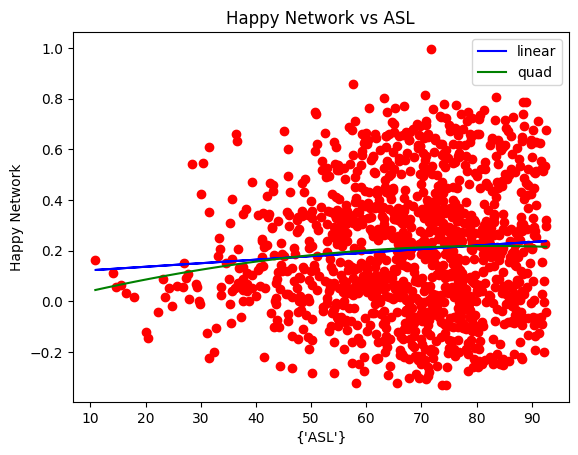

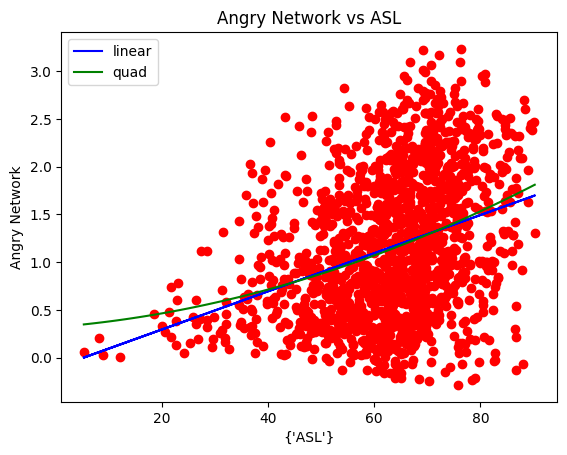

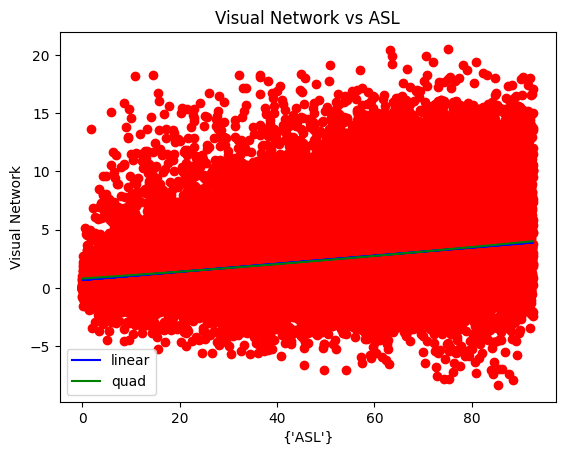

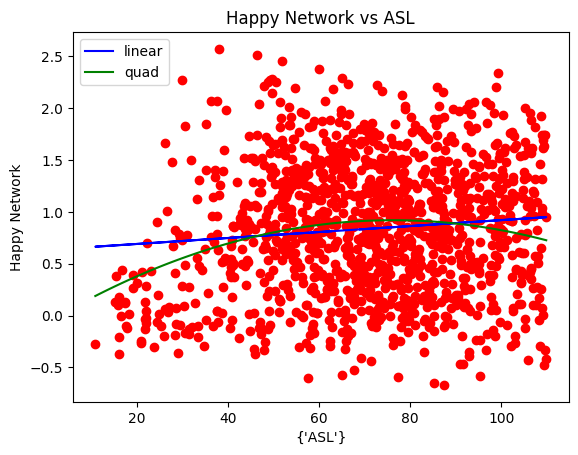

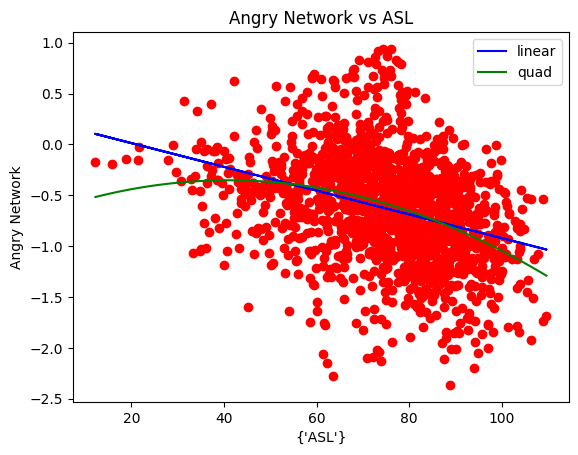

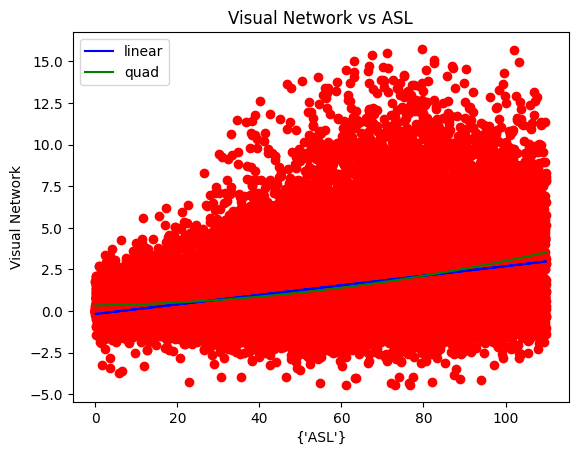

In [13]:
# ASL correlations 

# interictal

[ASLlinH_int,ASLlinA_int,ASLlinV_int,ASLquadH_int,ASLquadA_int,ASLquadV_int] = voxelwise_corrs(neurowASL_interictal,'ses-interictal','ASL')

# preictal

[ASLlinH_preict,ASLlinA_preict,ASLlinV_preict,ASLquadH_preict,ASLquadA_preict,ASLquadV_preict] = voxelwise_corrs(neurowASL_preictal,'ses-preictal','ASL')

# ictal 

[ASLlinH_ict,ASLlinA_ict,ASLlinV_ict,ASLquadH_ict,ASLquadA_ict,ASLquadV_ict] = voxelwise_corrs(neurowASL_ictal,'ses-ictal','ASL')

# postictal

[ASLlinH_postict,ASLlinA_postict,ASLlinV_postict,ASLquadH_postict,ASLquadA_postict,ASLquadV_postict] = voxelwise_corrs(neurowASL_postictal,'ses-postictal','ASL')



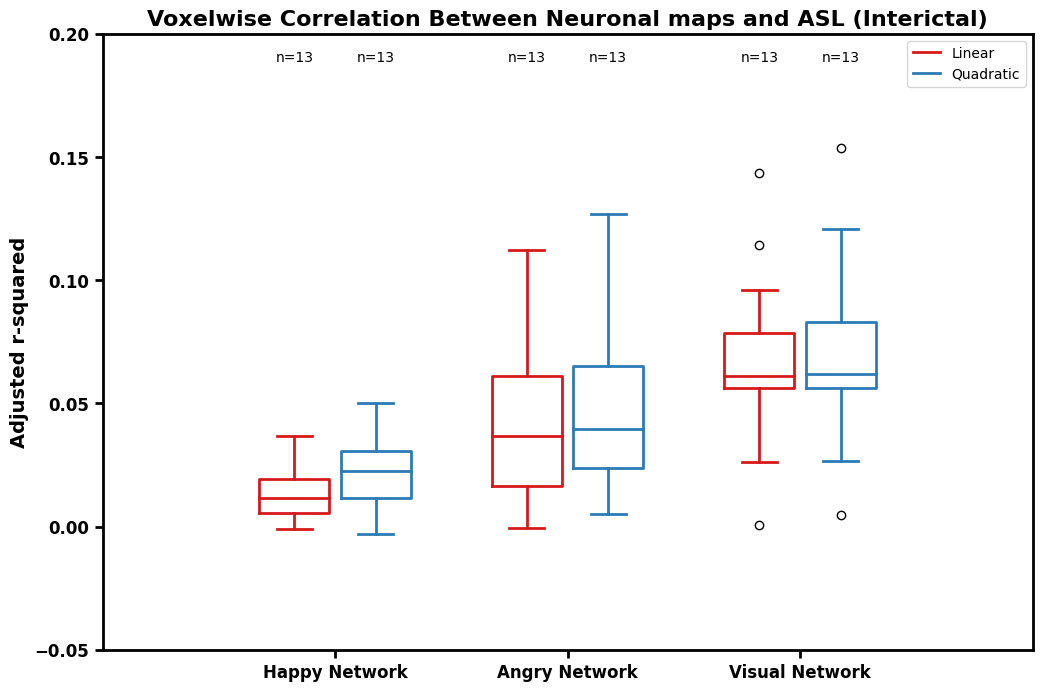

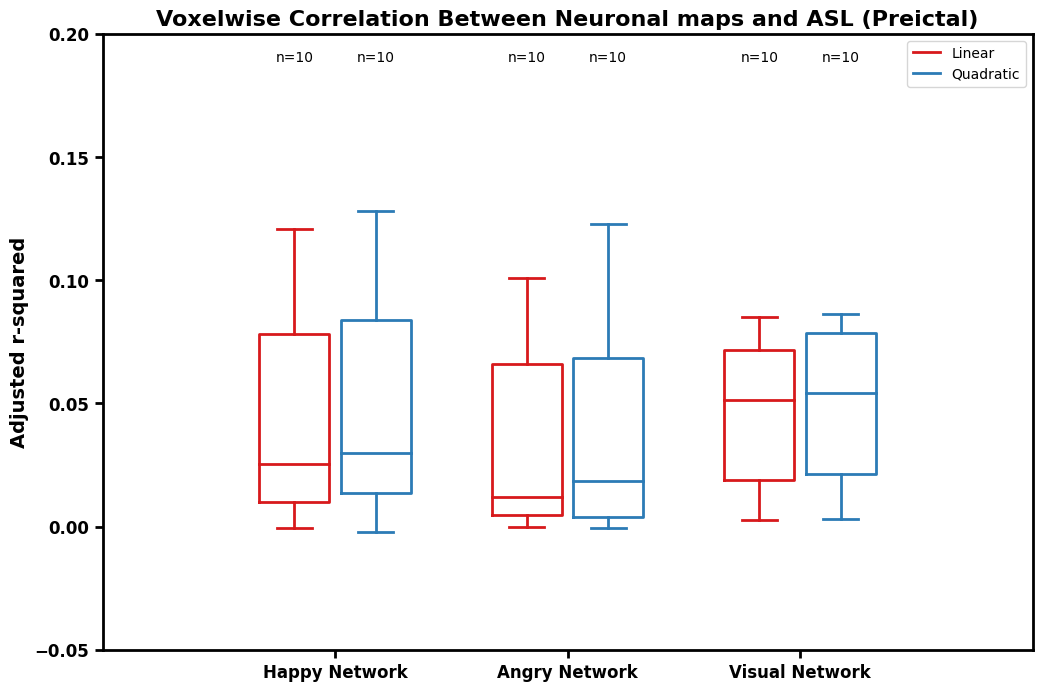

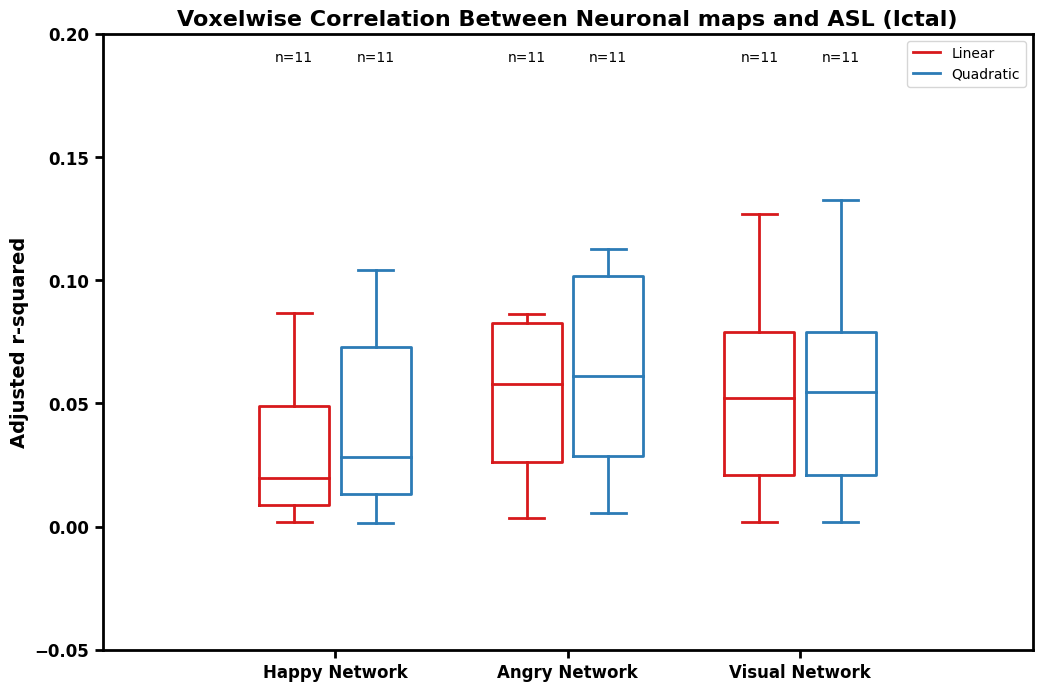

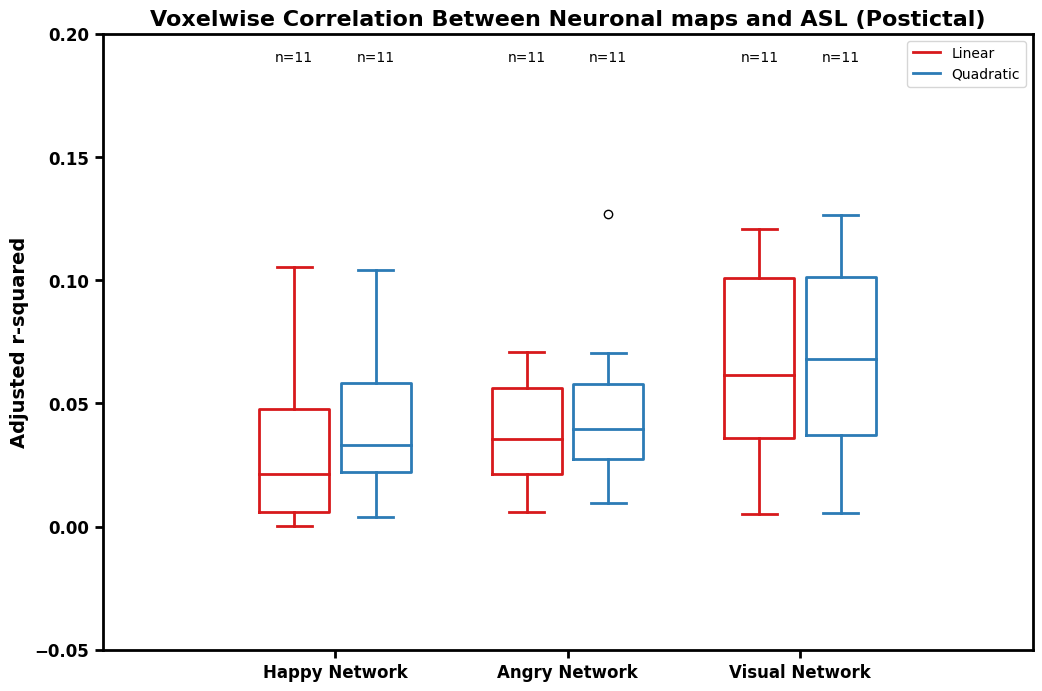

In [14]:
boxplots([ASLlinH_int,ASLlinA_int,ASLlinV_int],[ASLquadH_int,ASLquadA_int,ASLquadV_int],"Interictal","ASL")
boxplots([ASLlinH_preict,ASLlinA_preict,ASLlinV_preict],[ASLquadH_preict,ASLquadA_preict,ASLquadV_preict],"Preictal","ASL")
boxplots([ASLlinH_ict,ASLlinA_ict,ASLlinV_ict],[ASLquadH_ict,ASLquadA_ict,ASLquadV_ict],"Ictal","ASL")
boxplots([ASLlinH_postict,ASLlinA_postict,ASLlinV_postict],[ASLquadH_postict,ASLquadA_postict,ASLquadV_postict],"Postictal","ASL")

#### Polynomial

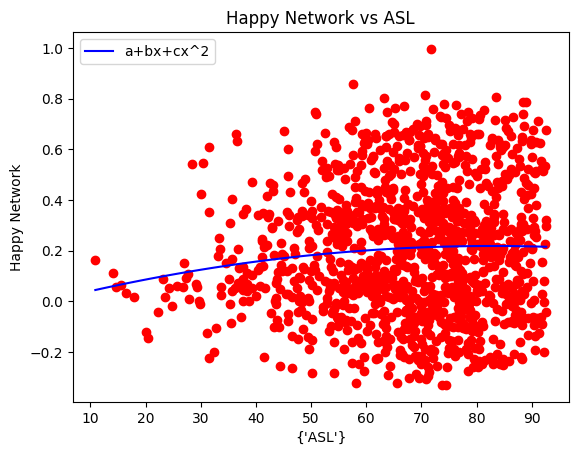

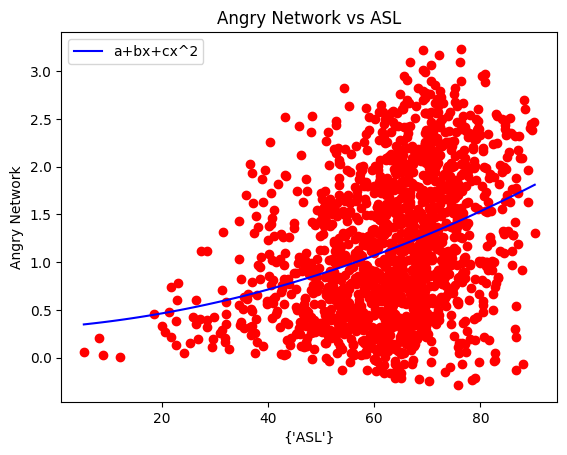

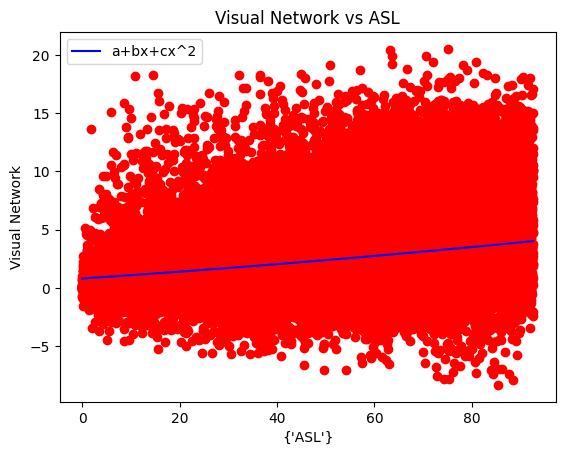

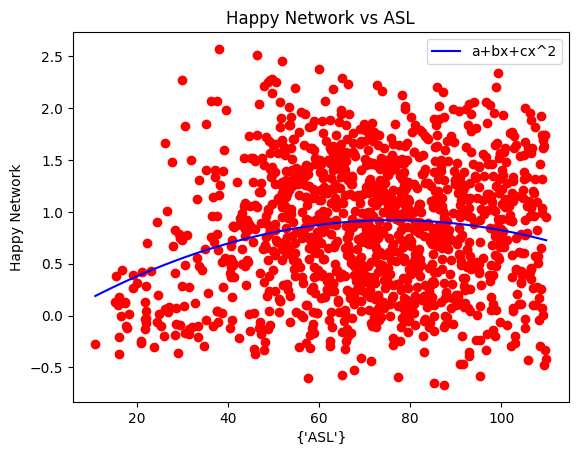

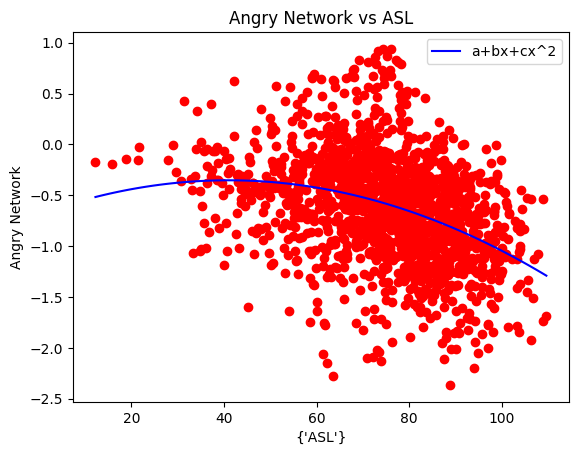

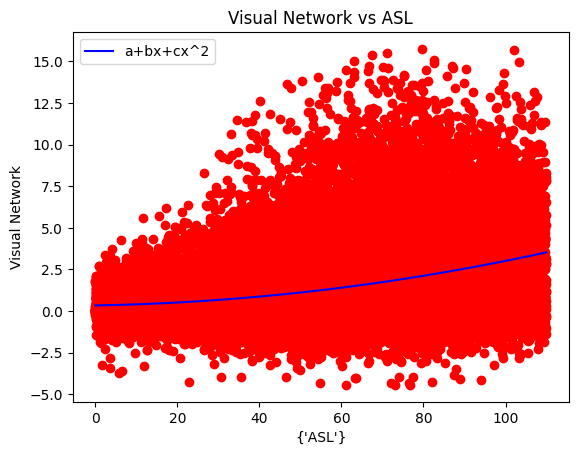

In [15]:
[ASLpolyr2happy_int,ASLpolyr2angry_int,ASLpolyr2vis_int] = voxelwise_corrs_poly(neurowASL_interictal,"ses-interictal","ASL")
[ASLpolyr2happy_preict,ASLpolyr2angry_preict,ASLpolyr2vis_preict] = voxelwise_corrs_poly(neurowASL_preictal,"ses-preictal","ASL")
[ASLpolyr2happy_ict,ASL_polyr2angry_ict, ASL_polyr2vis_ict] = voxelwise_corrs_poly(neurowASL_ictal,"ses-ictal","ASL")
[ASLpolyr2happy_postict,ASpolyr2angry_postict,ASLpolyr2vis_postict] = voxelwise_corrs_poly(neurowASL_postictal,"ses-postictal","ASL")

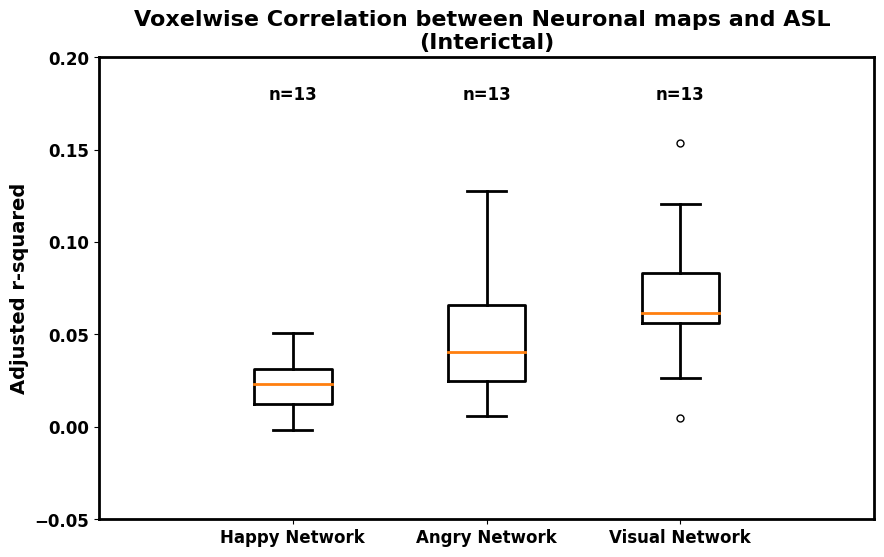

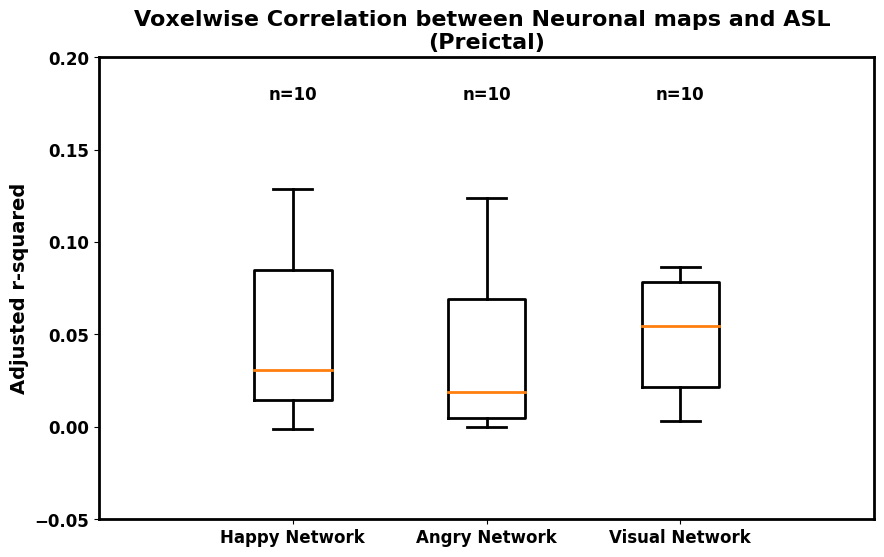

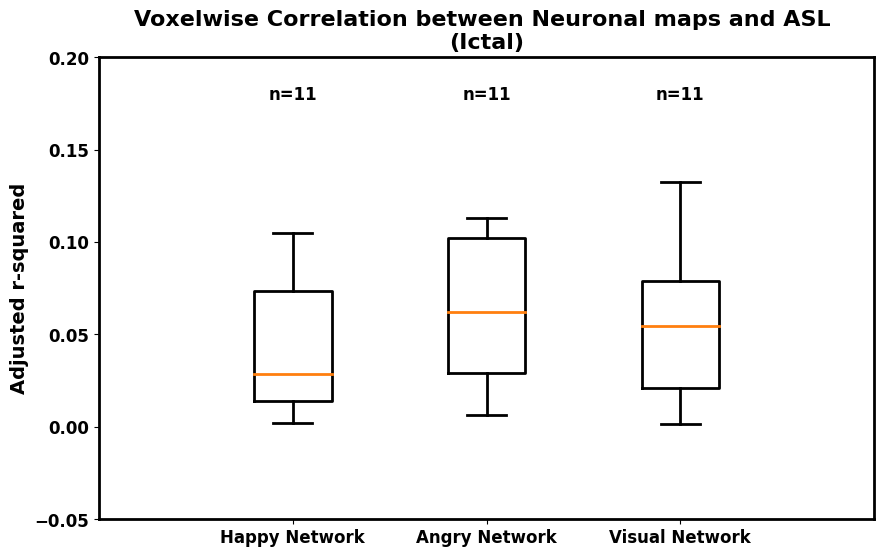

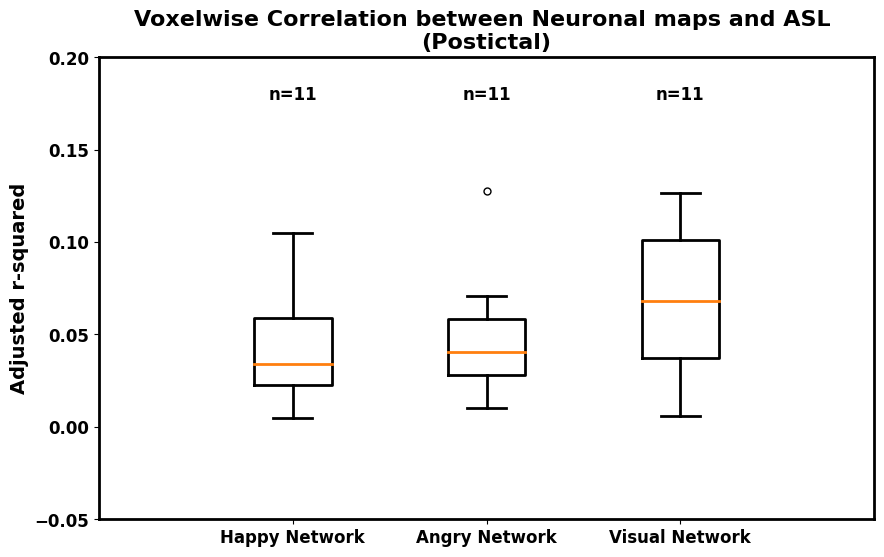

In [16]:
boxplots_poly([ASLpolyr2happy_int,ASLpolyr2angry_int,ASLpolyr2vis_int],"Interictal","ASL")
boxplots_poly([ASLpolyr2happy_preict,ASLpolyr2angry_preict,ASLpolyr2vis_preict],"Preictal","ASL")
boxplots_poly([ASLpolyr2happy_ict,ASL_polyr2angry_ict, ASL_polyr2vis_ict],"Ictal","ASL")
boxplots_poly([ASLpolyr2happy_postict,ASpolyr2angry_postict,ASLpolyr2vis_postict],"Postictal","ASL")

#### Pearson and Spearman

In [17]:
[ASLph_int,ASLpa_int,ASLpv_int,ASLsh_int,ASLsa_int,ASLsv_int] = voxelwise_corrs_pands(neurowASL_interictal,"ses-interictal", "ASL")
[ASLph_preict,ASLpa_preict,ASLpv_preict,ASLsh_preict,ASLsa_preict,ASLsv_preict] = voxelwise_corrs_pands(neurowASL_preictal,"ses-preictal", "ASL")
[ASLph_ict,ASLpa_ict,ASLpv_ict,ASLsh_ict,ASLsa_ict,ASLsv_ict] = voxelwise_corrs_pands(neurowASL_ictal,"ses-ictal", "ASL")
[ASLph_postict,ASLpa_postict,ASLpv_postict,ASLsh_postict,ASLsa_postict,ASLsv_postict] = voxelwise_corrs_pands(neurowASL_postictal,"ses-postictal", "ASL")

ses-interictal p-vals:
 Pearson (H): [0.004758942072923634, 0.0005226377750584052, 2.112100496922138e-11, 0.011514567166226708, 0.6125959117745958, 8.552146799268707e-06, 0.0004867375993942472, 1.050758586010988e-07, 2.1842328352352874e-05, 8.483272723326043e-05, 2.2778495672343744e-07, 0.60251297118586, 1.0789062560605508e-11] 
 Pearson (A): [1.4857681973583082e-40, 2.9716223721333456e-41, 5.722057645951284e-07, 9.919353398892964e-19, 1.4589500832251368e-13, 2.0688692834139003e-14, 2.899727829844162e-14, 0.8139706443873169, 3.5315765763942437e-07, 0.8331619748796355, 1.5933049795729416e-22, 1.247141940757554e-96, 0.0006640143406402701] 
 Pearson (V): [0.0, 0.0, 2.6160338761986535e-303, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9577543330294776e-07, 0.0, 0.0, 0.0] 
 Spearman (H): [0.07005336697658283, 0.013717426760240202, 1.4846135503784566e-09, 0.0773378308709746, 0.05870812346962332, 0.00034464970729679236, 0.04716667594111852, 3.2010780001712e-05, 4.280475647781654e-05, 0.0002409674506958115

### CVR

#### Linear and Quad

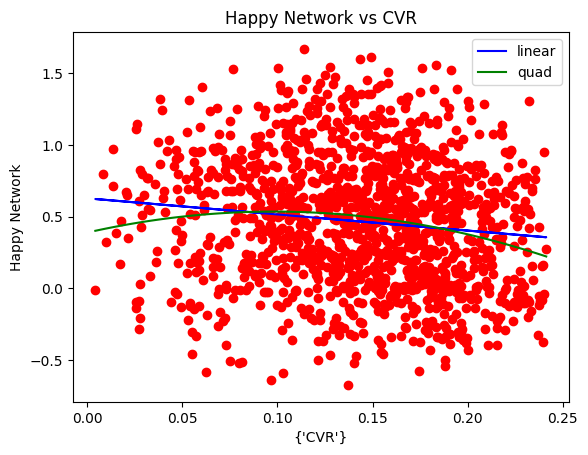

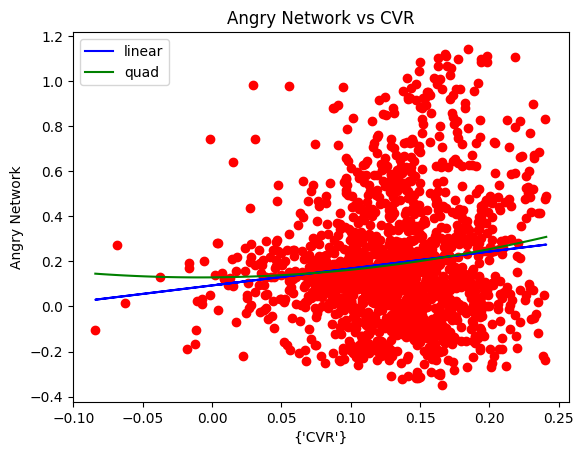

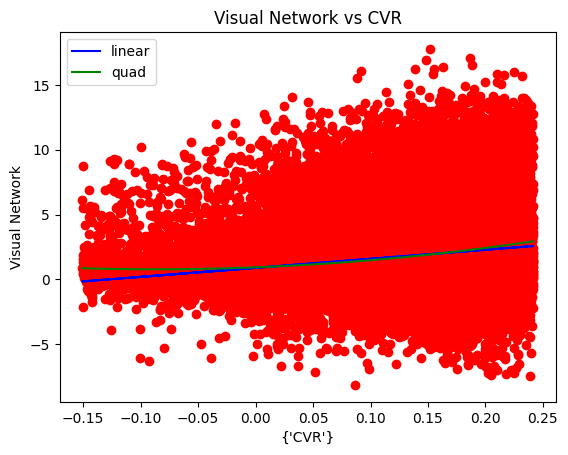

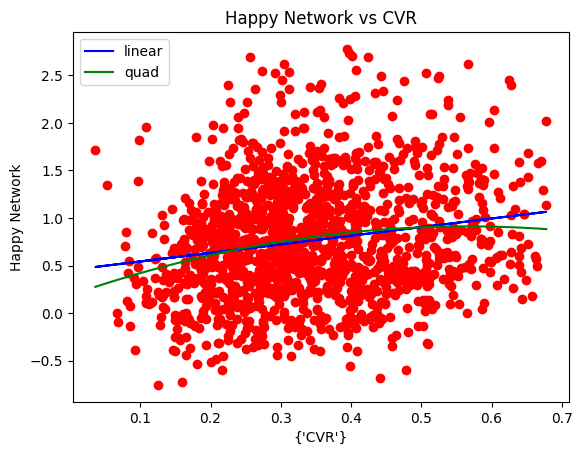

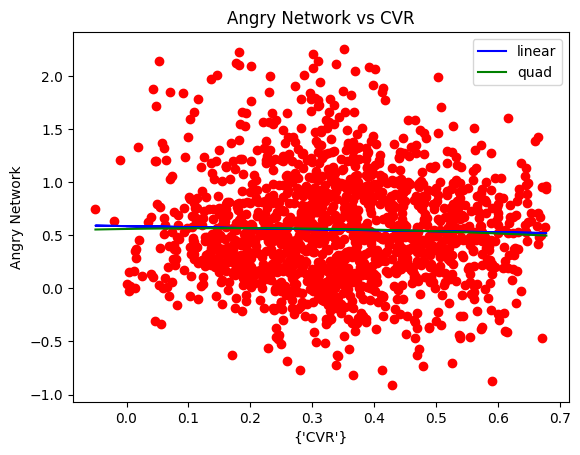

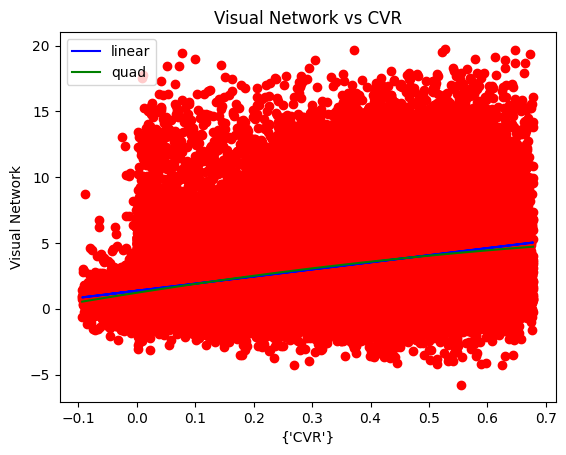

In [18]:
# CVR correlations

# interictal

[CVRlinH_int,CVRlinA_int,CVRlinV_int,CVRquadH_int,CVRquadA_int,CVRquadV_int] = voxelwise_corrs(neurowCVR_interictal,'ses-interictal','CVR')

# preictal

[CVRlinH_preict,CVRlinA_preict,CVRlinV_preict,CVRquadH_preict,CVRquadA_preict,CVRquadV_preict] = voxelwise_corrs(neurowCVR_preictal,'ses-preictal','CVR')

# ictal 

[CVRlinH_ict,CVRlinA_ict,CVRlinV_ict,CVRquadH_ict,CVRquadA_ict,CVRquadV_ict] = voxelwise_corrs(neurowCVR_ictal,'ses-ictal','CVR')

# postictal

[CVRlinH_postict,CVRlinA_postict,CVRlinV_postict,CVRquadH_postict,CVRquadA_postict,CVRquadV_postict] = voxelwise_corrs(neurowCVR_postictal,'ses-postictal','CVR')

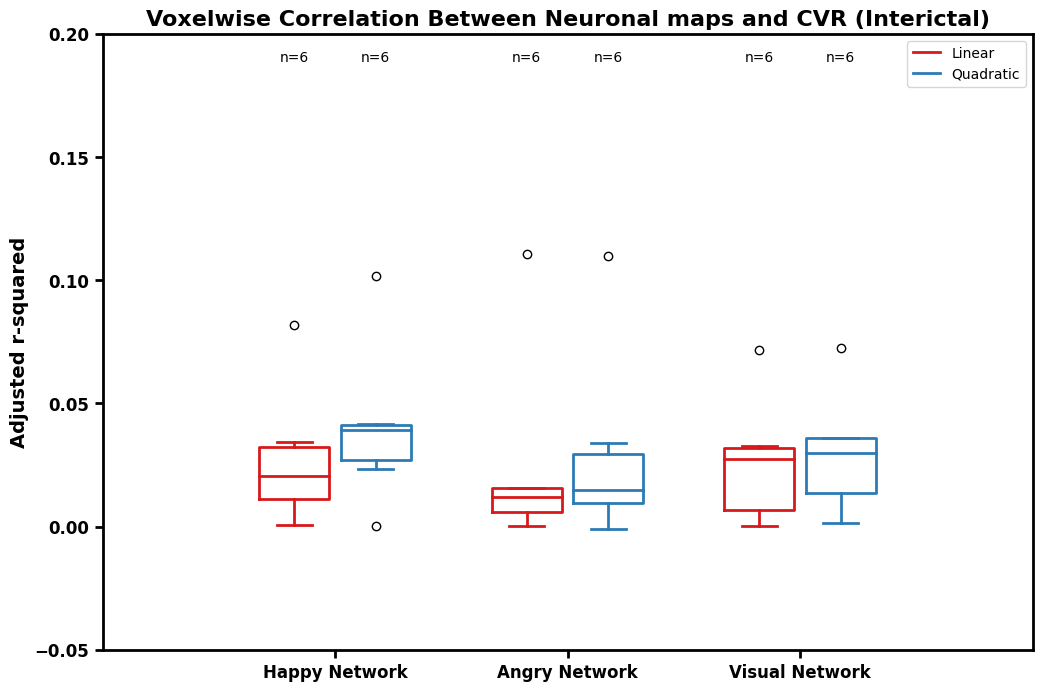

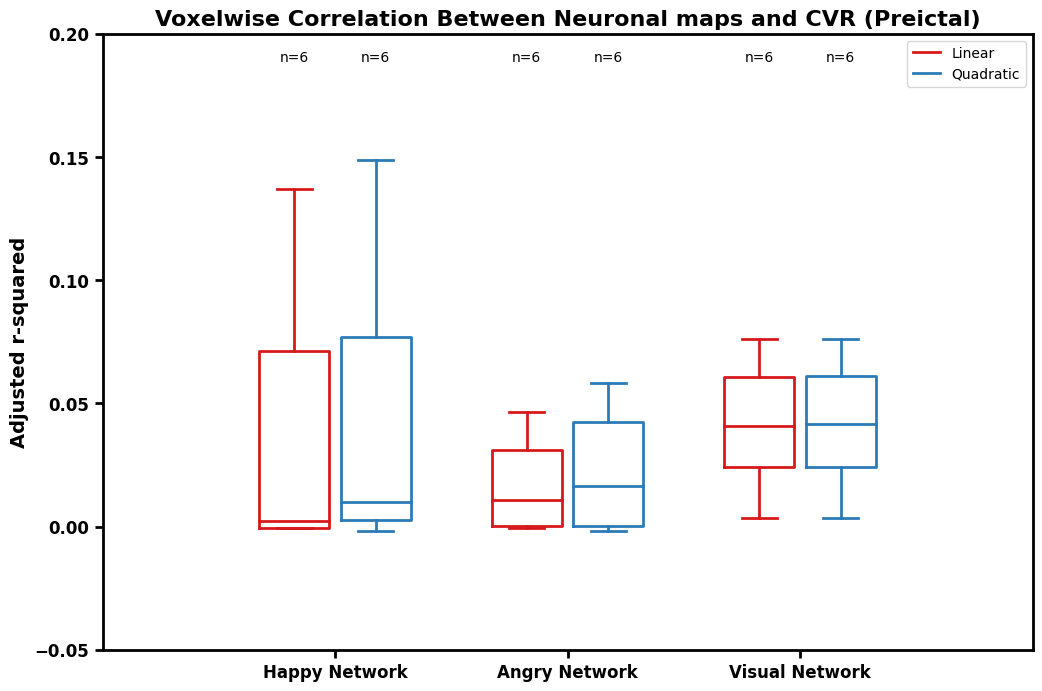

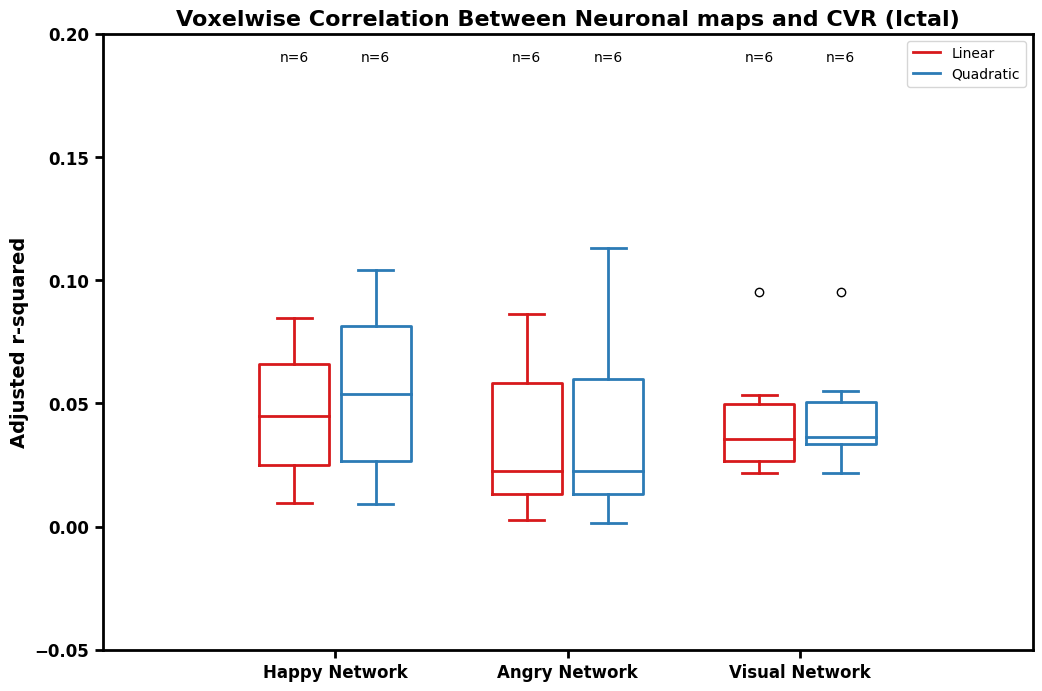

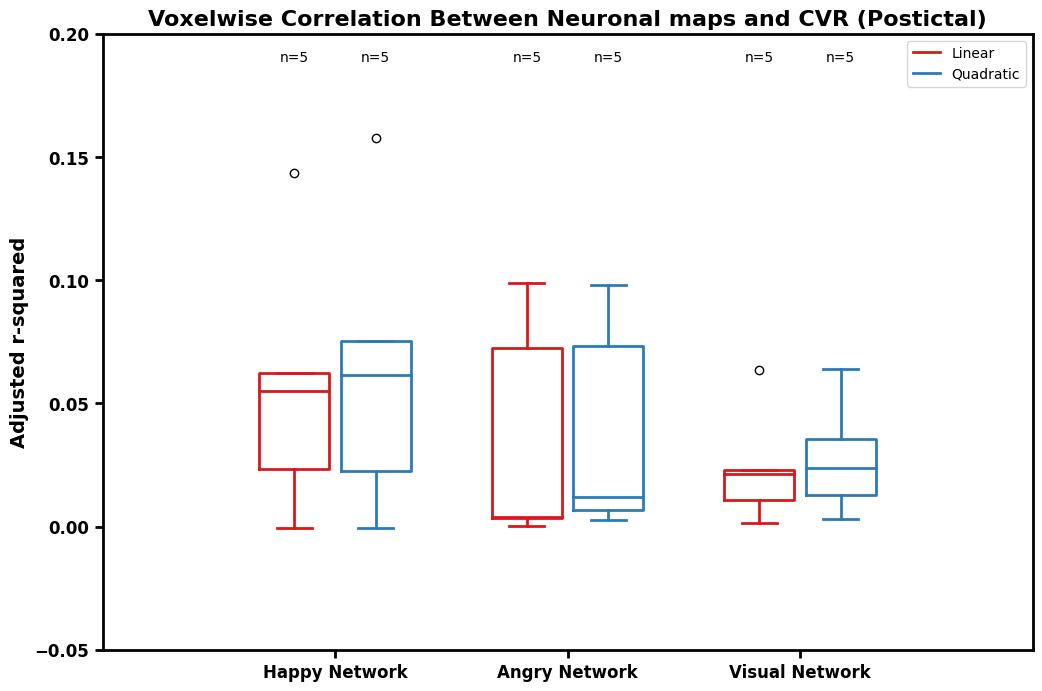

In [19]:
boxplots([CVRlinH_int,CVRlinA_int,CVRlinV_int],[CVRquadH_int,CVRquadA_int,CVRquadV_int],"Interictal","CVR")
boxplots([CVRlinH_preict,CVRlinA_preict,CVRlinV_preict],[CVRquadH_preict,CVRquadA_preict,CVRquadV_preict],"Preictal","CVR")
boxplots([CVRlinH_ict,CVRlinA_ict,CVRlinV_ict],[CVRquadH_ict,CVRquadA_ict,CVRquadV_ict],"Ictal","CVR")
boxplots([CVRlinH_postict,CVRlinA_postict,CVRlinV_postict],[CVRquadH_postict,CVRquadA_postict,CVRquadV_postict],"Postictal","CVR")

#### Polynomial

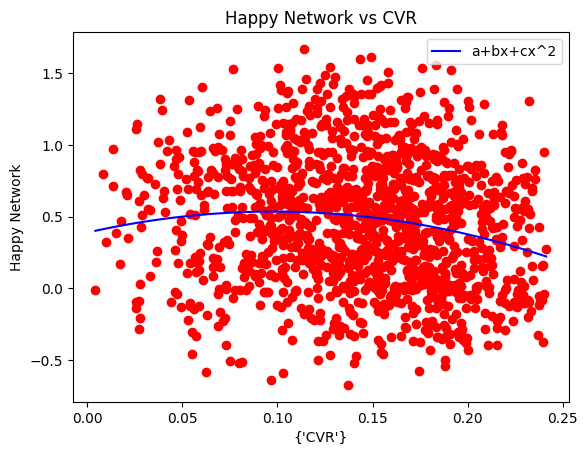

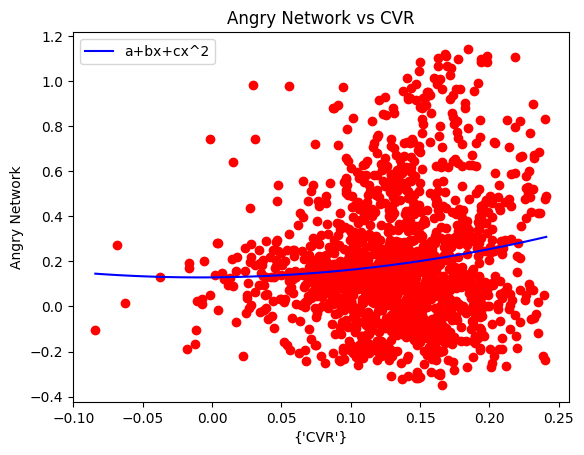

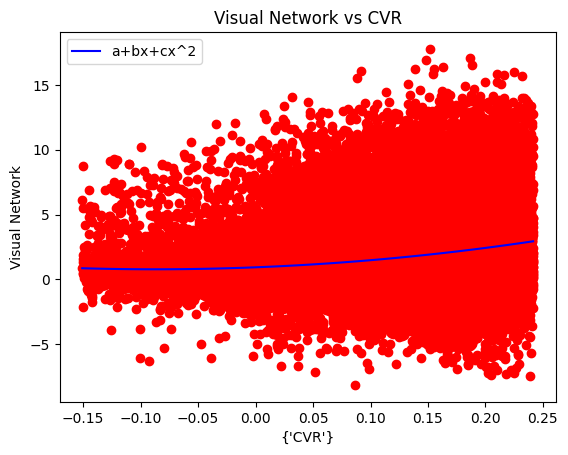

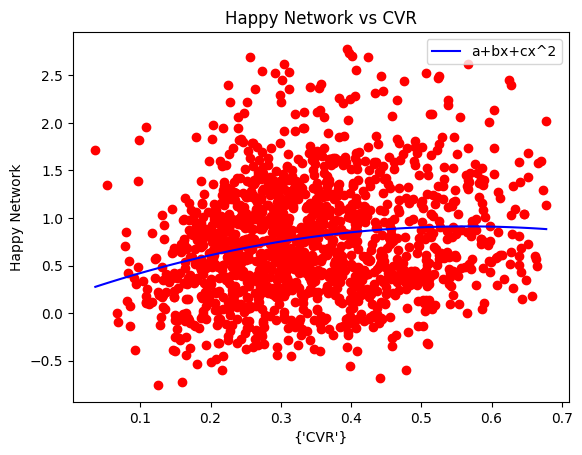

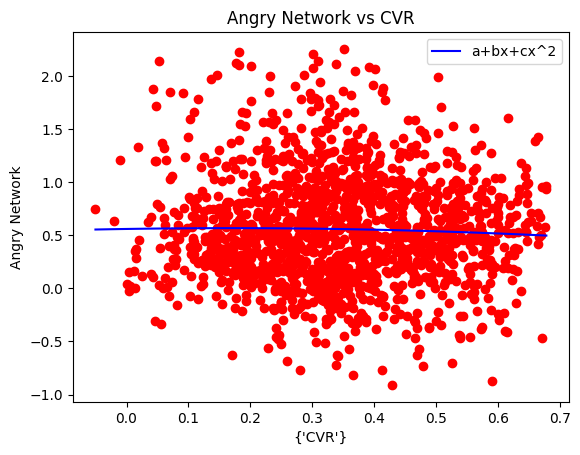

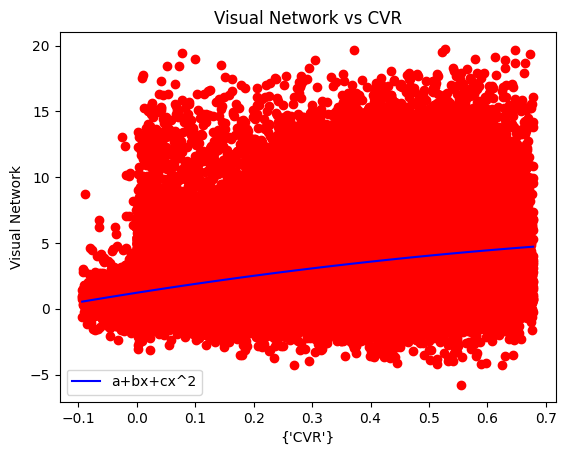

In [20]:
[CVRpolyr2happy_int,CVRpolyr2angry_int,CVRpolyr2vis_int] = voxelwise_corrs_poly(neurowCVR_interictal,"ses-interictal","CVR")
[CVRpolyr2happy_preict,CVRpolyr2angry_preict,CVRpolyr2vis_preict] = voxelwise_corrs_poly(neurowCVR_preictal,"ses-preictal","CVR")
[CVRpolyr2happy_ict,CVRpolyr2angry_ict, CVRpolyr2vis_ict] = voxelwise_corrs_poly(neurowCVR_ictal,"ses-ictal","CVR")
[CVRpolyr2happy_postict,CVRpolyr2angry_postict,CVRpolyr2vis_postict] = voxelwise_corrs_poly(neurowCVR_postictal,"ses-postictal","CVR")

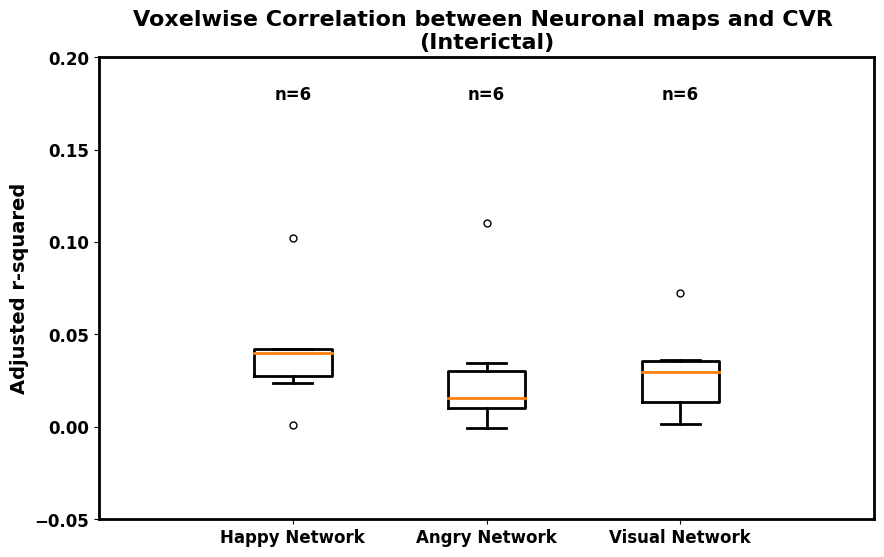

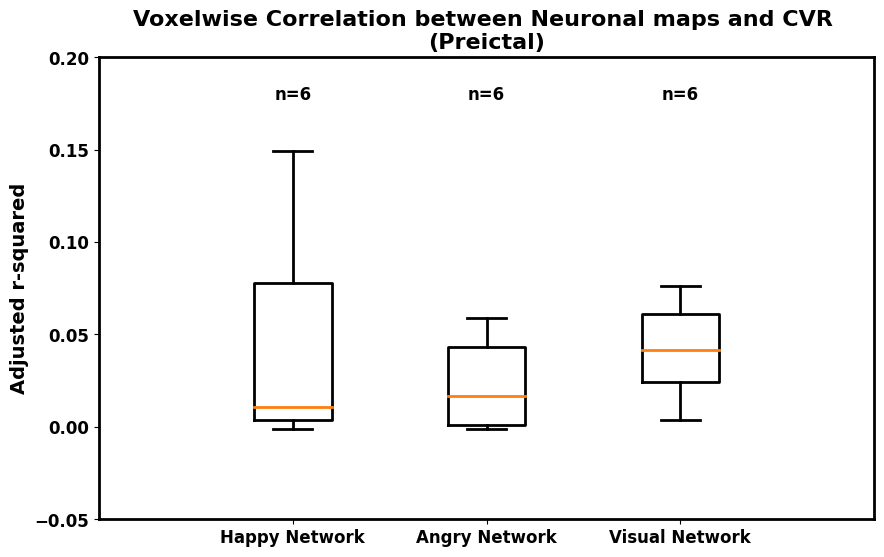

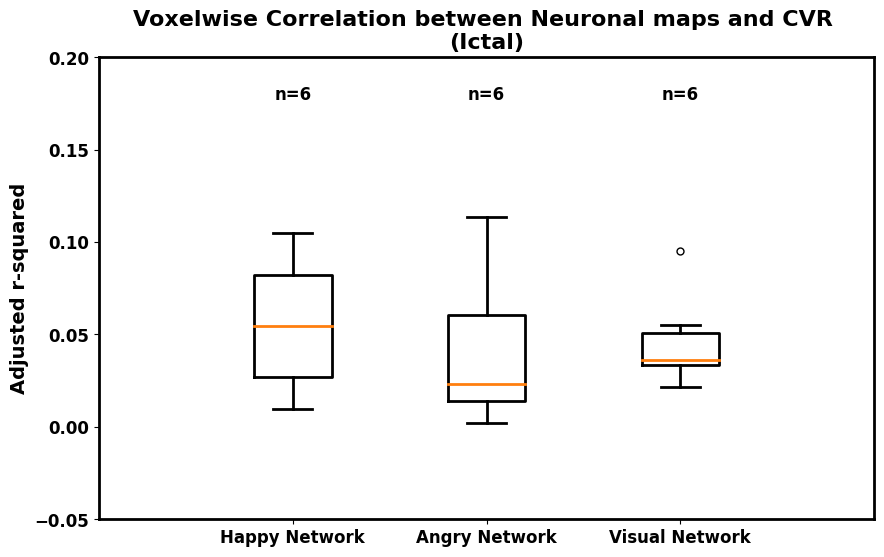

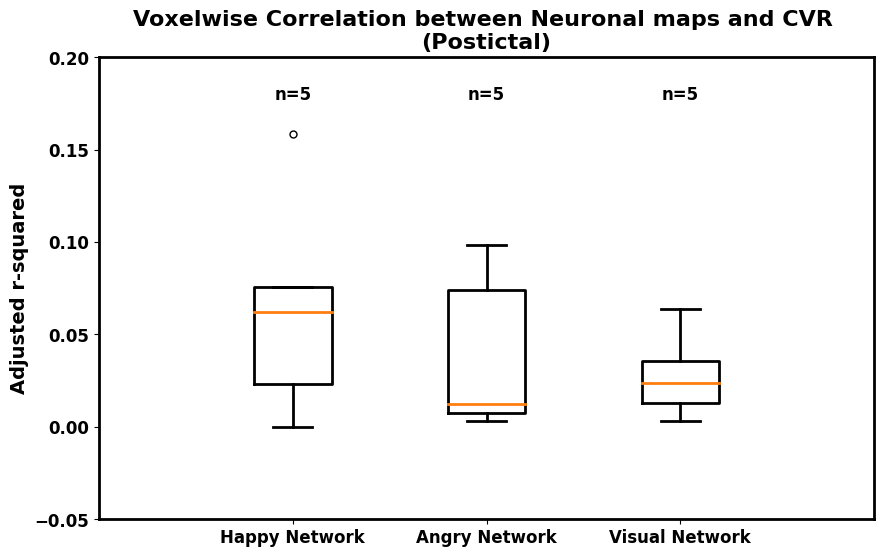

In [21]:
boxplots_poly([CVRpolyr2happy_int,CVRpolyr2angry_int,CVRpolyr2vis_int],"Interictal","CVR")
boxplots_poly([CVRpolyr2happy_preict,CVRpolyr2angry_preict,CVRpolyr2vis_preict],"Preictal","CVR")
boxplots_poly([CVRpolyr2happy_ict,CVRpolyr2angry_ict, CVRpolyr2vis_ict],"Ictal","CVR")
boxplots_poly([CVRpolyr2happy_postict,CVRpolyr2angry_postict,CVRpolyr2vis_postict],"Postictal","CVR")

#### Pearson and Spearman

In [22]:
[CVRph_int,CVRpa_int,CVRpv_int,CVRsh_int,CVRsa_int,CVRsv_int] = voxelwise_corrs_pands(neurowCVR_interictal,"ses-interictal", "CVR")
[CVRph_preict,CVRpa_preict,CVRpv_preict,CVRsh_preict,CVRsa_preict,CVRsv_preict] = voxelwise_corrs_pands(neurowCVR_preictal,"ses-preictal", "CVR")
[CVRph_ict,CVRpa_ict,CVRpv_ict,CVRsh_ict,CVRsa_ict,CVRsv_ict] = voxelwise_corrs_pands(neurowCVR_ictal,"ses-ictal", "CVR")
[CVRph_postict,CVRpa_postict,CVRpv_postict,CVRsh_postict,CVRsa_postict,CVRsv_postict] = voxelwise_corrs_pands(neurowCVR_postictal,"ses-postictal", "CVR")

ses-interictal p-vals:
 Pearson (H): [7.075058976174908e-09, 1.912840931401672e-14, 0.19609821019573045, 1.421561365617305e-09, 0.12741605887978624, 0.00038893920192905733] 
 Pearson (A): [2.0986863606614445e-08, 0.42794825706698925, 2.5101806178886576e-40, 7.154502926935417e-05, 1.933236243047829e-12, 4.344821695127739e-05] 
 Pearson (V): [0.0, 0.0, 2.2299495307590777e-18, 0.0, 1.2501388452607387e-83, 7.7884367e-316] 
 Spearman (H): [2.8430450173930484e-10, 3.167616295501464e-13, 0.8883251642085273, 1.0069356974486613e-13, 0.055335081061655925, 0.0001294591183875103] 
 Spearman (A): [0.0011098427507024945, 0.5145120022548533, 8.215107050541732e-46, 0.0002270679187457711, 8.848140277794591e-13, 0.0014401545136969707] 
 Spearman (V): [3.405340232670255e-246, 0.0, 8.067710495260408e-123, 5.897475131503239e-194, 2.4162751444585554e-53, 0.0])
ses-preictal p-vals:
 Pearson (H): [6.566382963331002e-29, 0.761223784081817, 0.7884731834880508, 1.3354758876299133e-39, 0.18238486127769915, 0.1775

## Controls Correlations

### ASL

#### Linear and Quadratic

In [23]:
controls_midcycle = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control031","sub-control033","sub-control044","sub-control046","sub-control048","sub-control049","sub-control051"]
controls_premens = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control031","sub-control033","sub-control044","sub-control046","sub-control048","sub-control049","sub-control051"]

ASLcontrols_midcycle = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control031","sub-control033","sub-control044","sub-control046","sub-control048","sub-control049","sub-control051"]
ASLcontrols_premens = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control031","sub-control033","sub-control044","sub-control046","sub-control048","sub-control049","sub-control051"]

CVRcontrols_midcycle = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control033","sub-control046","sub-control048","sub-control051"]
CVRcontrols_premens = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control031","sub-control033","sub-control044","sub-control046","sub-control048","sub-control051"]

In [24]:
neurowCVR_midcycle = intersection(controls_midcycle,CVRcontrols_midcycle)
#print(len(neurowCVR_midcycle))
neurowCVR_premens = intersection(controls_premens,CVRcontrols_premens)
#print(len(neurowCVR_premens))

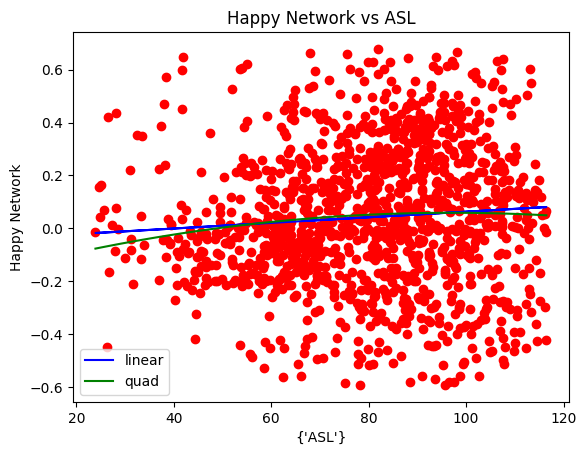

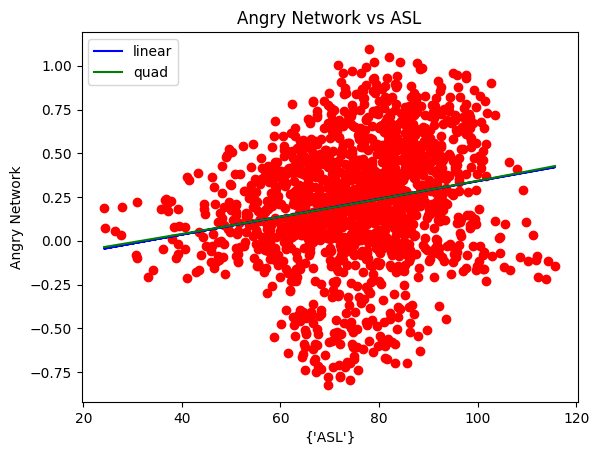

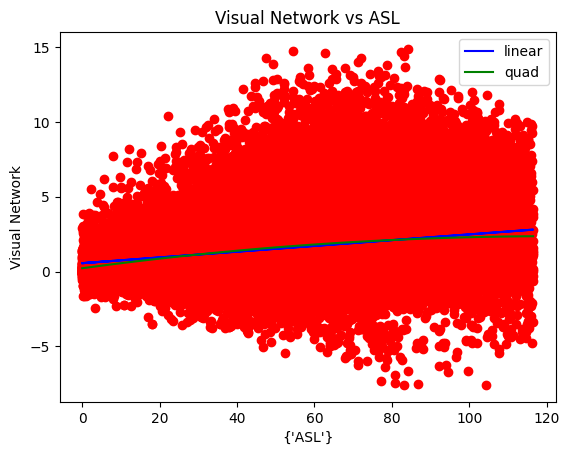

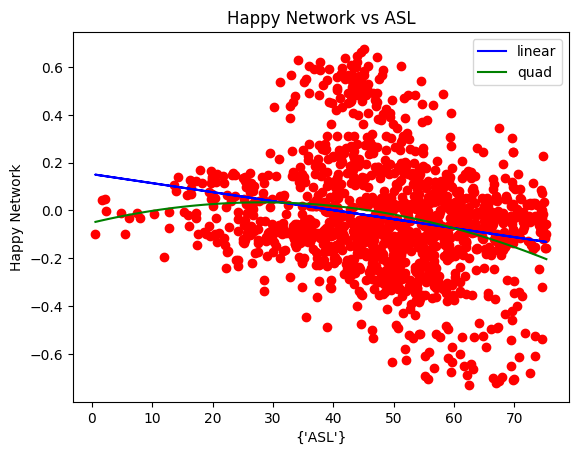

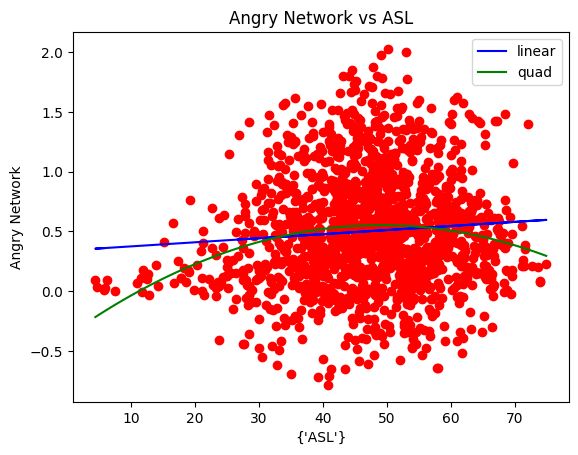

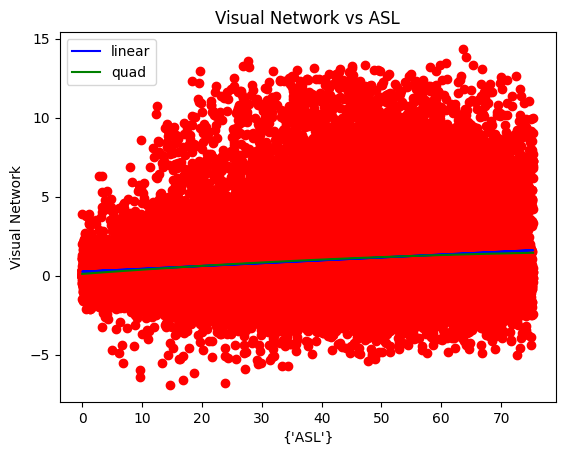

In [25]:
[ASLlinH_mid,ASLlinA_mid,ASLlinV_mid,ASLquadH_mid,ASLquadA_mid,ASLquadV_mid] = voxelwise_corrs(controls_midcycle,'ses-midcycle','ASL')
[ASLlinH_premens,ASLlinA_premens,ASLlinV_premens,ASLquadH_premens,ASLquadA_premens,ASLquadV_premens] = voxelwise_corrs(controls_premens,'ses-premenstrual','ASL')

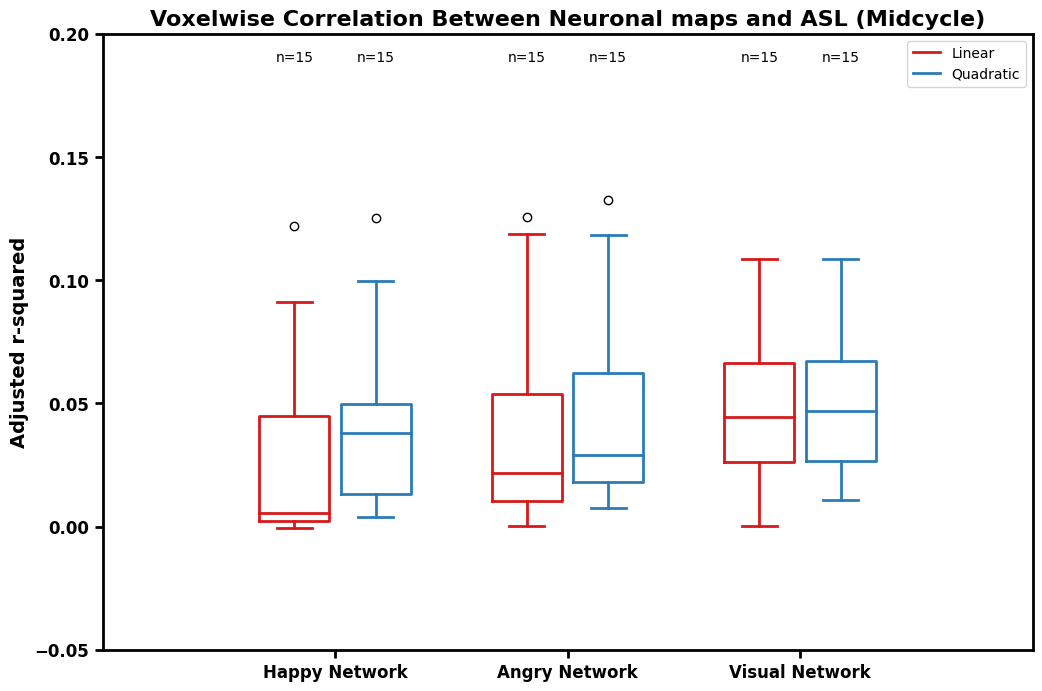

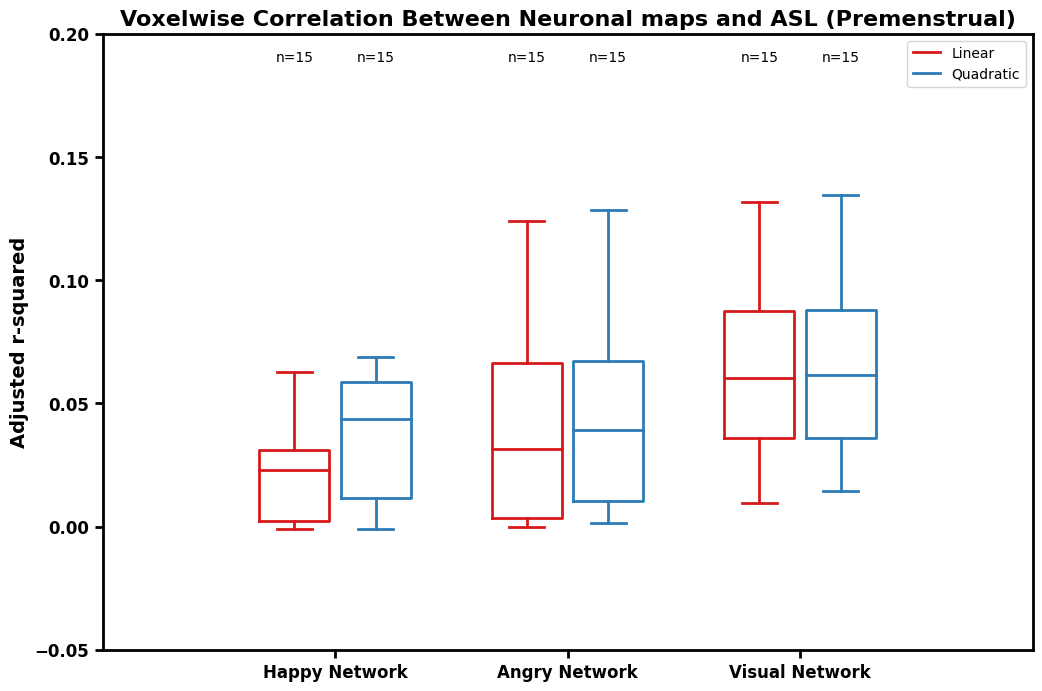

In [26]:
boxplots([ASLlinH_mid,ASLlinA_mid,ASLlinV_mid],[ASLquadH_mid,ASLquadA_mid,ASLquadV_mid],"Midcycle","ASL")
boxplots([ASLlinH_premens,ASLlinA_premens,ASLlinV_premens],[ASLquadH_premens,ASLquadA_premens,ASLquadV_premens],"Premenstrual","ASL")

#### Polynomial

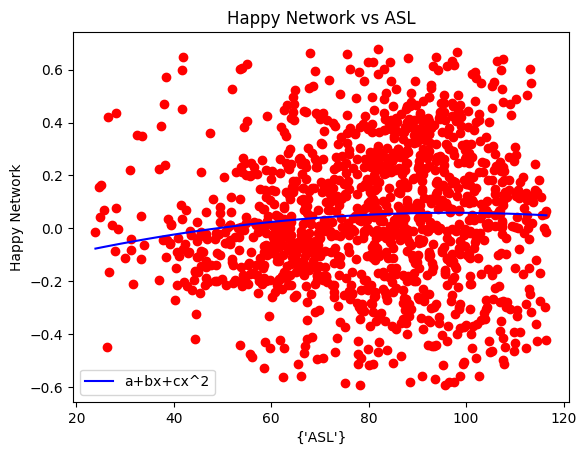

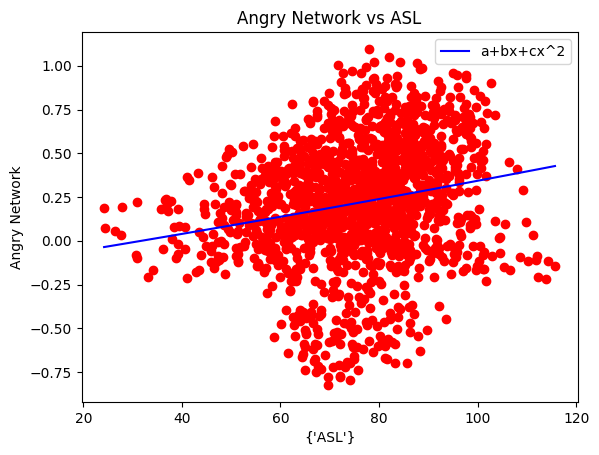

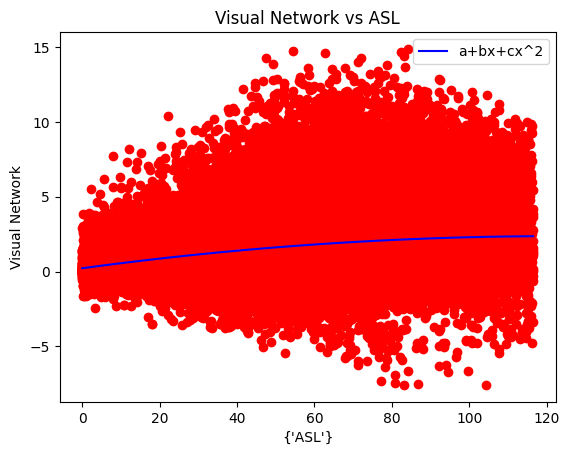

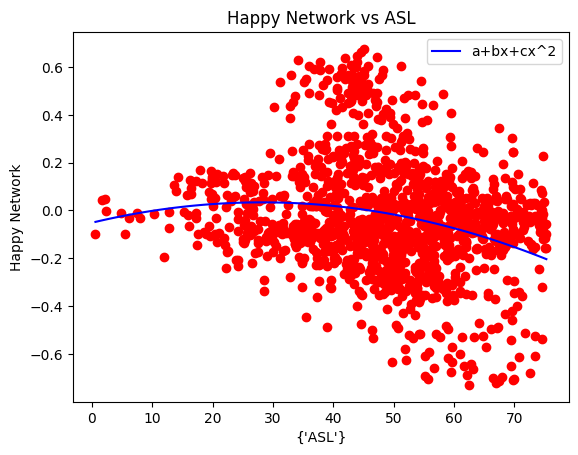

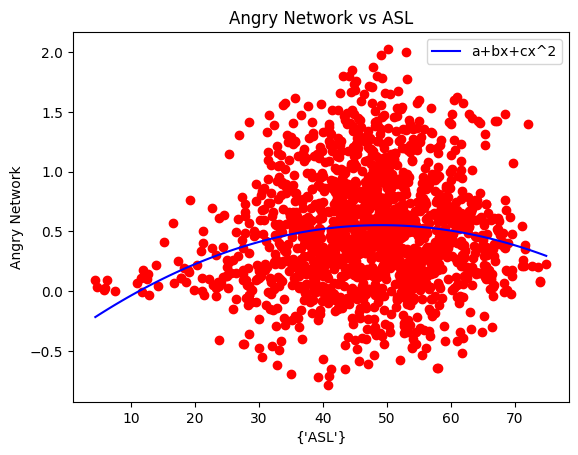

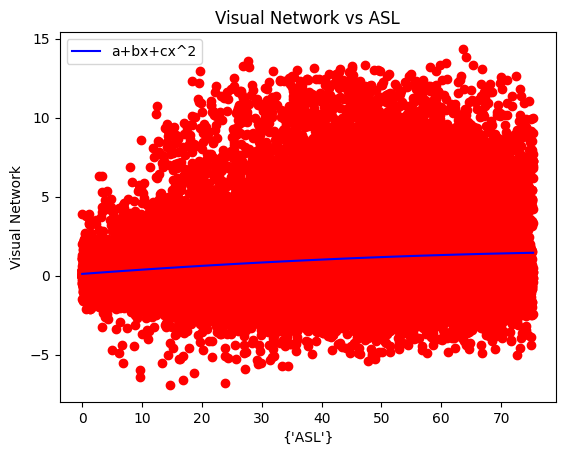

In [27]:
[ASLpolyr2happy_midcycle, ASLpolyr2angry_midcycle, ASLpolyr2vis_midcycle] = voxelwise_corrs_poly(controls_midcycle,"ses-midcycle","ASL")
[ASLpolyr2happy_premens, ASLpolyr2angry_premens, ASLpolyr2vis_premens] = voxelwise_corrs_poly(controls_premens,"ses-premenstrual","ASL")

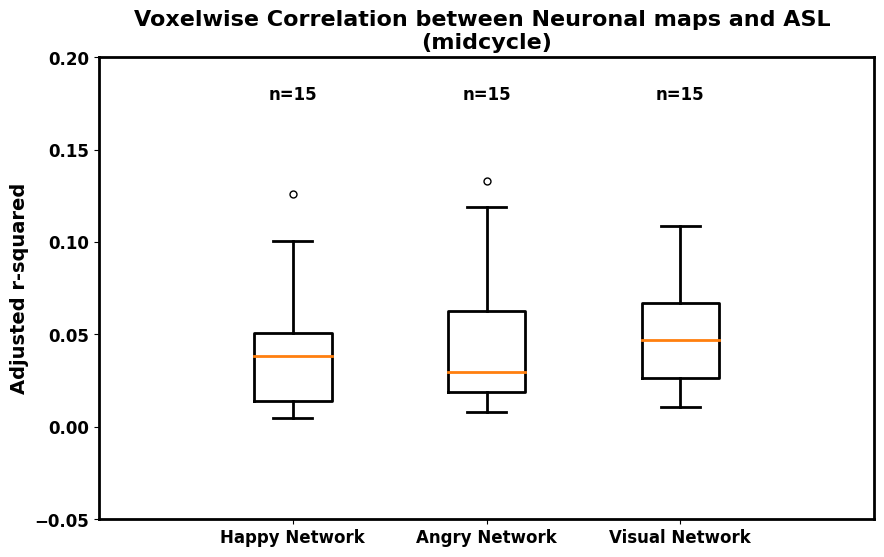

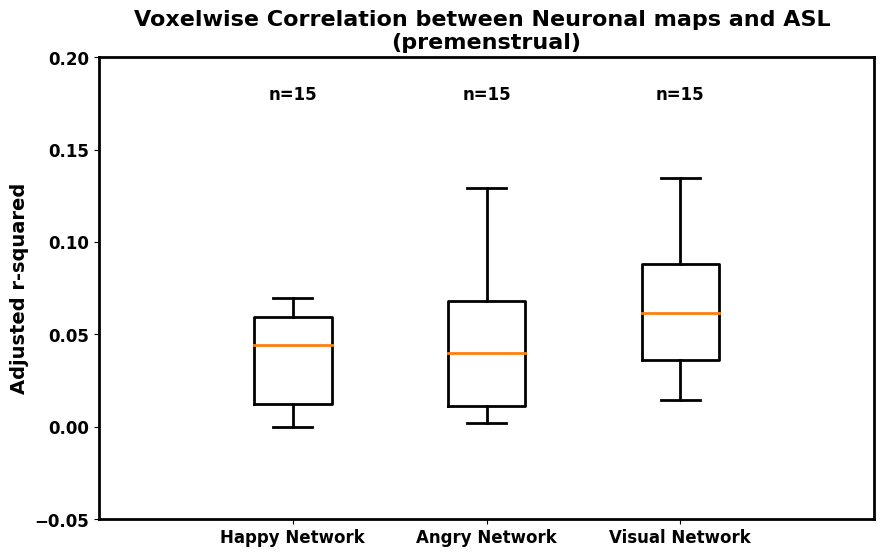

In [28]:
boxplots_poly([ASLpolyr2happy_midcycle,ASLpolyr2angry_midcycle, ASLpolyr2vis_midcycle],"midcycle","ASL")
boxplots_poly([ASLpolyr2happy_premens,ASLpolyr2angry_premens, ASLpolyr2vis_premens],"premenstrual","ASL")

#### Pearson and Spearman

In [29]:
[ASLph_mid,ASLpa_mid,ASLpv_mid,ASLsh_mid,ASLsa_mid,ASLsv_mid] = voxelwise_corrs_pands(ASLcontrols_midcycle,"ses-midcycle","ASL")
[ASLph_premens,ASLpa_premens,ASLpv_premens,ASLsh_premens,ASLsa_premens,ASLsv_premens] = voxelwise_corrs_pands(ASLcontrols_premens,"ses-premenstrual","ASL")

ses-midcycle p-vals:
 Pearson (H): [0.004347430846509283, 8.278672661451235e-15, 3.0219243425569988e-28, 0.003963690549891642, 3.9025075063717056e-10, 1.590163103325909e-05, 2.3292650785635142e-29, 1.5418849726600186e-14, 1.6062701708846988e-35, 0.19256643697798217, 0.5251556211686208, 0.007298461949076653, 0.14365653473418533, 0.020532867021055168, 0.25732492758392317] 
 Pearson (A): [4.617859666348433e-16, 0.0016724237836699904, 1.1009110772946069e-18, 9.551005797449828e-22, 3.937169565945449e-16, 3.4771334414852995e-26, 1.1258650644559226e-43, 2.5093420384914446e-08, 0.0005365332218504942, 6.597023406812302e-08, 2.079053297516281e-46, 0.0056170565194298945, 4.669632310379561e-09, 0.28653439322118346, 7.261980022136248e-06] 
 Pearson (V): [0.0, 5.787696561401592e-224, 8.722179136442826e-127, 0.0, 0.0, 0.0, 0.0, 5.587770394715791e-192, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0035769991635236638] 
 Spearman (H): [0.00010026874796646831, 1.5094770264939754e-13, 8.68584751889873e-31, 1.703975032

### CVR

#### Linear and Quad

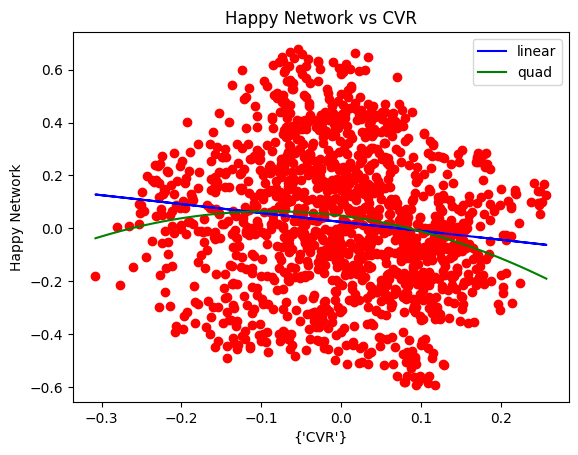

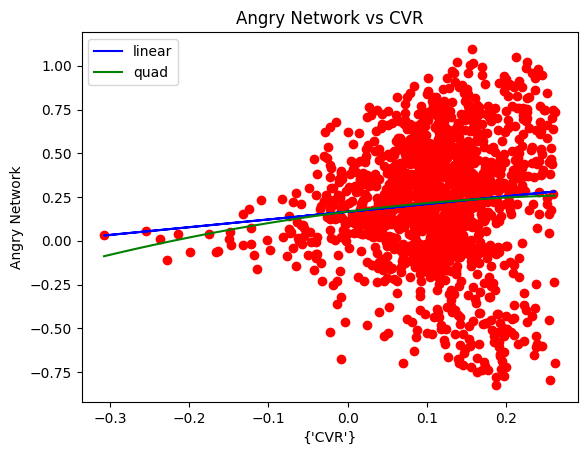

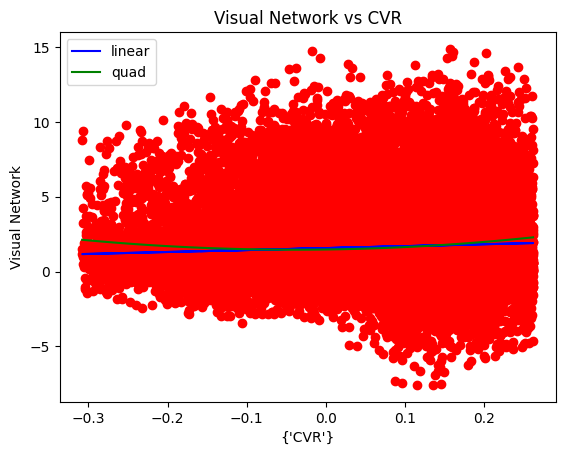

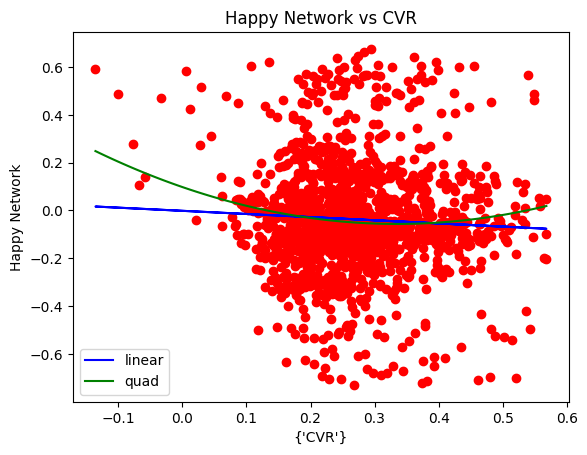

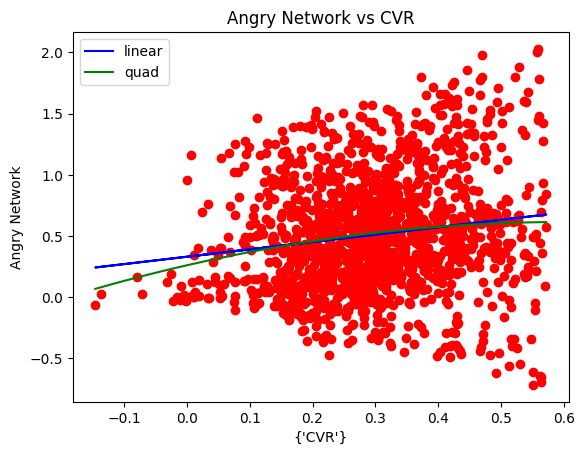

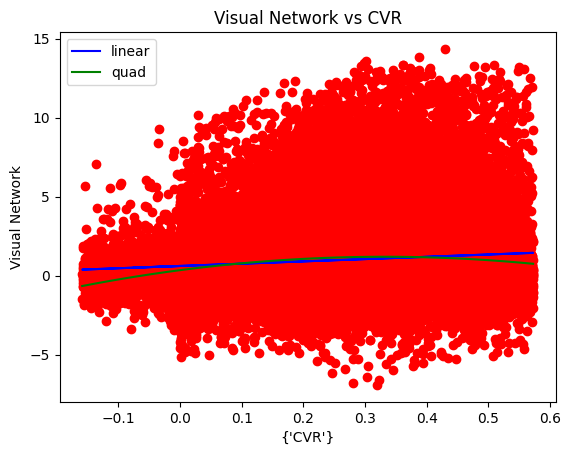

In [30]:
[CVRlinH_mid,CVRlinA_mid,CVRlinV_mid,CVRquadH_mid,CVRquadA_mid,CVRquadV_mid] = voxelwise_corrs(neurowCVR_midcycle,'ses-midcycle','CVR')
[CVRlinH_premens,CVRlinA_premens,CVRlinV_premens,CVRquadH_premens,CVRquadA_premens,CVRquadV_premens] = voxelwise_corrs(neurowCVR_premens,'ses-premenstrual','CVR')

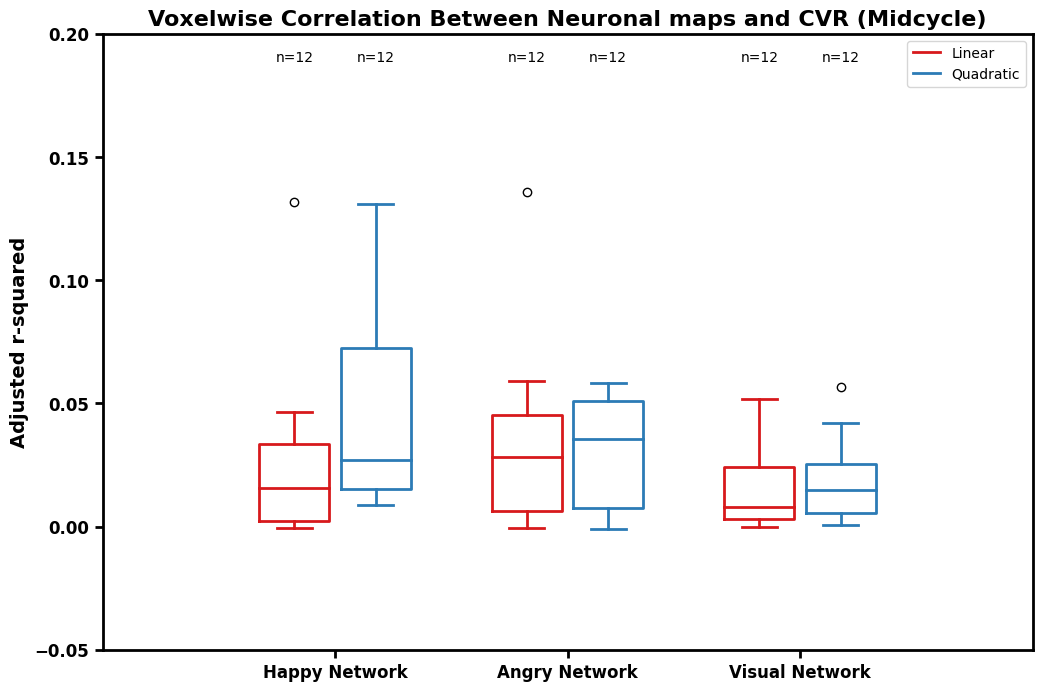

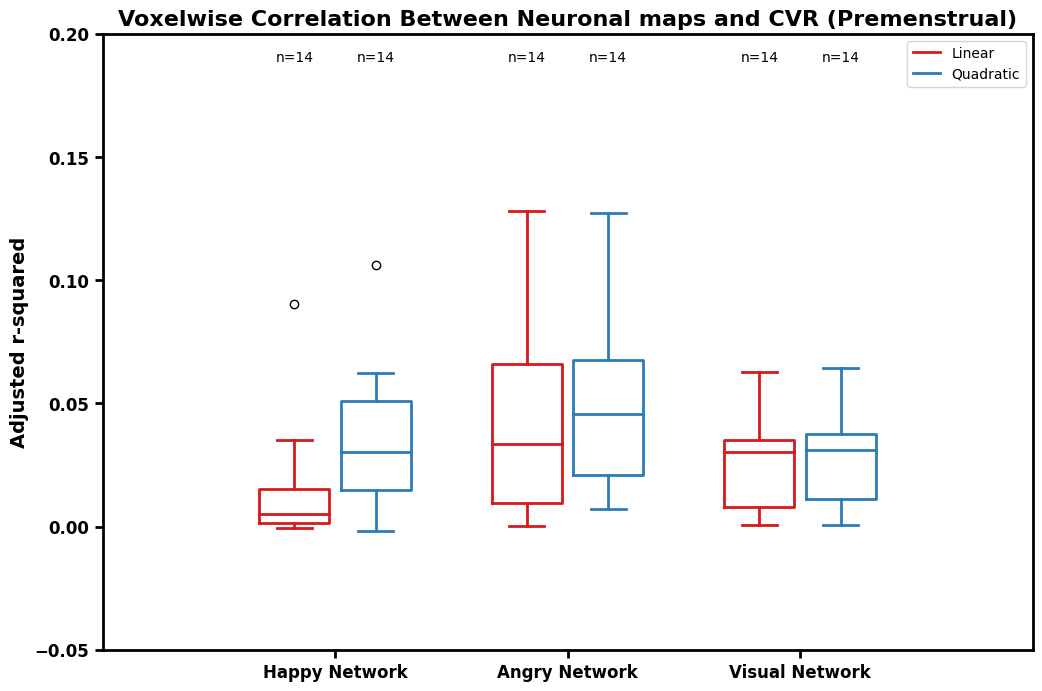

In [31]:
boxplots([CVRlinH_mid,CVRlinA_mid,CVRlinV_mid],[CVRquadH_mid,CVRquadA_mid,CVRquadV_mid],"Midcycle","CVR")
boxplots([CVRlinH_premens,CVRlinA_premens,CVRlinV_premens],[CVRquadH_premens,CVRquadA_premens,CVRquadV_premens],"Premenstrual","CVR")

#### Polynomial

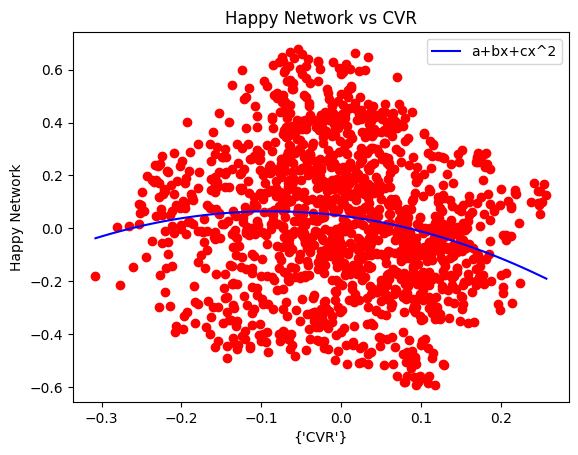

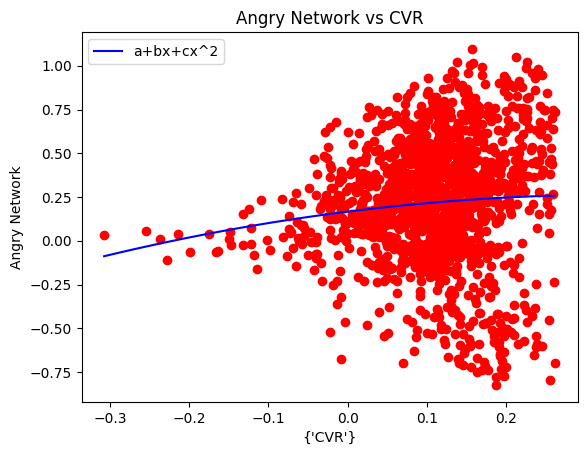

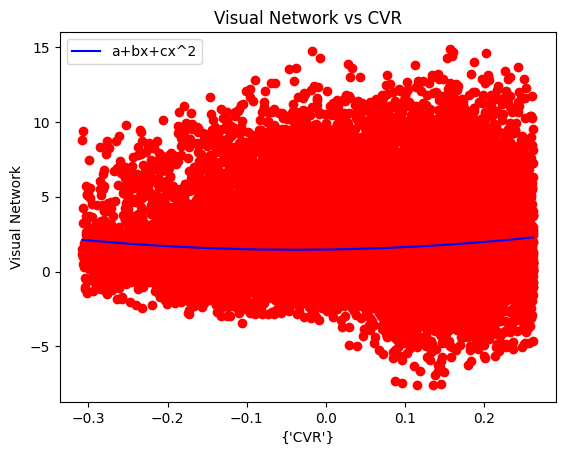

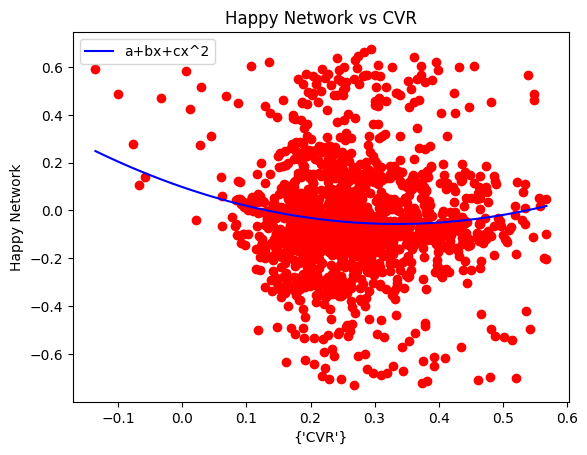

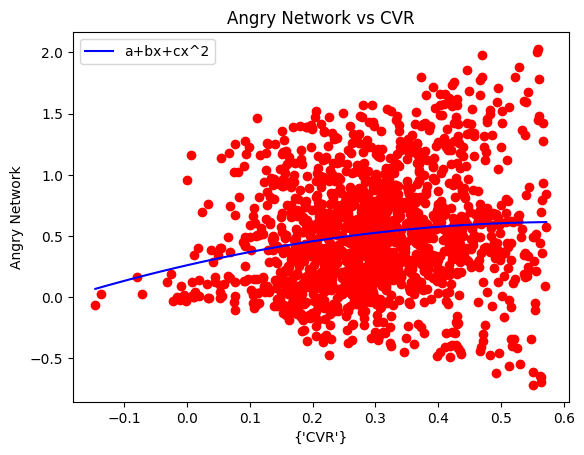

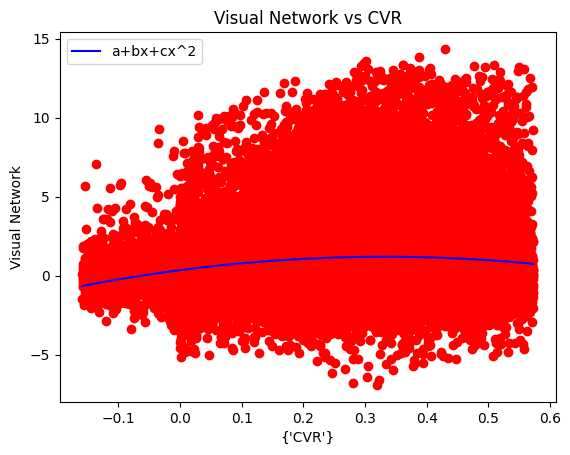

In [32]:
[CVRpolyr2happy_midcycle,CVRpolyr2angry_midcycle, CVRpolyr2vis_midcycle] = voxelwise_corrs_poly(neurowCVR_midcycle,"ses-midcycle","CVR")
[CVRpolyr2happy_premens,CVRpolyr2angry_premens, CVRpolyr2vis_premens] = voxelwise_corrs_poly(neurowCVR_premens,"ses-premenstrual","CVR")

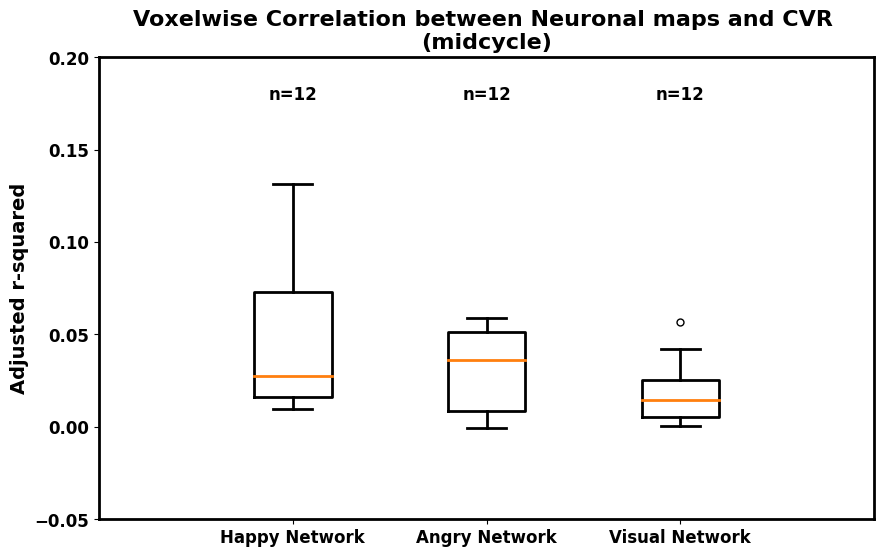

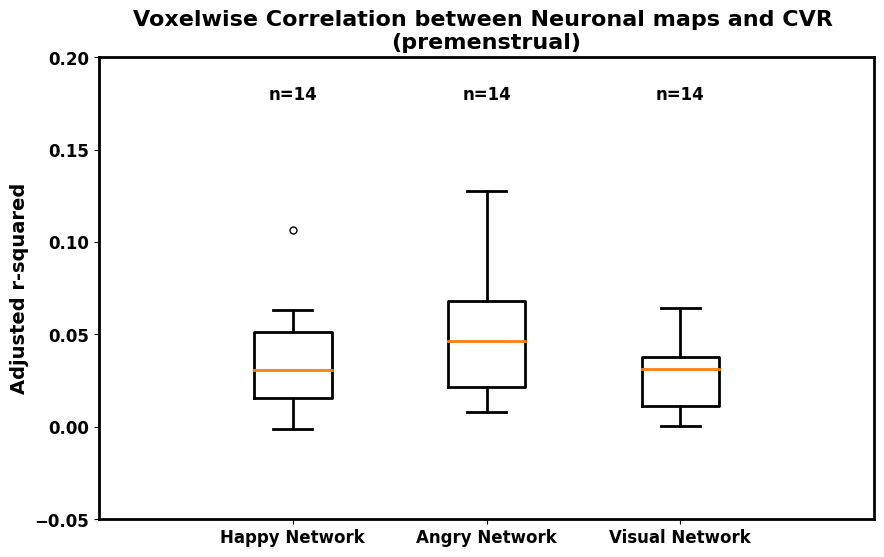

In [33]:
boxplots_poly([CVRpolyr2happy_midcycle,CVRpolyr2angry_midcycle, CVRpolyr2vis_midcycle],"midcycle","CVR")
boxplots_poly([CVRpolyr2happy_premens,CVRpolyr2angry_premens, CVRpolyr2vis_premens],"premenstrual","CVR")

#### Pearson and Spearman

In [34]:
[CVRph_mid,CVRpa_mid,CVRpv_mid,CVRsh_mid,CVRsa_mid,CVRsv_mid] = voxelwise_corrs_pands(neurowCVR_midcycle,"ses-midcycle","CVR")
[CVRph_premens,CVRpa_premens,CVRpv_premens,CVRsh_premens,CVRsa_premens,CVRsv_premens] = voxelwise_corrs_pands(neurowCVR_premens,"ses-premenstrual","CVR")

ses-midcycle p-vals:
 Pearson (H): [1.733509235779072e-05, 0.09064872825585572, 0.002980516910371344, 0.008704459635477065, 0.0003255642802778584, 5.502604270438524e-22, 0.00028852263609165286, 1.4374833628942078e-20, 4.9298244850009084e-05, 0.005253563613342209, 3.2123745844901095e-27, 1.3783047456991497e-05] 
 Pearson (A): [0.15778839259416363, 0.002752587509371005, 0.013170888420240539, 7.21593387829636e-18, 3.954499494591449e-27, 0.004234193141567521, 9.786924295860371e-65, 0.7418866678494725, 0.4765801291008747, 1.6758509413053638e-06, 0.3720400891846239, 3.5548917455721013e-23] 
 Pearson (V): [4.407355524746473e-45, 8.976055299069351e-44, 3.956811211137335e-85, 0.0, 2.9507801057e-314, 2.4060846677710523e-295, 4.5725683320525174e-39, 3.373165317095906e-07, 6.5568278680900615e-158, 1.5381581645597545e-154, 4.308557011074912e-93, 0.0677389101231365] 
 Spearman (H): [2.0101058387128628e-08, 0.3553559736795834, 0.5574064723893821, 0.30720780704787987, 0.0003912167814335601, 2.00231722

## Phases Boxplot

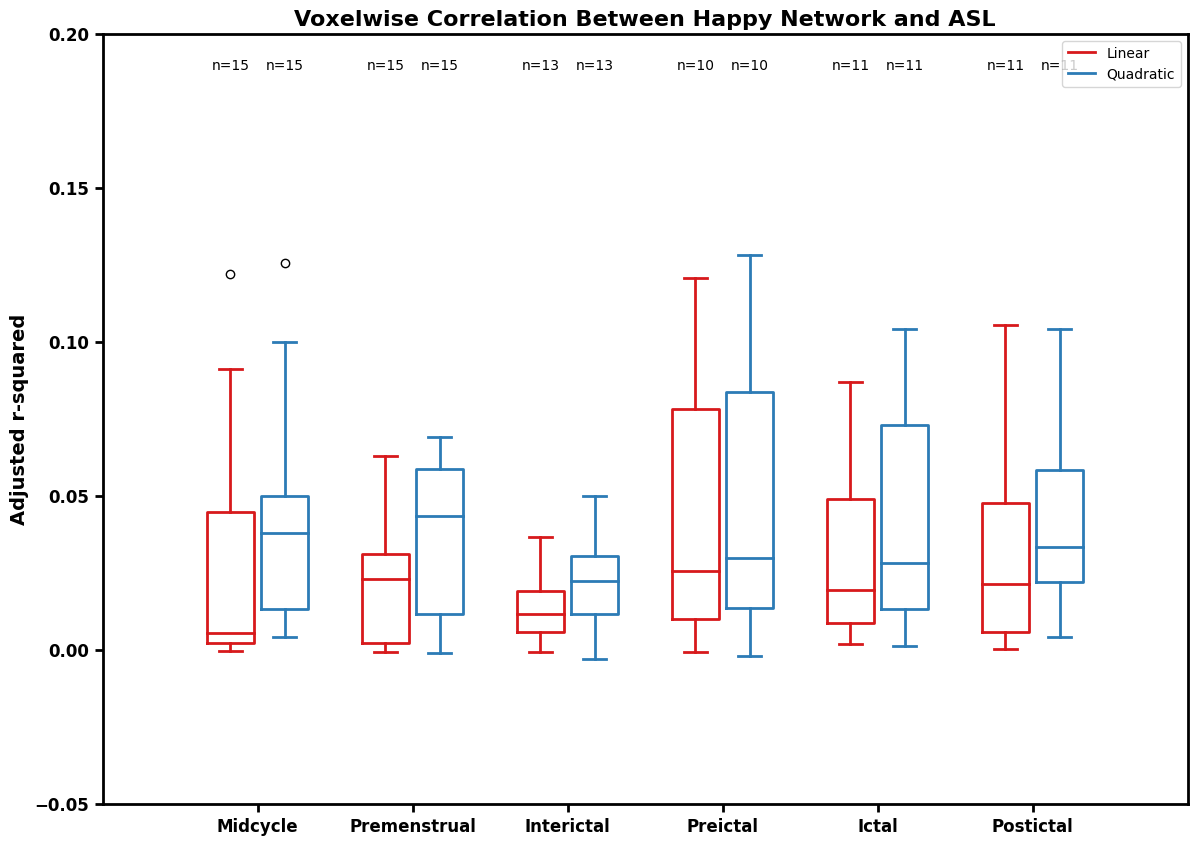

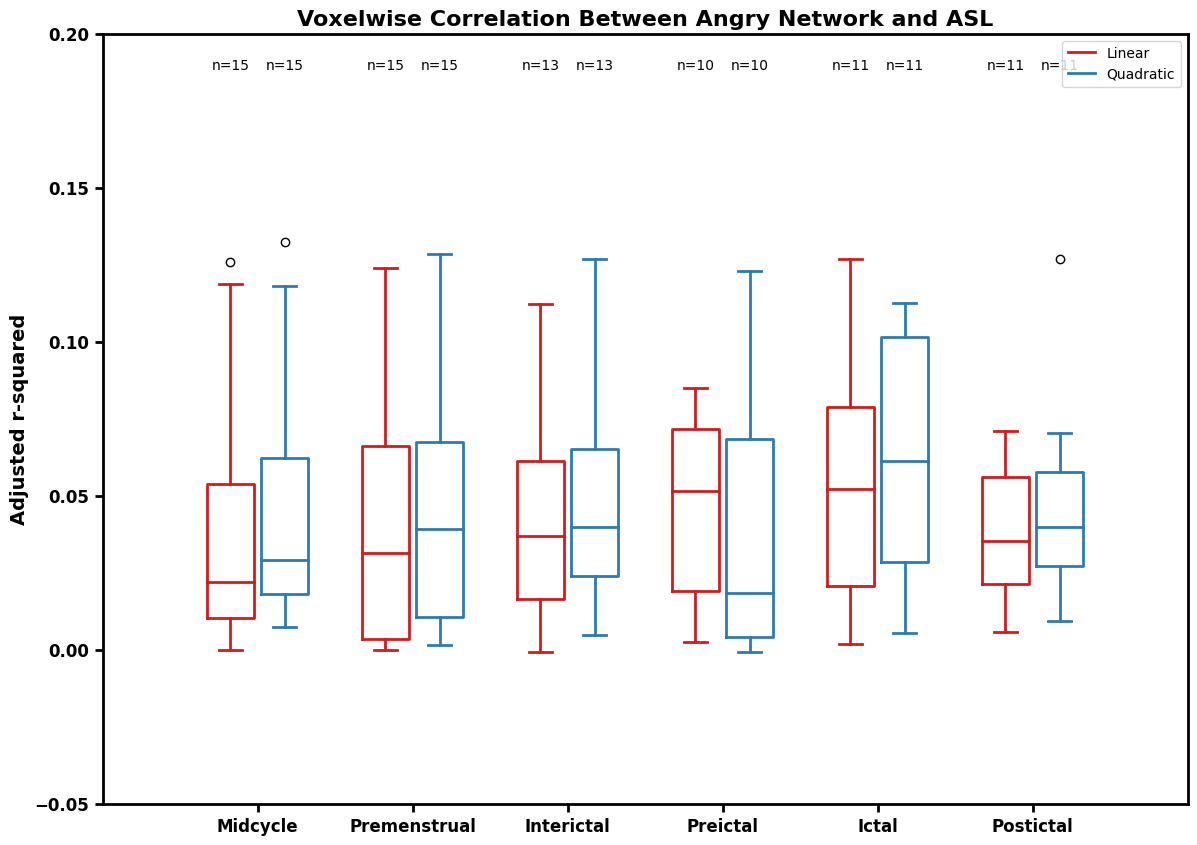

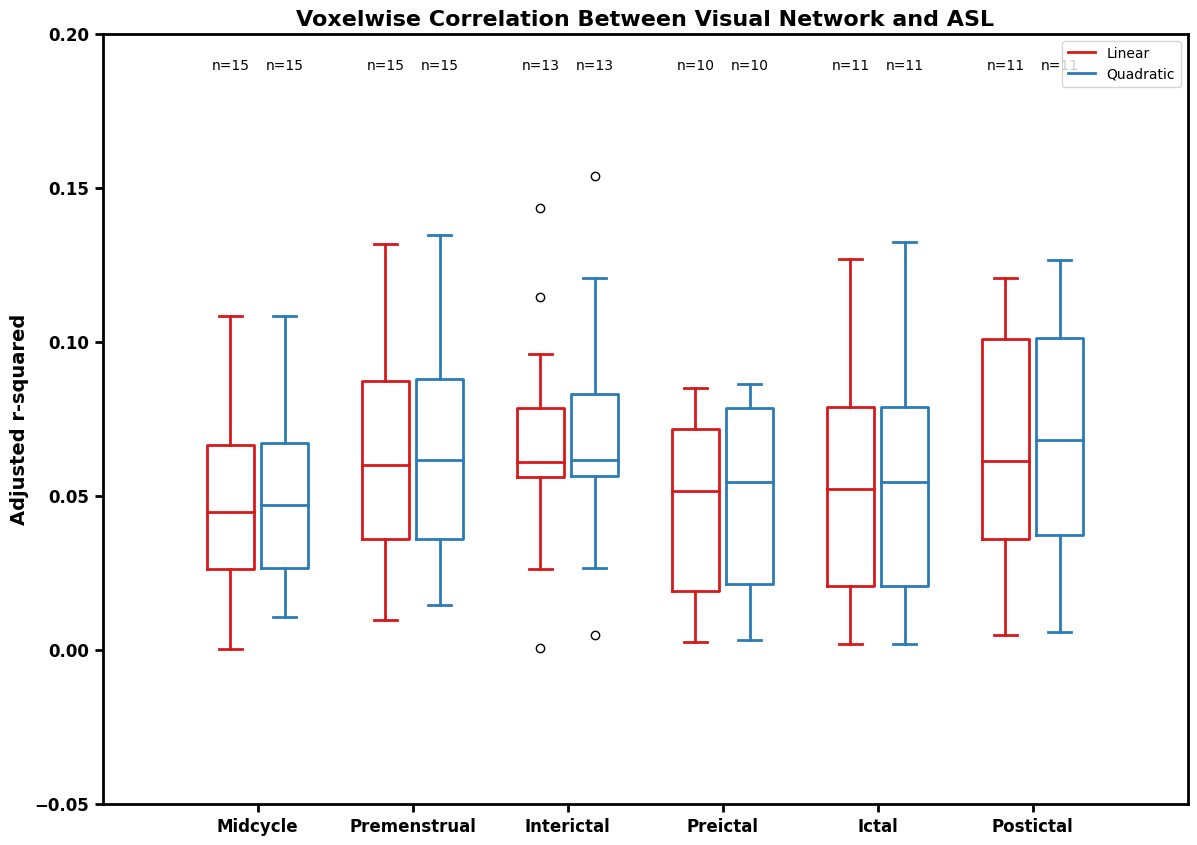

In [35]:
linearplotshappy = [ASLlinH_mid, ASLlinH_premens, ASLlinH_int,ASLlinH_preict,ASLlinH_ict,ASLlinH_postict]
linearplotsangry = [ASLlinA_mid, ASLlinA_premens, ASLlinA_int,ASLlinV_preict,ASLlinV_ict,ASLlinA_postict]
linearplotsvis = [ASLlinV_mid, ASLlinV_premens, ASLlinV_int,ASLlinV_preict,ASLlinV_ict,ASLlinV_postict]

quadplotshappy = [ASLquadH_mid, ASLquadH_premens, ASLquadH_int,ASLquadH_preict, ASLquadH_ict, ASLquadH_postict]
quadplotsangry = [ASLquadA_mid, ASLquadA_premens, ASLquadA_int,ASLquadA_preict, ASLquadA_ict, ASLquadA_postict]
quadplotsvis = [ASLquadV_mid, ASLquadV_premens, ASLquadV_int,ASLquadV_preict, ASLquadV_ict, ASLquadV_postict]

boxplots2(linearplotshappy,quadplotshappy,'Happy Network','ASL')
boxplots2(linearplotsangry,quadplotsangry,"Angry Network","ASL")
boxplots2(linearplotsvis,quadplotsvis,'Visual Network','ASL')

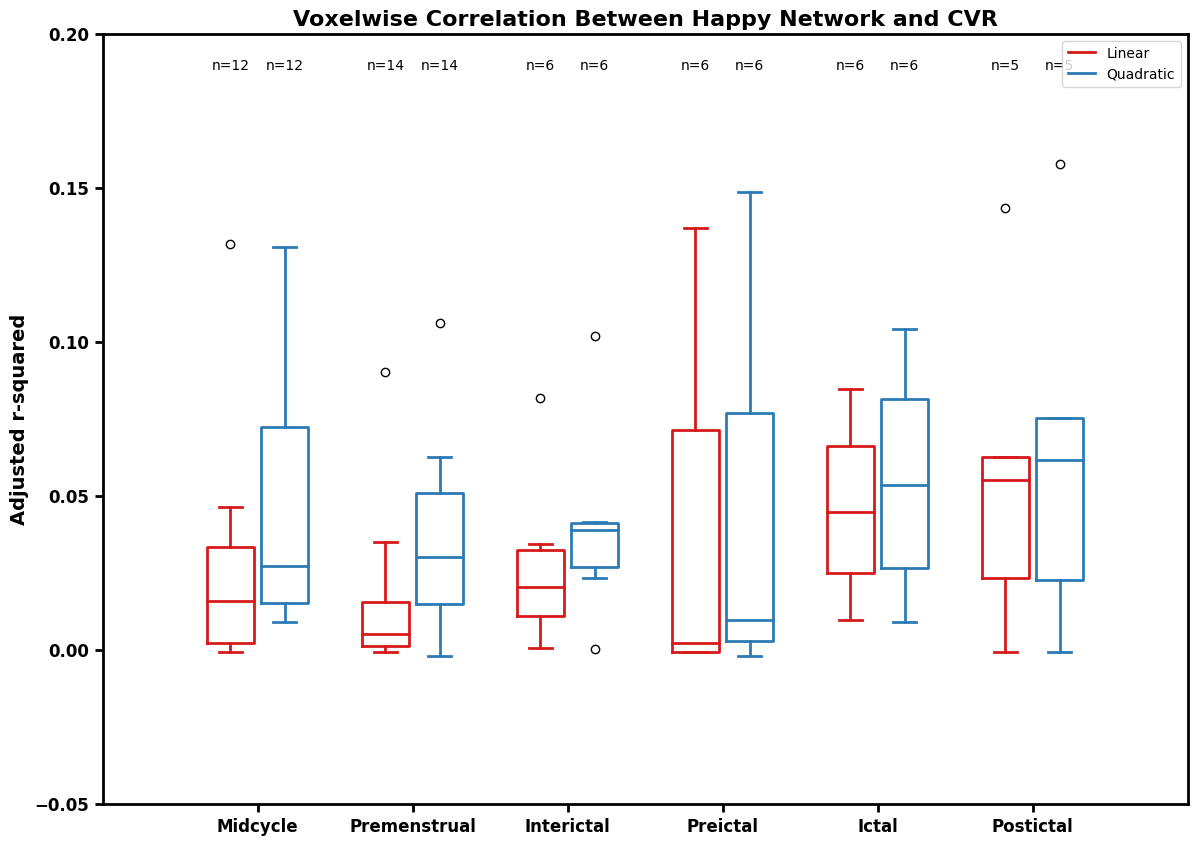

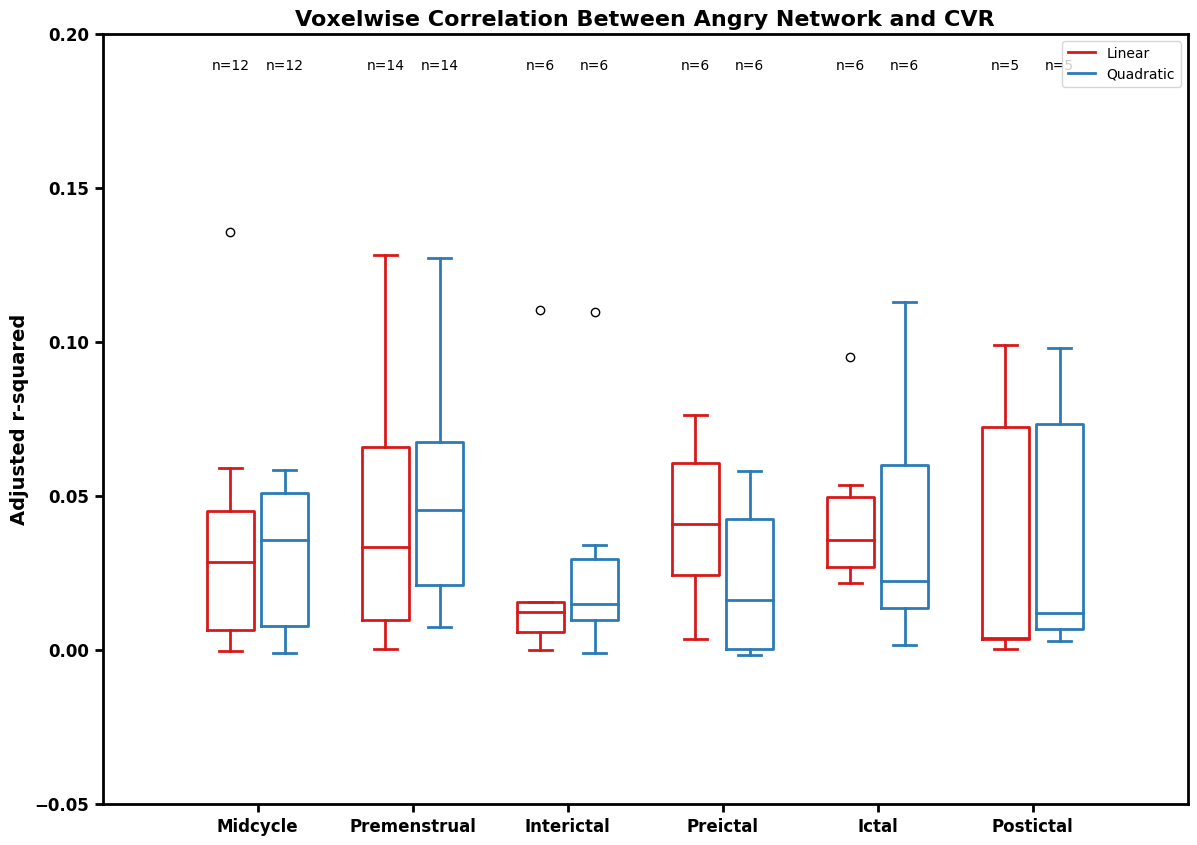

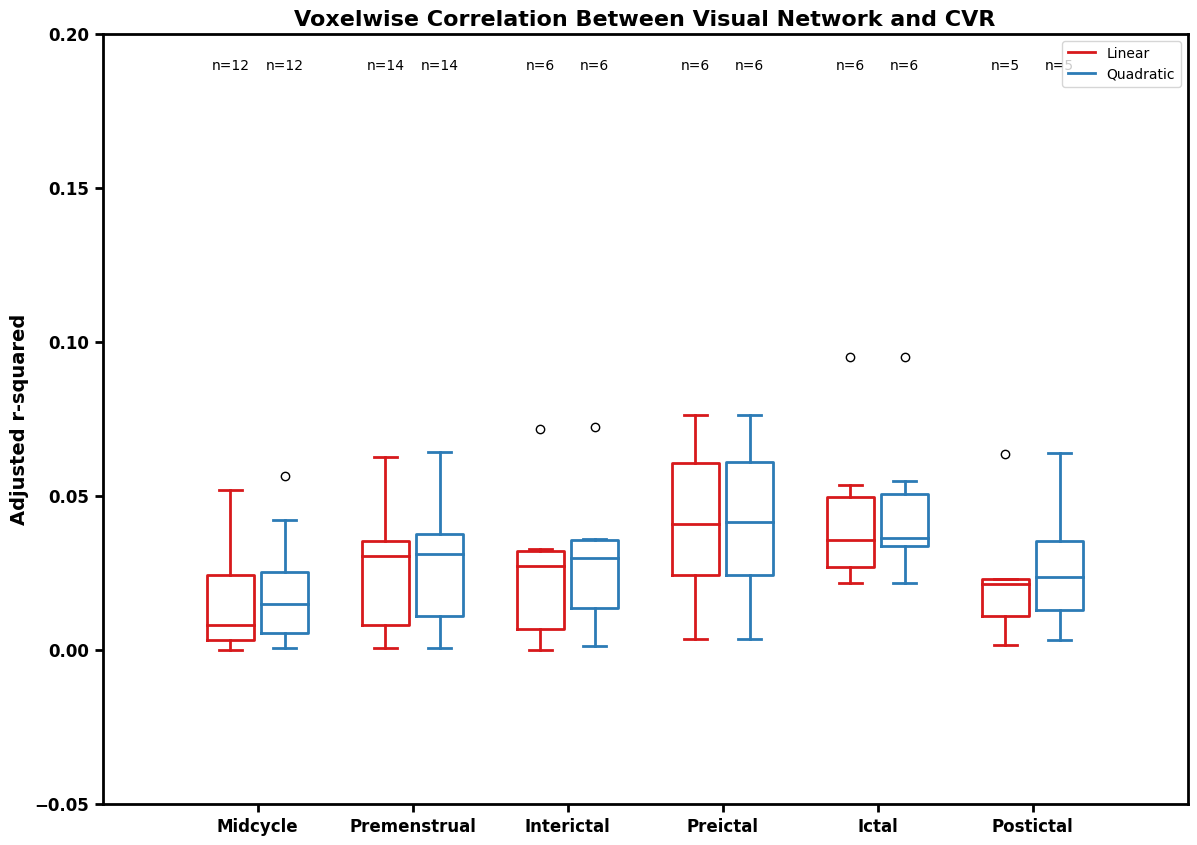

In [36]:
linearplotshappy = [CVRlinH_mid, CVRlinH_premens, CVRlinH_int,CVRlinH_preict,CVRlinH_ict,CVRlinH_postict]
linearplotsangry = [CVRlinA_mid, CVRlinA_premens, CVRlinA_int,CVRlinV_preict,CVRlinV_ict,CVRlinA_postict]
linearplotsvis = [CVRlinV_mid, CVRlinV_premens,CVRlinV_int,CVRlinV_preict,CVRlinV_ict,CVRlinV_postict]

quadplotshappy = [CVRquadH_mid, CVRquadH_premens, CVRquadH_int,CVRquadH_preict, CVRquadH_ict, CVRquadH_postict]
quadplotsangry = [CVRquadA_mid, CVRquadA_premens, CVRquadA_int,CVRquadA_preict, CVRquadA_ict, CVRquadA_postict]
quadplotsvis = [CVRquadV_mid, CVRquadV_premens, CVRquadV_int,CVRquadV_preict, CVRquadV_ict, CVRquadV_postict]

boxplots2(linearplotshappy,quadplotshappy,'Happy Network','CVR')
boxplots2(linearplotsangry,quadplotsangry,"Angry Network","CVR")
boxplots2(linearplotsvis,quadplotsvis,'Visual Network','CVR')

### Polynomial

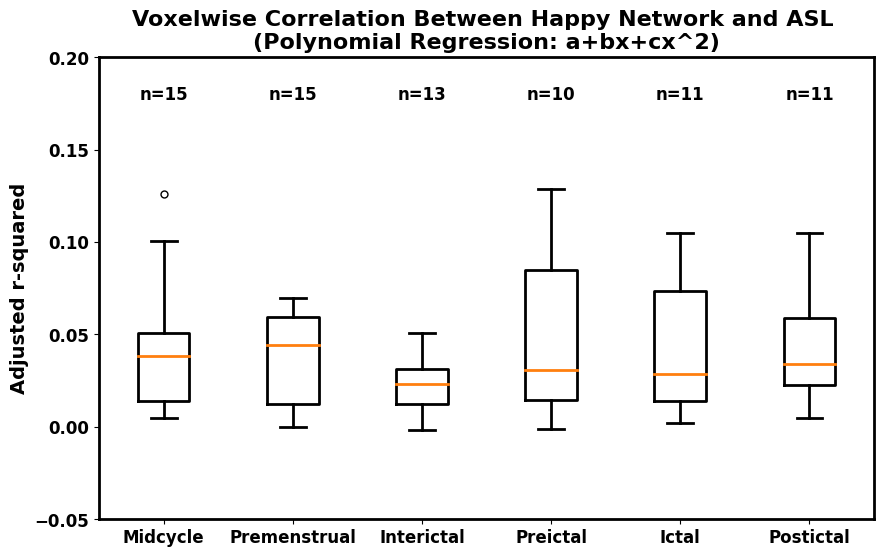

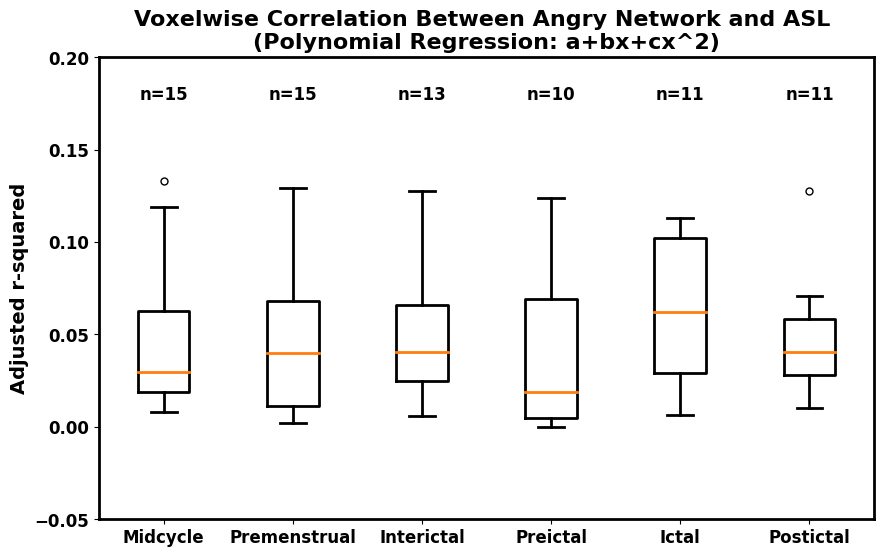

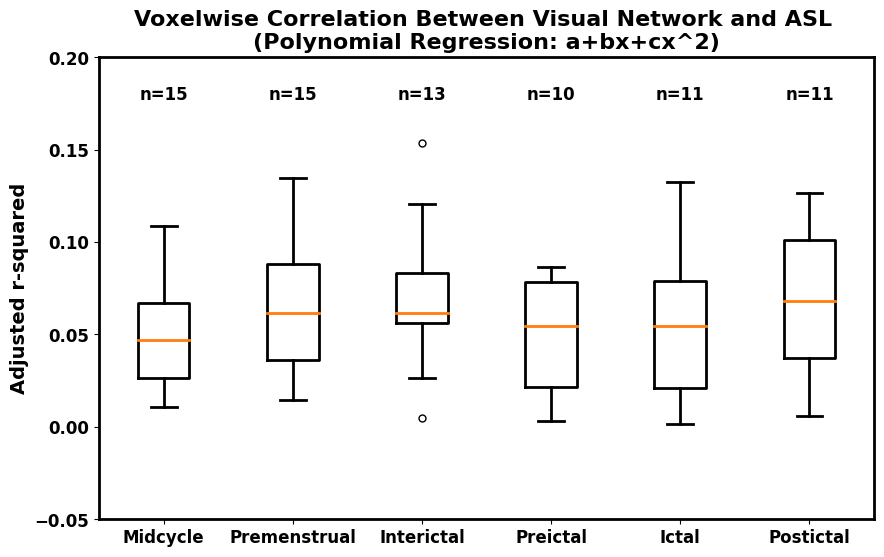

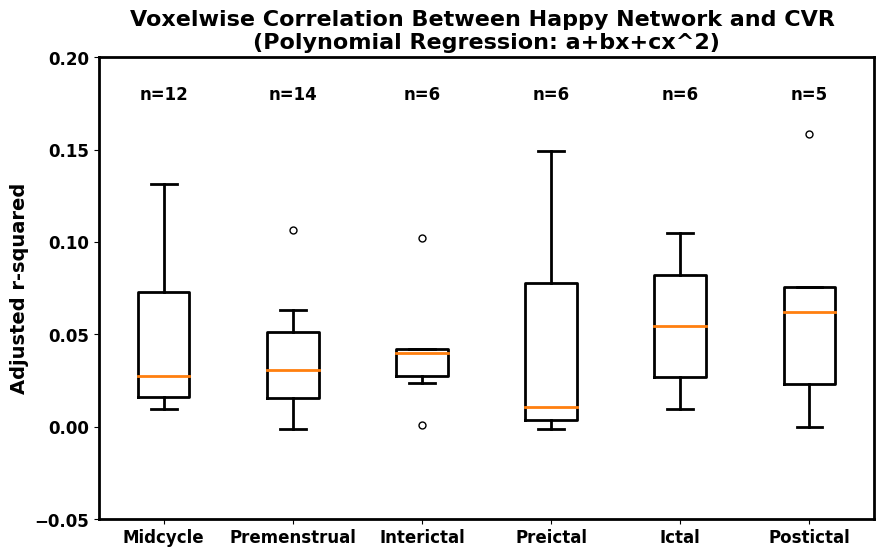

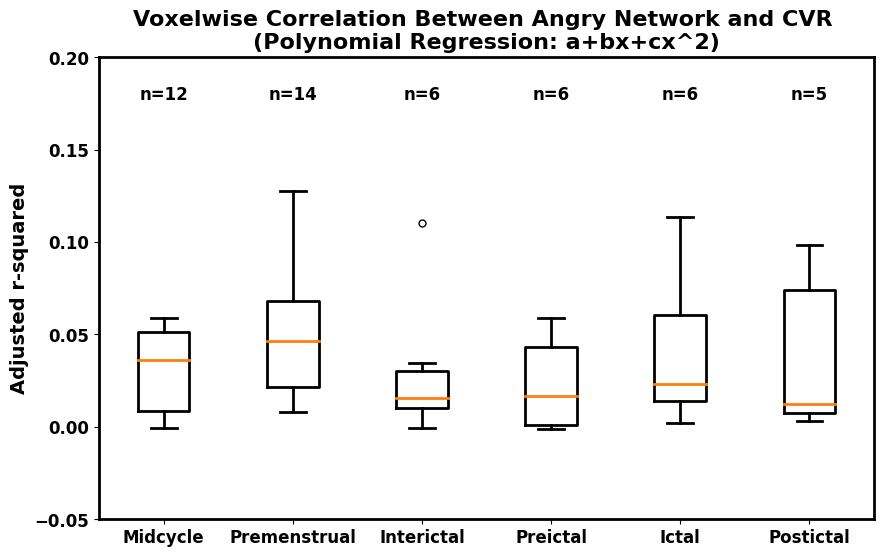

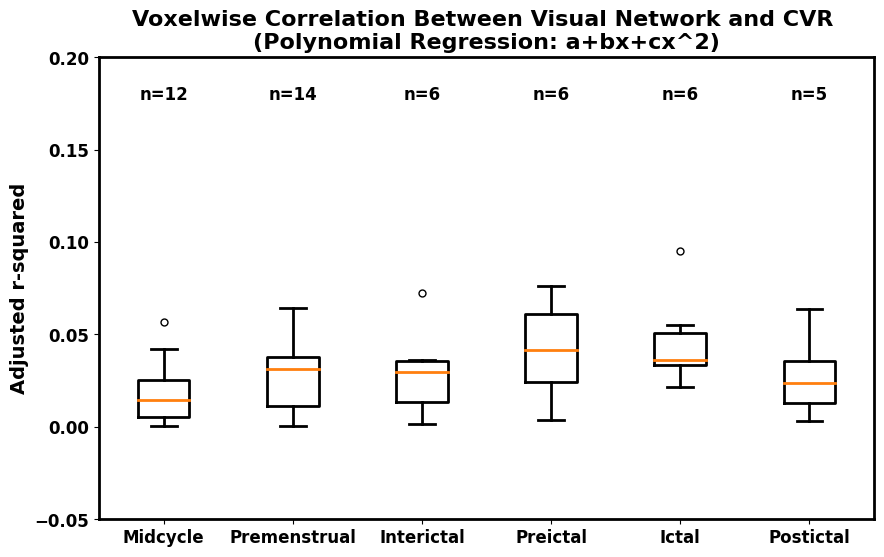

In [37]:
boxplots2_poly([ASLpolyr2happy_midcycle,ASLpolyr2happy_premens,ASLpolyr2happy_int,ASLpolyr2happy_preict,ASLpolyr2happy_ict,ASLpolyr2happy_postict],"Happy Network","ASL")
boxplots2_poly([ASLpolyr2angry_midcycle,ASLpolyr2angry_premens,ASLpolyr2angry_int,ASLpolyr2angry_preict,ASL_polyr2angry_ict,ASpolyr2angry_postict],"Angry Network","ASL")
boxplots2_poly([ASLpolyr2vis_midcycle,ASLpolyr2vis_premens,ASLpolyr2vis_int,ASLpolyr2vis_preict,ASL_polyr2vis_ict,ASLpolyr2vis_postict],"Visual Network","ASL")

boxplots2_poly([CVRpolyr2happy_midcycle,CVRpolyr2happy_premens,CVRpolyr2happy_int,CVRpolyr2happy_preict,CVRpolyr2happy_ict,CVRpolyr2happy_postict],"Happy Network","CVR")
boxplots2_poly([CVRpolyr2angry_midcycle,CVRpolyr2angry_premens,CVRpolyr2angry_int,CVRpolyr2angry_preict,CVRpolyr2angry_ict,CVRpolyr2angry_postict],"Angry Network","CVR")
boxplots2_poly([CVRpolyr2vis_midcycle,CVRpolyr2vis_premens,CVRpolyr2vis_int,CVRpolyr2vis_preict,CVRpolyr2vis_ict,CVRpolyr2vis_postict],"Visual Network","CVR")

### Pearson and Spearman

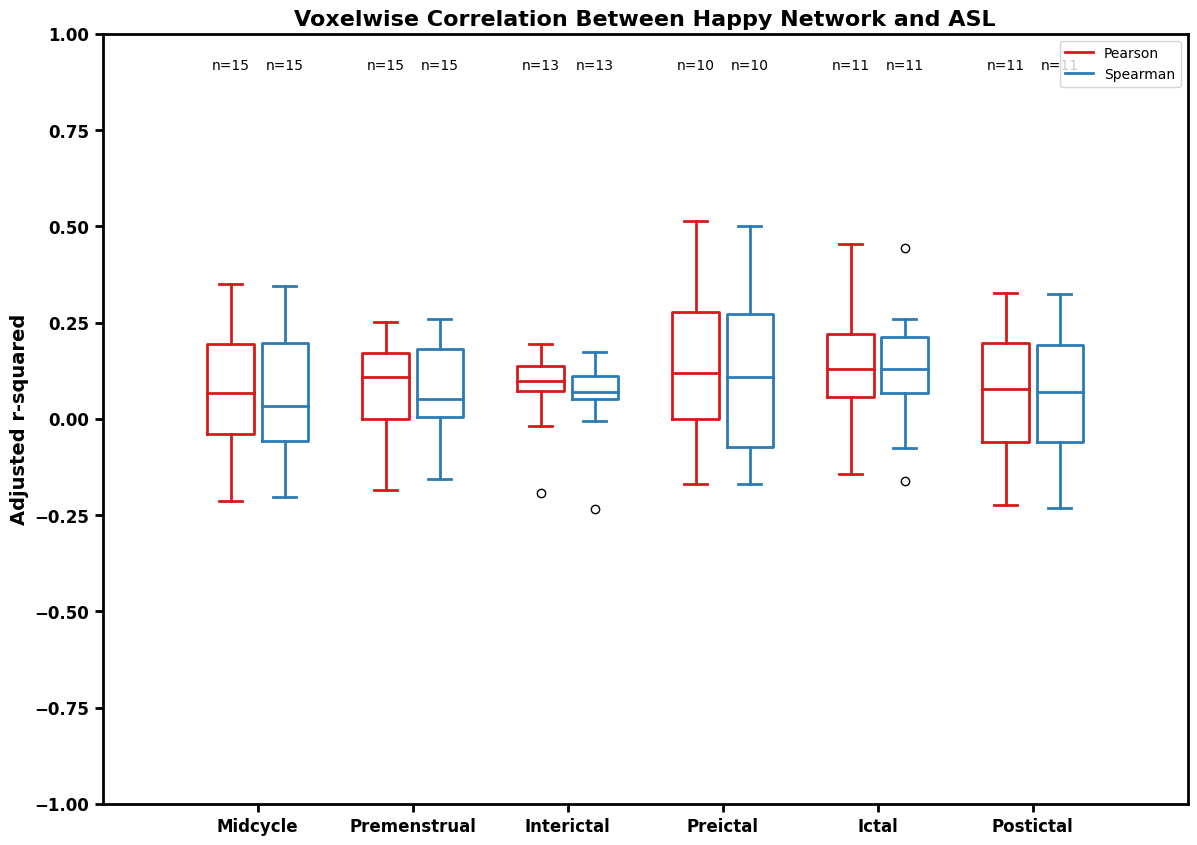

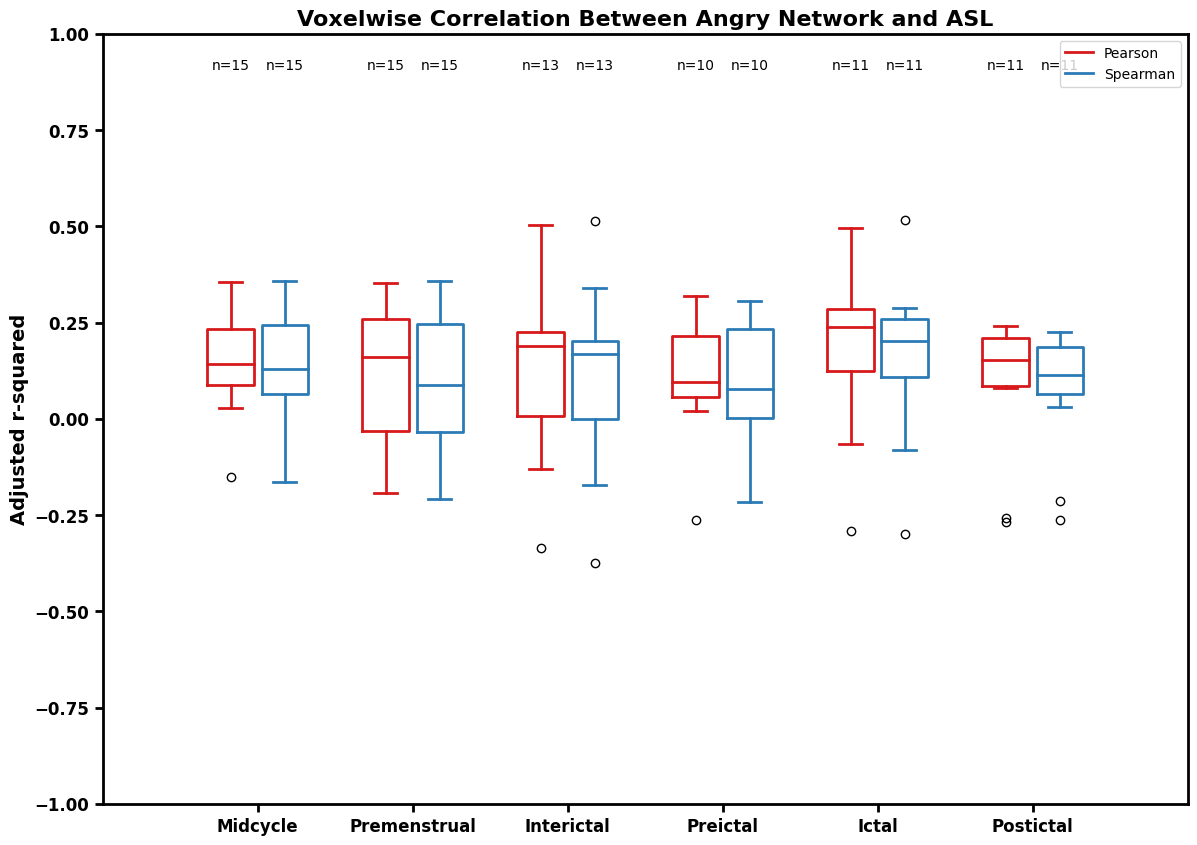

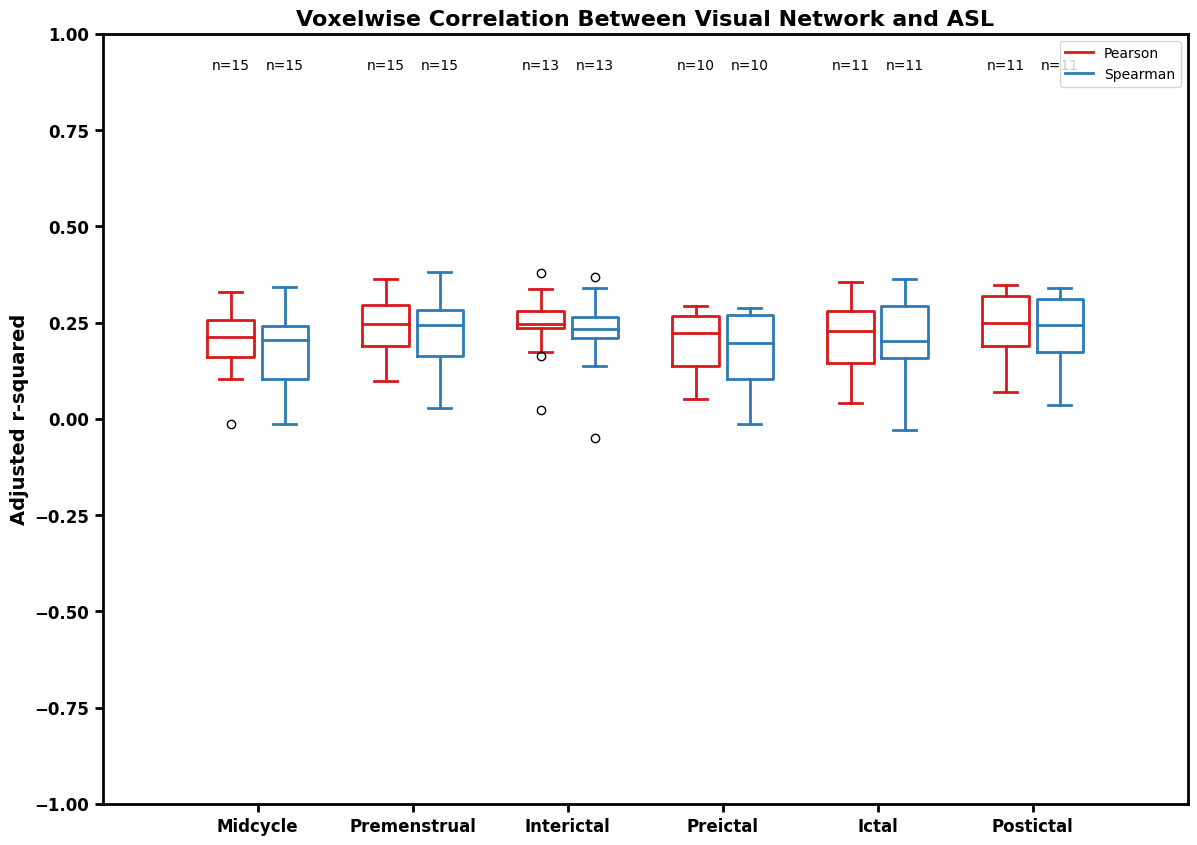

In [38]:
pearsonhappyASL = [ASLph_mid,ASLph_premens,ASLph_int,ASLph_preict,ASLph_ict,ASLph_postict]
pearsonangryASL = [ASLpa_mid,ASLpa_premens,ASLpa_int,ASLpa_preict,ASLpa_ict,ASLpa_postict]
pearsonvisualASL = [ASLpv_mid,ASLpv_premens,ASLpv_int,ASLpv_preict,ASLpv_ict,ASLpv_postict]

spearmanhappyASL = [ASLsh_mid,ASLsh_premens,ASLsh_int,ASLsh_preict,ASLsh_ict,ASLsh_postict]
spearmanangryASL = [ASLsa_mid,ASLsa_premens,ASLsa_int,ASLsa_preict,ASLsa_ict,ASLsa_postict]
spearmanvisualASL = [ASLsv_mid,ASLsv_premens,ASLsv_int,ASLsv_preict,ASLsv_ict,ASLsv_postict]

boxplots2_pands(pearsonhappyASL,spearmanhappyASL,"Happy Network","ASL")
boxplots2_pands(pearsonangryASL,spearmanangryASL,"Angry Network", "ASL")
boxplots2_pands(pearsonvisualASL,spearmanvisualASL,"Visual Network","ASL")

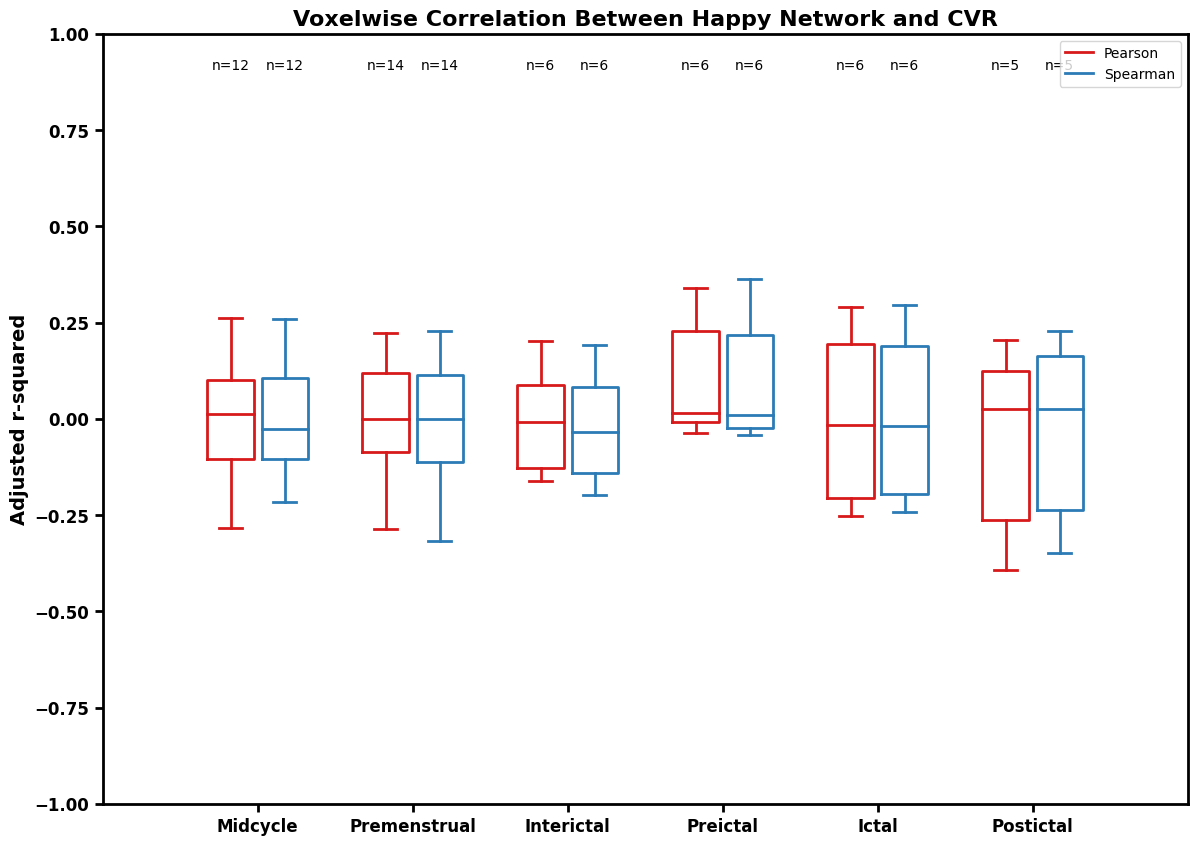

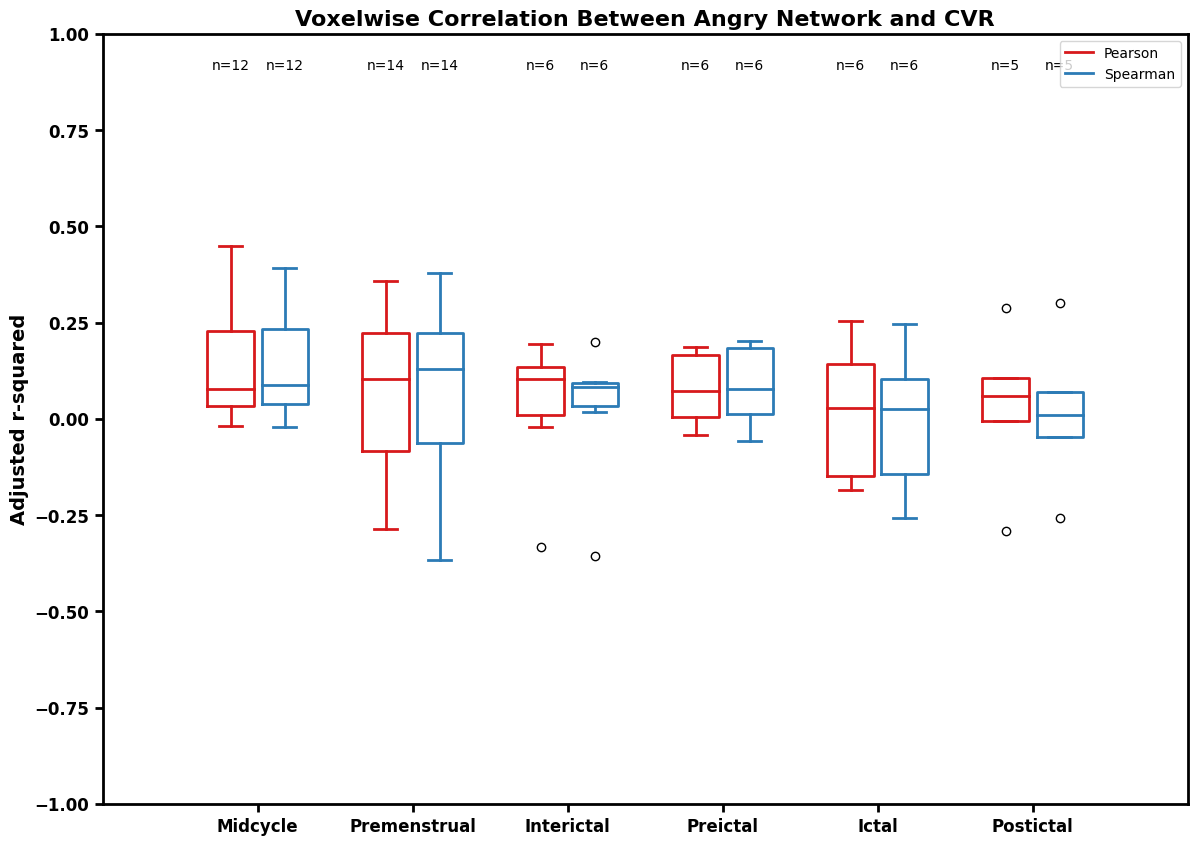

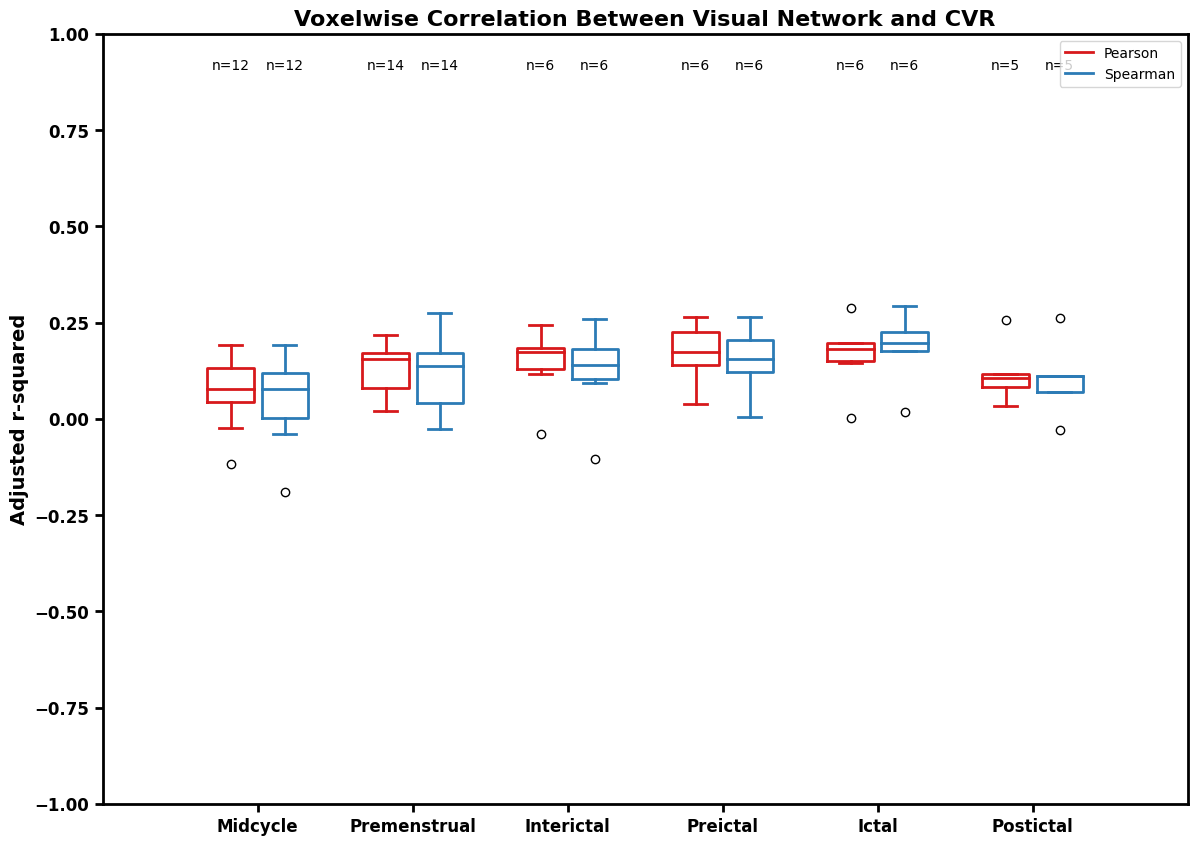

In [39]:
pearsonhappyCVR = [CVRph_mid,CVRph_premens,CVRph_int,CVRph_preict,CVRph_ict,CVRph_postict]
pearsonangryCVR = [CVRpa_mid,CVRpa_premens,CVRpa_int,CVRpa_preict,CVRpa_ict,CVRpa_postict]
pearsonvisualCVR = [CVRpv_mid,CVRpv_premens,CVRpv_int,CVRpv_preict,CVRpv_ict,CVRpv_postict]

spearmanhappyCVR = [CVRsh_mid,CVRsh_premens,CVRsh_int,CVRsh_preict,CVRsh_ict,CVRsh_postict]
spearmanangryCVR = [CVRsa_mid,CVRsa_premens,CVRsa_int,CVRsa_preict,CVRsa_ict,CVRsa_postict]
spearmanvisualCVR = [CVRsv_mid,CVRsv_premens,CVRsv_int,CVRsv_preict,CVRsv_ict,CVRsv_postict]

boxplots2_pands(pearsonhappyCVR,spearmanhappyCVR,"Happy Network","CVR")
boxplots2_pands(pearsonangryCVR,spearmanangryCVR,"Angry Network", "CVR")
boxplots2_pands(pearsonvisualCVR,spearmanvisualCVR,"Visual Network","CVR")

### Spearman Only ASL

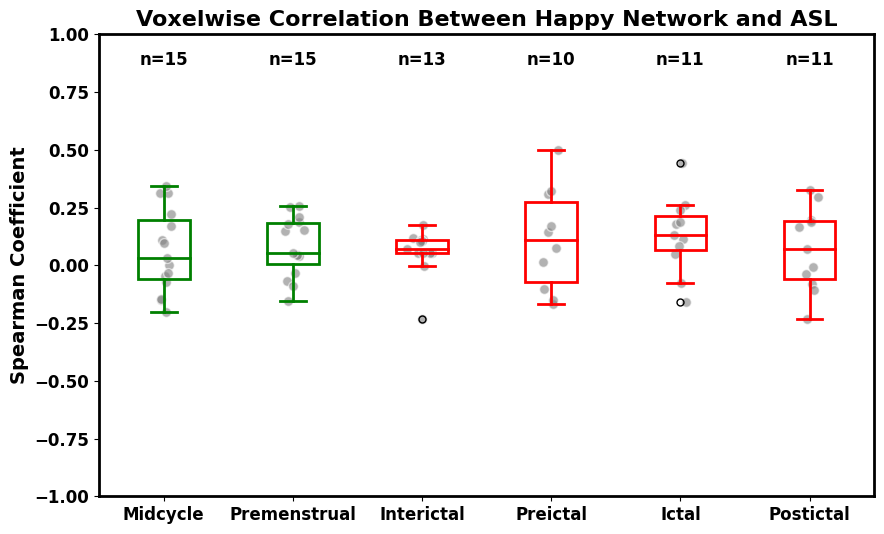

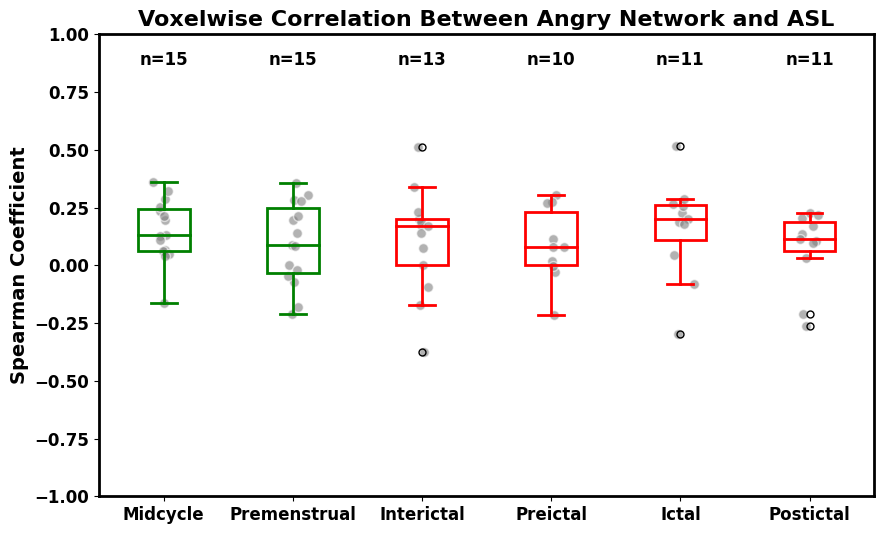

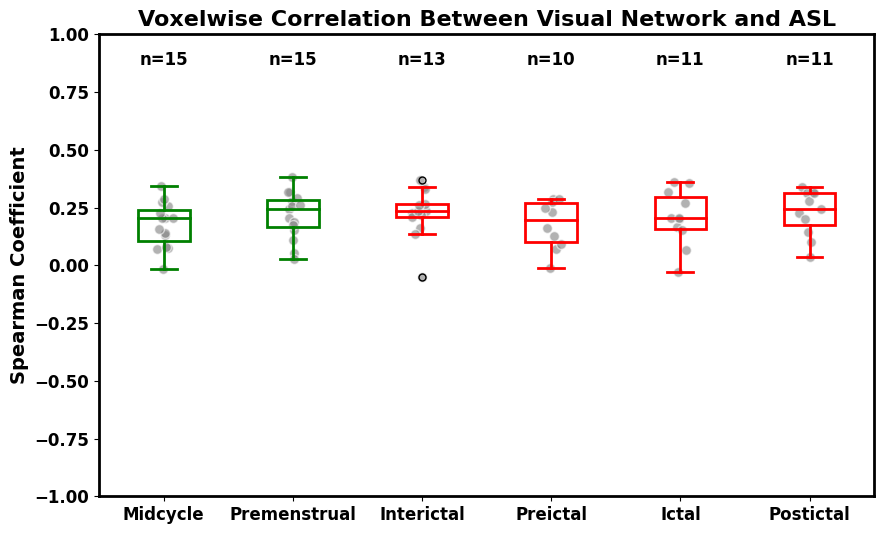

In [40]:
boxplots2_spearman(spearmanhappyASL, "Happy Network", "ASL")
boxplots2_spearman(spearmanangryASL, "Angry Network", "ASL")
boxplots2_spearman(spearmanvisualASL, "Visual Network", "ASL")

In [41]:
# stats for spearman asl

asl_happy = all_stats(spearmanhappyASL)
print('-'*10)
asl_angry = all_stats(spearmanangryASL)
print('-'*10)
asl_vis = all_stats(spearmanvisualASL)

Midcycle vs Interictal (Welch): p-value = 0.93897
Premenstrual vs Preictal: p-value = 0.67253
Premenstrual vs Ictal: p-value = 0.38551
Premenstrual vs Postictal: p-value = 0.85467
Midcycle vs Premenstrual: p-value = 0.76363
----------
Midcycle vs Interictal: p-value = 0.51865
Premenstrual vs Preictal: p-value = 0.94166
Premenstrual vs Ictal: p-value = 0.38973
Premenstrual vs Postictal (Welch): p-value = 0.77740
Midcycle vs Premenstrual: p-value = 0.35653
----------
Midcycle vs Interictal: p-value = 0.20377
Premenstrual vs Preictal: p-value = 0.34640
Premenstrual vs Ictal: p-value = 0.81341
Premenstrual vs Postictal: p-value = 0.77678
Midcycle vs Premenstrual: p-value = 0.19940


### Only Spearman CVR 

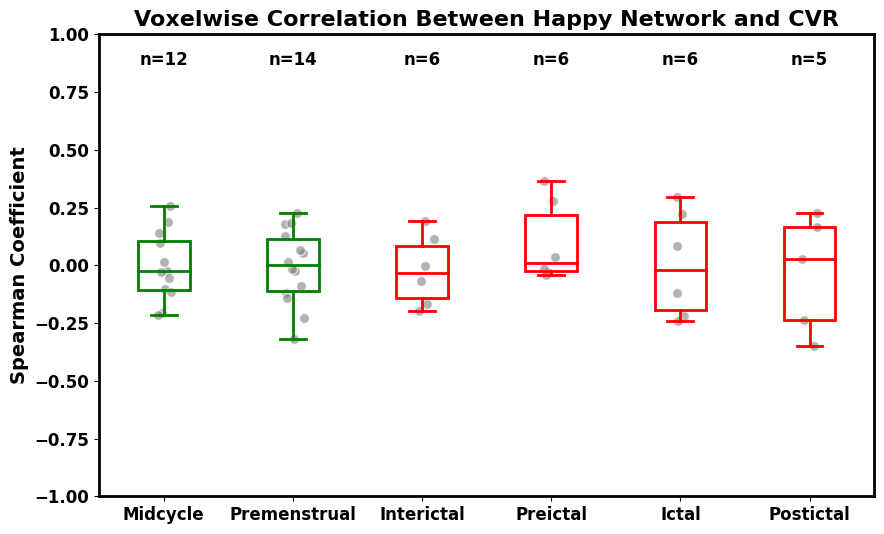

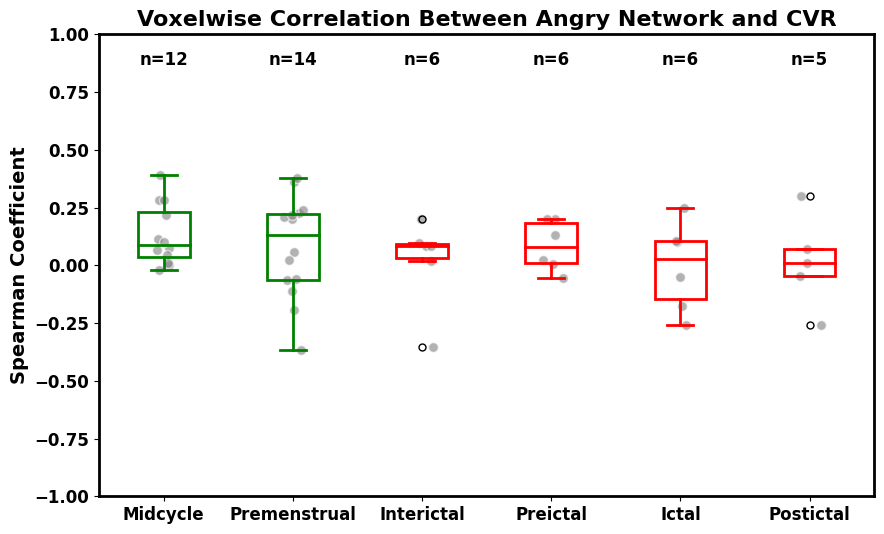

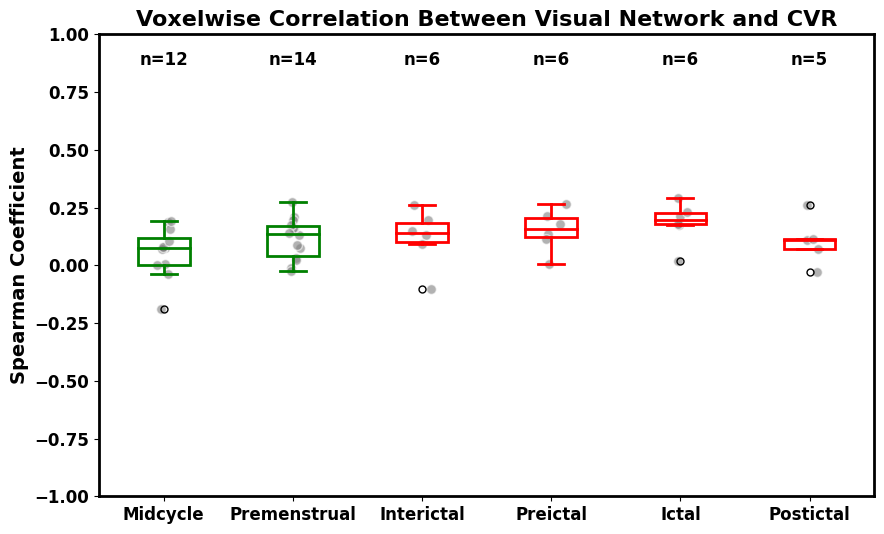

In [42]:
boxplots2_spearman(spearmanhappyCVR, "Happy Network", "CVR")
boxplots2_spearman(spearmanangryCVR, "Angry Network", "CVR")
boxplots2_spearman(spearmanvisualCVR, "Visual Network", "CVR")

In [43]:
cvr_happy = all_statsCVR(spearmanhappyCVR)
print('-'*10)
cvr_angry = all_statsCVR(spearmanangryCVR)
print('-'*10)
cvr_vis = all_statsCVR(spearmanvisualCVR)
print('-'*10)

Midcycle vs Interictal: p-value = 0.82324
Premenstrual vs Preictal (Welch): p-value = 0.24515
Premenstrual vs Ictal: p-value = 0.91730
Premenstrual vs Postictal: p-value = 0.77935
Midcycle vs Premenstrual: p-value = 0.97962
----------
Midcycle vs Interictal (Welch): p-value = 0.24694
Premenstrual vs Preictal: p-value = 0.96308
Premenstrual vs Ictal: p-value = 0.42088
Premenstrual vs Postictal: p-value = 0.56998
Midcycle vs Premenstrual: p-value = 0.49495
----------
Midcycle vs Interictal: p-value = 0.30106
Premenstrual vs Preictal: p-value = 0.42691
Premenstrual vs Ictal: p-value = 0.13479
Premenstrual vs Postictal: p-value = 0.82896
Midcycle vs Premenstrual: p-value = 0.16124
----------
